# 1) Polyphen2


In [1]:
#!/usr/bin/env python3
import pandas as pd
import subprocess

# ─── 0. Paths ────────────────────────────────────────────────────────────────
cdkl5_variants    = "/project/ealexov/compbio/shamrat/250519_energy/00_data/" \
                    "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg.xlsx"
batch_out         = "/project/ealexov/compbio/shamrat/250519_energy/" \
                    "05_pathogenicity/01_polyphen2/cdkl5_mutation_polyphen2.txt"
tsv_in            = "/project/ealexov/compbio/shamrat/250519_energy/" \
                    "05_pathogenicity/01_polyphen2/" \
                    "cdkl5_mutation_polyphen2_results.tsv"
polyphen2_results = "/project/ealexov/compbio/shamrat/250519_energy/" \
                    "05_pathogenicity/01_polyphen2/" \
                    "cdkl5_mutation_polyphen2_results.xlsx"
merged_out        = "/project/ealexov/compbio/shamrat/250519_energy/" \
                    "05_pathogenicity/01_polyphen2/" \
                    "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_polyphen2.xlsx"

uniprot_id = "O76039"


# ─── 1.1 Prepare batch submission for webserver ──────────────────────────────
df = pd.read_excel(cdkl5_variants)
for col in ("wild", "position", "mutant"):
    if col not in df.columns:
        raise KeyError(f"Column '{col}' not found in {cdkl5_variants}")

lines = []
for _, row in df.iterrows():
    wt, pos, mt = row["wild"], row["position"], row["mutant"]
    if pd.isna(wt) or pd.isna(pos) or pd.isna(mt):
        continue
    lines.append(f"{uniprot_id} {int(pos)} {wt} {mt}")

with open(batch_out, "w") as fo:
    fo.write("\n".join(lines))
print(f"Wrote {len(lines)} variants to {batch_out}")


# ─── 1.2 Preview batch file head ────────────────────────────────────────────
subprocess.run(["head", batch_out])


# ─── 1.3 Convert returned TSV → Excel ────────────────────────────────────────
df_pp2 = pd.read_csv(tsv_in, sep="\t", engine="python")
df_pp2.columns = [c.strip().lstrip("#") for c in df_pp2.columns]
df_pp2.to_excel(polyphen2_results, index=False)
print(f"Wrote {len(df_pp2)} rows to {polyphen2_results}")


# ─── 1.4 Preview the new Excel & original columns ───────────────────────────
df_check = pd.read_excel(polyphen2_results)
print("PolyPhen-2 results head:\n", df_check.head().to_string(), "\n")
df_orig = pd.read_excel(cdkl5_variants)
print("cdkl5_variants columns:", df_orig.columns.tolist())


# ─── 1.5 Merge PolyPhen-2 into your variants (1:1 mapping) ───────────────────
variants_df = pd.read_excel(cdkl5_variants)
pp2_df       = pd.read_excel(polyphen2_results)

# Normalize key columns
variants_df['position'] = variants_df['position'].astype(int)
pp2_df['pos']          = pp2_df['pos'].astype(int)

# Select + rename
cols_to_pull = ['pos', 'prediction', 'pph2_prob', 'pph2_FPR', 'pph2_TPR']
pp2_small    = pp2_df[cols_to_pull].rename(columns={'pos': 'position'})

# Drop any duplicate positions (keep the first)
pp2_unique = pp2_small.drop_duplicates(subset='position', keep='first')

# Map back onto the original DataFrame
lookup = pp2_unique.set_index('position')
for col in ['prediction', 'pph2_prob', 'pph2_FPR', 'pph2_TPR']:
    variants_df[col] = variants_df['position'].map(lookup[col])

# Optional diagnostics
missing = variants_df['prediction'].isna().sum()
print(f"{missing} out of {len(variants_df)} variants had NO PolyPhen-2 result.")
extra_pp2 = set(pp2_unique['position']) - set(variants_df['position'])
print(f"{len(extra_pp2)} PolyPhen-2 positions didn’t match any original variants.")

# Write merged file
variants_df.to_excel(merged_out, index=False)
print(f"Wrote {len(variants_df)} rows (1:1 mapping) to {merged_out}")


Wrote 156 variants to /project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/01_polyphen2/cdkl5_mutation_polyphen2.txt
O76039 3 I F
O76039 5 N D
O76039 13 F S
O76039 20 G R
O76039 20 G V
O76039 20 G D
O76039 21 E G
O76039 22 G V
O76039 22 G E
O76039 24 Y C
Wrote 156 rows to /project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/01_polyphen2/cdkl5_mutation_polyphen2_results.xlsx
PolyPhen-2 results head:
                   o_acc  o_pos  o_aa1  o_aa2        rsid         acc  pos  aa1  aa2          prediction  pph2_prob  pph2_FPR  pph2_TPR
0  O76039                    3      I      F           ?  O76039        3    I    F   probably damaging      0.999   0.00574   0.13600
1  O76039                    5      N      D           ?  O76039        5    N    D              benign      0.114   0.14200   0.92700
2  O76039                   13      F      S           ?  O76039       13    F    S   probably damaging      1.000   0.00026   0.00018
3  O76039                   20     

In [8]:
import pandas as pd
from IPython.display import display

file_path = '/project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/01_polyphen2/01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_polyphen2.xlsx'

# Read Excel
df = pd.read_excel(file_path)

# Display the first few rows (nicely in Jupyter/IPython)
display(df.head())

# Print column names as a list
def print_column_names(dataframe):
    print("🧩 Column names:")
    for col in dataframe.columns:
        print(f"- {col}")

print_column_names(df)


,Name,Gene(s),Protein change,mutation,wild,position,mutant,Allele Frequency,Condition(s),Accession,...,Variant type,Molecular consequence,Germline classification,Source,Germline date last evaluated,Germline review status,prediction,pph2_prob,pph2_FPR,pph2_TPR
0,ENSP00000369325.3:p.Ile3Phe,CDKL5,I3F,I3F,I,3,F,0.000009,Healthy,NaN,...,single nucleotide variant,missense_variant,Benign,1000genome,NaN,NaN,probably damaging,0.999,0.00574,0.13600
1,ENSP00000369325.3:p.Asn5Asp,CDKL5,N5D,N5D,N,5,D,0.000003,Healthy,NaN,...,single nucleotide variant,missense_variant,Benign,1000genome,NaN,NaN,benign,0.114,0.14200,0.92700
2,NM_001323289.2(CDKL5):c.38T>C (p.Phe13Ser),CDKL5,F13S,F13S,F,13,S,NaN,CDKL5 disorder,VCV000929426,...,single nucleotide variant,missense variant,Likely pathogenic,Clinvar,"Sep 1, 2022",reviewed by expert panel,probably damaging,1.000,0.00026,0.00018
3,NM_001323289.2(CDKL5):c.58G>C (p.Gly20Arg),CDKL5,G20R,G20R,G,20,R,NaN,"Developmental and epileptic encephalopathy, 2|...",VCV000143828,...,single nucleotide variant,missense variant,Pathogenic,Clinvar,"Nov 11, 2024","criteria provided, multiple submitters, no con...",probably damaging,1.000,0.00026,0.00018
4,NM_001323289.2(CDKL5):c.59G>T (p.Gly20Val),CDKL5,G20V,G20V,G,20,V,NaN,CDKL5 disorder,VCV000918032,...,single nucleotide variant,missense variant,Pathogenic,Clinvar,"Mar 26, 2021",reviewed by expert panel,probably damaging,1.000,0.00026,0.00018


🧩 Column names:
- Name
- Gene(s)
- Protein change
- mutation
- wild
- position
- mutant
- Allele Frequency
- Condition(s)
- Accession
- GRCh37Chromosome
- GRCh37Location
- GRCh38Chromosome
- GRCh38Location
- VariationID
- AlleleID(s)
- dbSNP ID
- Canonical SPDI
- Variant type
- Molecular consequence
- Germline classification
- Source
- Germline date last evaluated
- Germline review status
- prediction
- pph2_prob
- pph2_FPR
- pph2_TPR


## Class count of 'Germline classification' and 'Prediction' column

In [14]:
import pandas as pd

# Load the merged table
file_path = (
    "/project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/01_polyphen2/"
    "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_polyphen2.xlsx"
)
df = pd.read_excel(file_path)

# 1) Ensure 'position' is numeric, then filter to 1–302
df['position'] = pd.to_numeric(df['position'], errors='coerce')
df = df[df['position'].between(1, 302)]

# 2) Germline classification counts
germ_counts = df['Germline classification'] \
    .value_counts(dropna=False) \
    .rename_axis('Germline classification') \
    .reset_index(name='Count')
print("Germline classification (positions 1–302):")
print(germ_counts.to_string(index=False))

# 3) Raw PolyPhen-2 prediction counts (all three classes)
df['prediction_clean'] = df['prediction'].str.lower().str.strip()
raw_pred_counts = df['prediction_clean'] \
    .value_counts(dropna=False) \
    .rename_axis('PolyPhen-2 prediction') \
    .reset_index(name='Count')
print("\nPolyPhen-2 predictions (positions 1–302):")
print(raw_pred_counts.to_string(index=False))


Germline classification (positions 1–302):
                     Germline classification  Count
                      Uncertain significance     30
                Pathogenic/Likely pathogenic     24
                           Likely pathogenic     22
                        Benign/Likely benign     12
Conflicting classifications of pathogenicity     10
                                  Pathogenic      9
                                      Benign      4
                               Likely benign      1

PolyPhen-2 predictions (positions 1–302):
PolyPhen-2 prediction  Count
    probably damaging     98
               benign      7
    possibly damaging      7


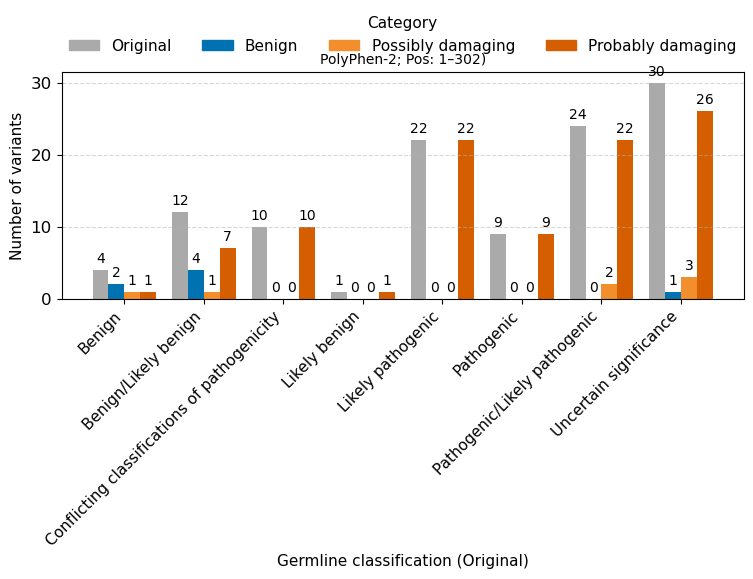

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

def plot_reclassification(
    df: pd.DataFrame,
    position_range=(1, 302),
    figsize=(10, 6),
    title_fontsize=16,
    label_fontsize=14,
    tick_fontsize=12,
    annotation_fontsize=10,
    bar_width_ratio=0.8,
    colors=None,
    title=None
):
    """
    Plot original Germline classification counts alongside PolyPhen-2 prediction breakdown.
    Allows separate control of title, label, tick, and annotation font sizes.

    Parameters:
    - df: DataFrame with columns 'position', 'Germline classification', 'prediction'
    - position_range: tuple(min, max) to filter 'position'
    - figsize: tuple(width, height)
    - title_fontsize: font size for the title
    - label_fontsize: font size for axis labels
    - tick_fontsize: font size for tick labels
    - annotation_fontsize: font size for the bar count annotations
    - bar_width_ratio: total width occupied by all bars per group (fraction of 1)
    - colors: dict mapping 'original' and prediction labels to colors
    - title: optional plot title
    """
    # Filter & clean
    df = df[df['position'].between(*position_range)].copy()
    df['prediction_clean'] = df['prediction'].str.lower().str.strip()

    # Prepare data
    preds = ['benign', 'possibly damaging', 'probably damaging']
    cross = pd.crosstab(df['Germline classification'], df['prediction_clean'])[preds]
    original = df['Germline classification'].value_counts().reindex(cross.index)

    # Default colors
    if colors is None:
        colors = {
            'original': '#AAAAAA',
            'benign': '#0072B2',
            'possibly damaging': '#F28E2B',
            'probably damaging': '#D55E00'
        }

    fig, ax = plt.subplots(figsize=figsize)

    n_groups = len(cross)
    n_bars = 1 + len(preds)
    total_width = bar_width_ratio
    bar_width = total_width / n_bars
    x = np.arange(n_groups)

    # Plot
    for i, key in enumerate(['original'] + preds):
        counts = original.values if key == 'original' else cross[key].values
        offset = -total_width/2 + i * bar_width + bar_width/2
        positions = x + offset
        ax.bar(positions, counts, bar_width, color=colors[key],
               label='Original' if key=='original' else key.capitalize())
        # Annotate
        for pos, cnt in zip(positions, counts):
            ax.text(pos, cnt + max(original.max(), cross.values.max())*0.02,
                    str(int(cnt)), ha='center', va='bottom',
                    fontsize=annotation_fontsize)

    # Axes & Title
    ax.set_xticks(x)
    ax.set_xticklabels(cross.index, rotation=45, ha='right', fontsize=tick_fontsize)
    ax.set_xlabel('Germline classification (Original)', fontsize=label_fontsize)
    ax.set_ylabel('Number of variants', fontsize=label_fontsize)
    ax.set_title(title or f'Reclassification vs. Original Counts\n(Positions {position_range[0]}–{position_range[1]})',
                 fontsize=title_fontsize)

    # Legend above
    handles = [Patch(color=colors['original'], label='Original')] + \
              [Patch(color=colors[p], label=p.capitalize()) for p in preds]
    ax.legend(handles=handles, title='Category',
              loc='lower center', bbox_to_anchor=(0.5, 1.02),
              ncol=len(handles), frameon=False, fontsize=tick_fontsize, title_fontsize=label_fontsize)

    ax.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


# -----------------------
# Example usage:
# -----------------------
if __name__ == "__main__":
    # Load your merged table
    file_path = (
        "/project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/01_polyphen2/"
        "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_polyphen2.xlsx"
    )
    df_merged = pd.read_excel(file_path)

    # Plot with custom font sizes
    plot_reclassification(
        df_merged,
        position_range=(1, 302),
        figsize=(8, 6),
        title_fontsize=10,
        label_fontsize=11,
        tick_fontsize=11,
        annotation_fontsize=10,
        bar_width_ratio=0.8,
        title="PolyPhen-2; Pos: 1–302)"
    )


In [41]:
import pandas as pd
from IPython.display import display

# 1) Load your merged PolyPhen-2 results table
file_path = (
    "/project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/01_polyphen2/"
    "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_polyphen2.xlsx"
)
df = pd.read_excel(file_path)

# 2) Select the columns you asked for
cols = [
    'mutation',
    'position',
    'Germline classification',
    'prediction',
    'pph2_prob',
    'pph2_FPR',
    'pph2_TPR'
]

# 3) Display the first five rows in IPython
display(df[cols].head())


,mutation,position,Germline classification,prediction,pph2_prob,pph2_FPR,pph2_TPR
0,I3F,3,Benign,probably damaging,0.999,0.00574,0.13600
1,N5D,5,Benign,benign,0.114,0.14200,0.92700
2,F13S,13,Likely pathogenic,probably damaging,1.000,0.00026,0.00018
3,G20R,20,Pathogenic,probably damaging,1.000,0.00026,0.00018
4,G20V,20,Pathogenic,probably damaging,1.000,0.00026,0.00018


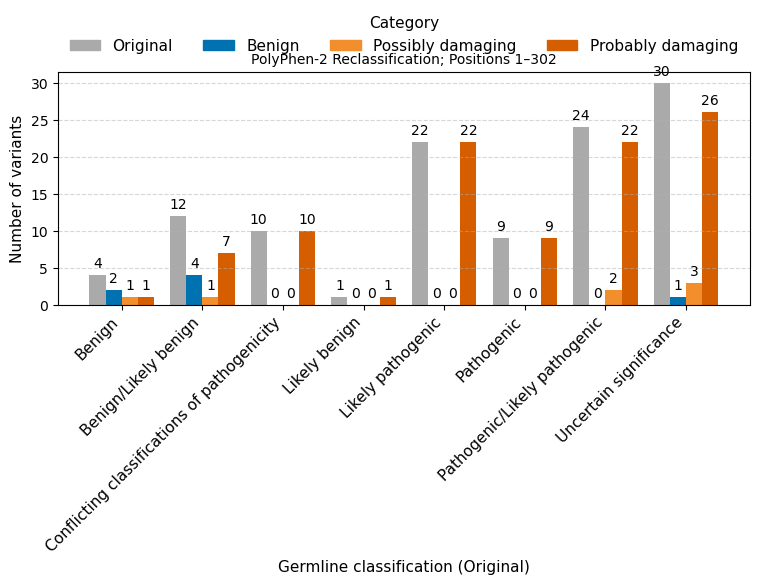


PolyPhen-2 class counts:
prediction_clean
Benign                7
Possibly damaging     7
Probably damaging    98
Name: count, dtype: int64


In [1]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

def plot_reclassification(
    df: pd.DataFrame,
    position_range=(1, 302),
    figsize=(10, 6),
    title_fontsize=16,
    label_fontsize=14,
    tick_fontsize=12,
    annotation_fontsize=10,
    bar_width_ratio=0.8,
    colors=None,
    title=None
) -> pd.Series:
    """
    Plot original Germline classification counts alongside PolyPhen-2 prediction breakdown,
    and return the PolyPhen-2 class counts.

    Returns:
    - A pandas Series indexed by ['benign','possibly damaging','probably damaging']
      with the counts of each PolyPhen-2 class.
    """
    # Filter & clean
    df = df[df['position'].between(*position_range)].copy()
    df['prediction_clean'] = df['prediction'].str.lower().str.strip()

    # Prepare data for plotting
    preds = ['benign', 'possibly damaging', 'probably damaging']
    cross = pd.crosstab(df['Germline classification'], df['prediction_clean'])[preds]
    original = df['Germline classification'].value_counts().reindex(cross.index)

    # Compute PolyPhen-2 counts
    polyphen_counts = df['prediction_clean'].value_counts().reindex(preds, fill_value=0)

    # Default colors
    if colors is None:
        colors = {
            'original': '#AAAAAA',
            'benign': '#0072B2',
            'possibly damaging': '#F28E2B',
            'probably damaging': '#D55E00'
        }

    fig, ax = plt.subplots(figsize=figsize)

    n_groups = len(cross)
    n_bars = 1 + len(preds)
    total_width = bar_width_ratio
    bar_width = total_width / n_bars
    x = np.arange(n_groups)

    # Plot bars + annotations
    for i, key in enumerate(['original'] + preds):
        counts = original.values if key == 'original' else cross[key].values
        offset = -total_width/2 + i * bar_width + bar_width/2
        positions = x + offset
        ax.bar(positions, counts, bar_width, color=colors[key],
               label='Original' if key == 'original' else key.capitalize())
        for pos, cnt in zip(positions, counts):
            ax.text(pos, cnt + max(original.max(), cross.values.max())*0.02,
                    str(int(cnt)), ha='center', va='bottom',
                    fontsize=annotation_fontsize)

    # Axes & Title
    ax.set_xticks(x)
    ax.set_xticklabels(cross.index, rotation=45, ha='right', fontsize=tick_fontsize)
    ax.set_xlabel('Germline classification (Original)', fontsize=label_fontsize)
    ax.set_ylabel('Number of variants', fontsize=label_fontsize)
    ax.set_title(title or f'Reclassification vs. Original Counts\n'
                         f'(Positions {position_range[0]}–{position_range[1]})',
                 fontsize=title_fontsize)

    # Legend above
    handles = [Patch(color=colors['original'], label='Original')] + \
              [Patch(color=colors[p], label=p.capitalize()) for p in preds]
    ax.legend(handles=handles, title='Category',
              loc='lower center', bbox_to_anchor=(0.5, 1.02),
              ncol=len(handles), frameon=False,
              fontsize=tick_fontsize, title_fontsize=label_fontsize)

    ax.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    return polyphen_counts


if __name__ == "__main__":
    # Path to your merged table
    file_path = (
        "/project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/01_polyphen2/"
        "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_polyphen2.xlsx"
    )
    df_merged = pd.read_excel(file_path)

    # Plot and retrieve PolyPhen-2 class counts
    counts = plot_reclassification(
        df_merged,
        position_range=(1, 302),
        figsize=(8, 6),
        title_fontsize=10,
        label_fontsize=11,
        tick_fontsize=11,
        annotation_fontsize=10,
        bar_width_ratio=0.8,
        title="PolyPhen-2 Reclassification; Positions 1–302"
    )

    # Print the PolyPhen-2 counts
    print("\nPolyPhen-2 class counts:")
    print(counts.rename(index={
        'benign': 'Benign',
        'possibly damaging': 'Possibly damaging',
        'probably damaging': 'Probably damaging'
    }))


# 02 MutPred2

## 2.1 Prepare fasta file with mutation for Mutpred2

In [3]:
## MutPred2
## 2.1 Prepare fasta file with mutation for Mutpred2
#!/usr/bin/env python3
import os
import requests
import pandas as pd
from textwrap import wrap

# ─────── CONFIG ───────
UNIPROT_ID = "O76039"
OUT_DIR    = "/project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/02_mutpred2"
BASENAME   = "cdkl5_mutation_mutpred2"
XLSX_PATH  = "/project/ealexov/compbio/shamrat/250519_energy/00_data/01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af.xlsx"
WILD_COL   = "wild"
POS_COL    = "position"
MUT_COL    = "mutant"
SPECIES_TAG= "CDKL5_HUMAN"
MAX_PER    = 100
# ──────────────────────

# 1) fetch WT sequence from UniProt
url   = f"https://rest.uniprot.org/uniprotkb/{UNIPROT_ID}.fasta"
resp  = requests.get(url)
resp.raise_for_status()
lines = resp.text.strip().splitlines()
seq   = "".join(lines[1:])

# 2) read your spreadsheet & build mutation tags
df   = pd.read_excel(XLSX_PATH, usecols=[WILD_COL,POS_COL,MUT_COL])
tags = [f"{wt}{int(pos)}{mt}" for wt,pos,mt in df.itertuples(index=False)]

# 3) chunk into ≤MAX_PER and write one FASTA per chunk
os.makedirs(OUT_DIR, exist_ok=True)
for i in range(0, len(tags), MAX_PER):
    chunk = tags[i : i+MAX_PER]
    idx   = i//MAX_PER + 1
    out_f = os.path.join(OUT_DIR, f"{BASENAME}_part{idx}.fasta")
    with open(out_f, "w") as fh:
        header = f">{SPECIES_TAG}_part{idx} " + " ".join(chunk)
        fh.write(header + "\n")
        for line in wrap(seq, 60):
            fh.write(line + "\n")
    print(f"→ wrote {out_f}")


→ wrote /project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/02_mutpred2/cdkl5_mutation_mutpred2_part1.fasta
→ wrote /project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/02_mutpred2/cdkl5_mutation_mutpred2_part2.fasta


## 2.2 Submit the fasta files and retrived the result

In [ ]:
submit it on server

## 2.3 Process Mutpred2 results

In [4]:
## 2.3 Read Mutpred2 part1 and part2 csv

# === 2.3a View the first few lines of your MutPred2 result CSVs ===S
print('=== 2.3a View the first few lines of your MutPred2 result CSVs ===')

import pandas as pd

# Updated paths with your new filenames
part1_csv = "/project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/02_mutpred2/" \
            "cdkl5_mutation_mutpred2_part1_result.csv"
part2_csv = "/project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/02_mutpred2/" \
            "cdkl5_mutation_mutpred2_part2_result.csv"

# Load and display the first 5 rows of part 1
df1 = pd.read_csv(part1_csv)
print(f"Head of {part1_csv}:")
print(df1.head().to_string(), "\n")

# Load and display the first 5 rows of part 2
df2 = pd.read_csv(part2_csv)
print(f"Head of {part2_csv}:")
print(df2.head().to_string())








# === 2.3b Combine your two MutPred2 CSVs into one table with proper headers ===

import pandas as pd
import os

# paths to your part-1 and part-2 result CSVs
dir02 = "/project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/02_mutpred2"
part1_csv = os.path.join(dir02, "cdkl5_mutation_mutpred2_part1_result.csv")
part2_csv = os.path.join(dir02, "cdkl5_mutation_mutpred2_part2_result.csv")

# 1) Define the column names in the correct order
column_names = [
    "ID",
    "Substitution",
    "MutPred2_score",
    "Molecular_mechanisms",
    "Affected_PROSITE_and_ELM_Motifs",
    "Remarks"
]

# 2) Read each CSV without a header row, assigning your names
df1 = pd.read_csv(part1_csv, header=None, names=column_names)
df2 = pd.read_csv(part2_csv, header=None, names=column_names)

# 3) Concatenate into a single DataFrame
combined = pd.concat([df1, df2], ignore_index=True)

# 4) (Optional) inspect the first few rows
print(combined.head().to_string())

# 5) Write out to a new Excel file, matching your filename style
out_xlsx = os.path.join(
    dir02,
    "cdkl5_mutation_mutpred2_results_combined.xlsx"
)
combined.to_excel(out_xlsx, index=False)
print(f"Wrote combined MutPred2 results to {out_xlsx}")




# === 2.3c Merge MutPred2 into your CDKL5 variants and save ===

import pandas as pd
import os

# paths
variants_xlsx = "/project/ealexov/compbio/shamrat/250519_energy/00_data/" \
                "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg.xlsx"
mutpred2_dir  = "/project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/02_mutpred2"

# use the exact combined filename you generated
combined_xlsx = os.path.join(
    mutpred2_dir,
    "cdkl5_mutation_mutpred2_results_combined.xlsx"
)

# 1) Read your original variants and the combined MutPred2 results
variants_df = pd.read_excel(variants_xlsx, engine="openpyxl")
mutpred_df  = pd.read_excel(combined_xlsx, engine="openpyxl")

# 2) Merge on the variant string: 'mutation' in variants matches 'Substitution' in MutPred2
merged = variants_df.merge(
    mutpred_df,
    left_on="mutation",
    right_on="Substitution",
    how="left"
)

# 3) Write out to Excel, appending '_mutpred2' to the original base name
base = os.path.splitext(os.path.basename(variants_xlsx))[0]
out_path = os.path.join(
    mutpred2_dir,
    f"{base}_mutpred2.xlsx"
)
merged.to_excel(out_path, index=False)
print(f"Wrote merged MutPred2 annotations to {out_path}")


=== 2.3a View the first few lines of your MutPred2 result CSVs ===
Head of /project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/02_mutpred2/cdkl5_mutation_mutpred2_part1_result.csv:
   CDKL5_HUMAN_part1   I3F  0.286                                                                                                                                                                                                                                                                                                                                   -                             -.1  Predicted conservation scores
0  CDKL5_HUMAN_part1   N5D  0.135                                                                                                                                                                                                                                                                                                                                   -                             

In [ ]:
## display mutpred2

In [43]:
import pandas as pd
from IPython.display import display

# 1) Load your merged MutPred2 results
file_path = (
    "/project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/02_mutpred2/"
    "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_mutpred2.xlsx"
)
df = pd.read_excel(file_path, engine="openpyxl")

# 2) Print all column names
print("Columns in the DataFrame:")
print(df.columns.tolist(), "\n")

# 3) Display the first five rows of key columns
cols = [
    "mutation",
    "position",
    "Germline classification",
    "Substitution",
    "MutPred2_score",
    "Molecular_mechanisms",
    "Affected_PROSITE_and_ELM_Motifs",
    "Remarks"
]
display(df[cols].head())


Columns in the DataFrame:
['Name', 'Gene(s)', 'Protein change', 'mutation', 'wild', 'position', 'mutant', 'Allele Frequency', 'Condition(s)', 'Accession', 'GRCh37Chromosome', 'GRCh37Location', 'GRCh38Chromosome', 'GRCh38Location', 'VariationID', 'AlleleID(s)', 'dbSNP ID', 'Canonical SPDI', 'Variant type', 'Molecular consequence', 'Germline classification', 'Source', 'Germline date last evaluated', 'Germline review status', 'ID', 'Substitution', 'MutPred2_score', 'Molecular_mechanisms', 'Affected_PROSITE_and_ELM_Motifs', 'Remarks'] 



,mutation,position,Germline classification,Substitution,MutPred2_score,Molecular_mechanisms,Affected_PROSITE_and_ELM_Motifs,Remarks
0,I3F,3,Benign,I3F,0.286,-,-,Predicted conservation scores
1,N5D,5,Benign,N5D,0.135,-,-,Predicted conservation scores
2,F13S,13,Likely pathogenic,F13S,0.895,Altered Ordered interface (Pr = 0.32 | P = 0.0...,ELME000070|ELME000335|PS00001,Predicted conservation scores
3,G20R,20,Pathogenic,G20R,0.912,Gain of Allosteric site at Y24 (Pr = 0.33 | P ...,PS00107,Predicted conservation scores
4,G20V,20,Pathogenic,G20V,0.928,Altered Metal binding (Pr = 0.32 | P = 0.01); ...,ELME000333|PS00107,Predicted conservation scores


## assign mutpred2 threshold

In [44]:
import pandas as pd
import os

# Directory containing your MutPred2 Excel
mutpred2_dir = "/project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/02_mutpred2"

# Input and output filenames
infile  = "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_mutpred2.xlsx"
# Keep 'mutpred2' at the end of the filename
outfile = "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_classified_mutpred2.xlsx"

# Paths
in_path  = os.path.join(mutpred2_dir, infile)
out_path = os.path.join(mutpred2_dir, outfile)

# 1) Load the merged MutPred2 results
df = pd.read_excel(in_path, engine="openpyxl")

# 2) Add classification column at 0.67 threshold
df['MutPred2_classification'] = df['MutPred2_score'].apply(
    lambda x: 'Pathogenic' if x >= 0.67 else 'Benign'
)

# 3) Save the new file
df.to_excel(out_path, index=False)
print(f"Wrote results with MutPred2 classification to:\n  {out_path}")


Wrote results with MutPred2 classification to:
  /project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/02_mutpred2/01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_classified_mutpred2.xlsx


In [ ]:
## important columns

In [50]:
import pandas as pd
from IPython.display import display

# 1) Path to your classified MutPred2 results file
file_path = (
    "/project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/02_mutpred2/"
    "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_classified_mutpred2.xlsx"
)

# 2) Read the Excel into a DataFrame
df = pd.read_excel(file_path, engine="openpyxl")

# 3) Define columns to display
cols = [
    "mutation",
    "position",
    "Germline classification",
    "MutPred2_score",
    "MutPred2_classification",
    "Molecular_mechanisms",
    "Affected_PROSITE_and_ELM_Motifs",
    "Remarks"
]

# 4) Print the column names
print("Displayed columns:")
print(cols, "\n")

# 5) Display the first five rows
display(df[cols].head())


Displayed columns:
['mutation', 'position', 'Germline classification', 'MutPred2_score', 'MutPred2_classification', 'Molecular_mechanisms', 'Affected_PROSITE_and_ELM_Motifs', 'Remarks'] 



,mutation,position,Germline classification,MutPred2_score,MutPred2_classification,Molecular_mechanisms,Affected_PROSITE_and_ELM_Motifs,Remarks
0,I3F,3,Benign,0.286,Benign,-,-,Predicted conservation scores
1,N5D,5,Benign,0.135,Benign,-,-,Predicted conservation scores
2,F13S,13,Likely pathogenic,0.895,Pathogenic,Altered Ordered interface (Pr = 0.32 | P = 0.0...,ELME000070|ELME000335|PS00001,Predicted conservation scores
3,G20R,20,Pathogenic,0.912,Pathogenic,Gain of Allosteric site at Y24 (Pr = 0.33 | P ...,PS00107,Predicted conservation scores
4,G20V,20,Pathogenic,0.928,Pathogenic,Altered Metal binding (Pr = 0.32 | P = 0.01); ...,ELME000333|PS00107,Predicted conservation scores


In [ ]:
## Reclassification plot for MutPred2

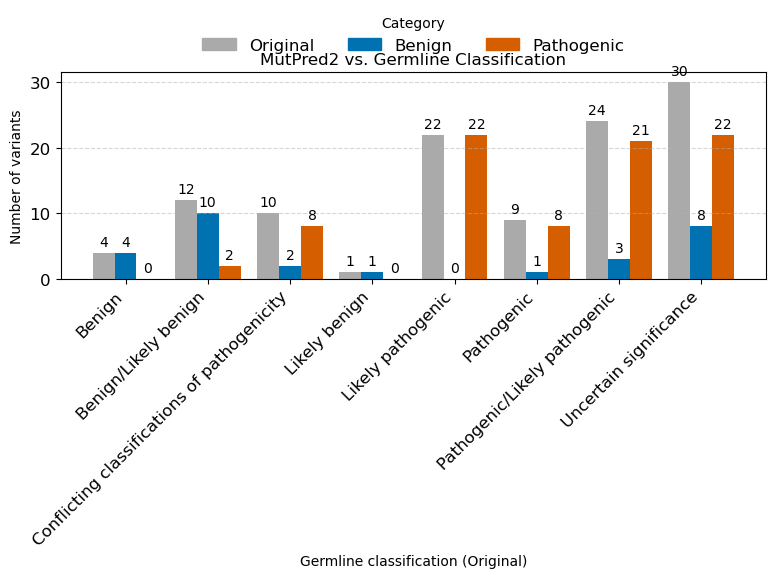

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

def plot_mutpred2_reclassification(
    df: pd.DataFrame,
    position_range=(1, 302),
    figsize=(10, 6),
    title_fontsize=16,
    label_fontsize=14,
    tick_fontsize=12,
    annotation_fontsize=10,
    bar_width_ratio=0.8,
    colors=None,
    title=None
):
    """
    Plot original Germline classification counts alongside MutPred2 reclassification.

    Parameters:
    - df: DataFrame with 'position', 'Germline classification', 'MutPred2_classification'
    - position_range: tuple(min, max) to filter 'position'
    - figsize: tuple(width, height) for figure
    - title_fontsize: fontsize for title
    - label_fontsize: fontsize for axis labels
    - tick_fontsize: fontsize for tick labels
    - annotation_fontsize: fontsize for bar annotations
    - bar_width_ratio: total group width fraction
    - colors: dict mapping 'Original', 'Benign', 'Pathogenic' to colors
    - title: optional plot title
    """
    # Filter and subset
    df = df[df['position'].between(*position_range)].copy()
    # Cross-tabulate
    cross = pd.crosstab(df['Germline classification'], df['MutPred2_classification'])
    original = df['Germline classification'].value_counts().reindex(cross.index)

    # Default colors
    if colors is None:
        colors = {
            'Original':   '#AAAAAA',
            'Benign':     '#0072B2',
            'Pathogenic': '#D55E00'
        }

    # Plot setup
    fig, ax = plt.subplots(figsize=figsize)
    plt.rcParams.update({'font.size': tick_fontsize})

    categories = ['Original', 'Benign', 'Pathogenic']
    n_groups = len(cross)
    n_bars = len(categories)
    total_width = bar_width_ratio
    bar_width = total_width / n_bars
    x = np.arange(n_groups)

    # Plot bars
    for i, cat in enumerate(categories):
        counts = original.values if cat == 'Original' else cross.get(cat, pd.Series(0, index=cross.index)).values
        offset = -total_width/2 + i * bar_width + bar_width/2
        positions = x + offset
        ax.bar(positions, counts, bar_width, color=colors[cat], label=cat)
        # Annotations
        for pos, cnt in zip(positions, counts):
            ax.text(pos, cnt + max(original.max(), cross.values.max())*0.02,
                    str(int(cnt)), ha='center', va='bottom', fontsize=annotation_fontsize)

    # Labels and title
    ax.set_xticks(x)
    ax.set_xticklabels(cross.index, rotation=45, ha='right', fontsize=tick_fontsize)
    ax.set_xlabel('Germline classification (Original)', fontsize=label_fontsize)
    ax.set_ylabel('Number of variants', fontsize=label_fontsize)
    ax.set_title(title or f'MutPred2 Reclassification vs. Original\n(Positions {position_range[0]}–{position_range[1]})',
                 fontsize=title_fontsize)

    # Legend above
    handles = [Patch(color=colors[c], label=c) for c in categories]
    ax.legend(handles=handles, title='Category',
              loc='lower center', bbox_to_anchor=(0.5, 1.02),
              ncol=len(handles), frameon=False, fontsize=tick_fontsize, title_fontsize=label_fontsize)

    ax.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# Example usage:
if __name__ == "__main__":
    # Load classified MutPred2 results
    path = "/project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/02_mutpred2/" \
           "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_classified_mutpred2.xlsx"
    df = pd.read_excel(path, engine="openpyxl")
    # Plot with custom styling
    plot_mutpred2_reclassification(
        df,
        position_range=(1, 302),
        figsize=(8, 6),
        title_fontsize=12,
        label_fontsize=10,
        tick_fontsize=12,
        annotation_fontsize=10,
        bar_width_ratio=0.8,
        title="MutPred2 vs. Germline Classification"
    )


In [4]:
import pandas as pd

def load_and_reclassify_polyphen(
    file_path: str,
    position_range: tuple[int, int] = (1, 302)
) -> pd.Series:
    """
    Load a PolyPhen-2 results table, restrict to a given position range,
    clean the predictions, and reclassify into two bins: Benign vs. Pathogenic.

    Parameters:
        file_path (str): Path to the Excel file with columns 'position' and 'prediction'.
        position_range (tuple[int, int]): (start, end) positions inclusive.

    Returns:
        pd.Series: Counts for each of the two new classes ('Benign', 'Pathogenic').
    """
    # 1) Load the Excel file into a DataFrame
    df = pd.read_excel(file_path)

    # 2) Restrict to the specified position range
    start, end = position_range
    df = df[df['position'].between(start, end)].copy()

    # 3) Normalize the original prediction strings
    df['prediction_clean'] = (
        df['prediction']
        .str.lower()
        .str.strip()
    )

    # 4) Map to two classes: Benign stays Benign, all others → Pathogenic
    df['pp2_binary'] = df['prediction_clean'].apply(
        lambda x: 'Benign' if x == 'benign' else 'Pathogenic'
    )

    # 5) Count the occurrences of each class
    counts = df['pp2_binary'].value_counts().reindex(
        ['Benign', 'Pathogenic'],
        fill_value=0
    )
    return counts

if __name__ == "__main__":
    # Path to your merged PolyPhen-2 output
    file_path = (
        "/project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/01_polyphen2/"
        "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_polyphen2.xlsx"
    )

    # Compute the reclassified counts within positions 1–302
    two_class_counts = load_and_reclassify_polyphen(file_path, position_range=(1, 302))

    # Print the results
    print("PolyPhen-2 reclassified counts within positions 1–302:")
    print(two_class_counts)


PolyPhen-2 reclassified counts within positions 1–302:
pp2_binary
Benign          7
Pathogenic    105
Name: count, dtype: int64


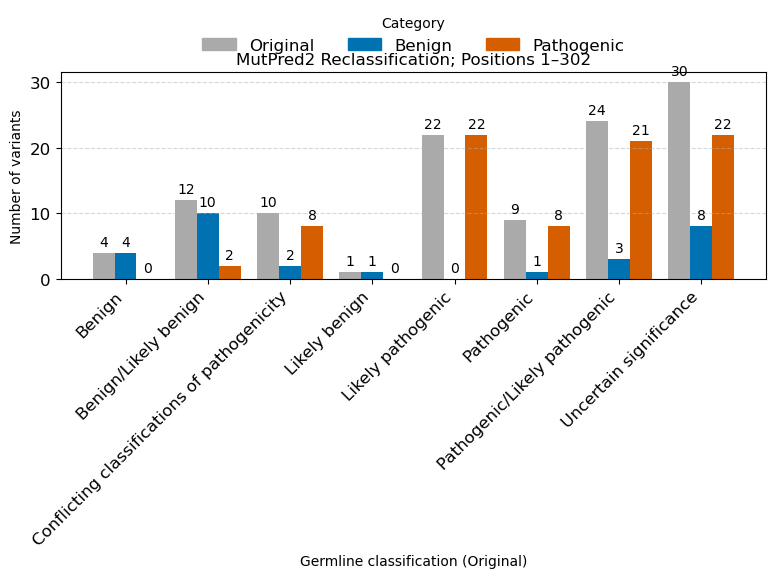


MutPred2 reclassified counts (Benign vs. Pathogenic) within positions 1–302:
mp2_binary
Benign        29
Pathogenic    83
Name: count, dtype: int64


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

def plot_mutpred2_reclassification(
    df: pd.DataFrame,
    position_range: tuple[int, int] = (1, 302),
    figsize: tuple[float, float] = (10, 6),
    title_fontsize: int = 16,
    label_fontsize: int = 14,
    tick_fontsize: int = 12,
    annotation_fontsize: int = 10,
    bar_width_ratio: float = 0.8,
    colors: dict | None = None,
    title: str | None = None
) -> pd.Series:
    """
    Plot original Germline classification counts alongside MutPred2 reclassification,
    and return the two‐class counts (Benign vs. Pathogenic).

    Parameters:
    - df: DataFrame with 'position', 'Germline classification', 'MutPred2_classification'
    - position_range: tuple(min, max) to filter 'position' (default 1–302)
    - figsize: (width, height) for the figure
    - title_fontsize: fontsize for title
    - label_fontsize: fontsize for axis labels
    - tick_fontsize: fontsize for tick labels
    - annotation_fontsize: fontsize for bar annotations
    - bar_width_ratio: total group width fraction
    - colors: dict mapping 'Original', 'Benign', 'Pathogenic' to colors
    - title: optional plot title

    Returns:
    - pd.Series: counts of 'Benign' and 'Pathogenic' after reclassification
    """
    # 1) Restrict to the specified position range (1–302 by default)
    start, end = position_range
    df = df[df['position'].between(start, end)].copy()

    # 2) Clean up the MutPred2_classification strings
    df['mp2_clean'] = df['MutPred2_classification'].str.lower().str.strip()

    # 3) Map to two classes: Benign stays Benign, everything else → Pathogenic
    df['mp2_binary'] = df['mp2_clean'].apply(
        lambda x: 'Benign' if x == 'benign' else 'Pathogenic'
    )

    # 4) Count the new binary classes
    binary_counts = df['mp2_binary'].value_counts().reindex(
        ['Benign', 'Pathogenic'],
        fill_value=0
    )

    # 5) Prepare the cross‐tab for the original vs. new classification plot
    cross = pd.crosstab(df['Germline classification'], df['mp2_binary'])
    original = df['Germline classification'].value_counts().reindex(cross.index)

    # Default colors
    if colors is None:
        colors = {
            'Original':   '#AAAAAA',
            'Benign':     '#0072B2',
            'Pathogenic': '#D55E00'
        }

    # Plot setup
    fig, ax = plt.subplots(figsize=figsize)
    plt.rcParams.update({'font.size': tick_fontsize})

    categories = ['Original', 'Benign', 'Pathogenic']
    n_groups = len(cross)
    total_width = bar_width_ratio
    bar_width = total_width / len(categories)
    x = np.arange(n_groups)

    # Plot bars + annotations
    for i, cat in enumerate(categories):
        counts = original.values if cat == 'Original' else cross.get(cat, pd.Series(0, index=cross.index)).values
        offset = -total_width/2 + i * bar_width + bar_width/2
        positions = x + offset
        ax.bar(positions, counts, bar_width, color=colors[cat], label=cat)
        for pos, cnt in zip(positions, counts):
            ax.text(pos, cnt + max(original.max(), cross.values.max())*0.02,
                    str(int(cnt)), ha='center', va='bottom',
                    fontsize=annotation_fontsize)

    # Labels and title
    ax.set_xticks(x)
    ax.set_xticklabels(cross.index, rotation=45, ha='right', fontsize=tick_fontsize)
    ax.set_xlabel('Germline classification (Original)', fontsize=label_fontsize)
    ax.set_ylabel('Number of variants', fontsize=label_fontsize)
    ax.set_title(
        title or f'MutPred2 Reclassification vs. Original (Positions {start}–{end})',
        fontsize=title_fontsize
    )

    # Legend above
    handles = [Patch(color=colors[c], label=c) for c in categories]
    ax.legend(handles=handles, title='Category',
              loc='lower center', bbox_to_anchor=(0.5, 1.02),
              ncol=len(handles), frameon=False,
              fontsize=tick_fontsize, title_fontsize=label_fontsize)

    ax.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    return binary_counts


if __name__ == "__main__":
    # Path to your merged MutPred2 output
    file_path = (
        "/project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/02_mutpred2/"
        "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_classified_mutpred2.xlsx"
    )

    # Plot and get two‐class counts within positions 1–302
    df = pd.read_excel(file_path, engine="openpyxl")
    counts = plot_mutpred2_reclassification(df, position_range=(1, 302),
                                            figsize=(8, 6),
                                            title_fontsize=12,
                                            label_fontsize=10,
                                            tick_fontsize=12,
                                            annotation_fontsize=10,
                                            bar_width_ratio=0.8,
                                            title="MutPred2 Reclassification; Positions 1–302")

    # Print the reclassified counts
    print("\nMutPred2 reclassified counts (Benign vs. Pathogenic) within positions 1–302:")
    print(counts)


# 03 ESM

## 3.1 Run ESM under haddock3_env which has py3.11

In [ ]:
#!/usr/bin/env python
import os
import requests
import torch
import esm
import pandas as pd
import torch.nn.functional as F

# 1) Paths
DATA_XLSX     = "/project/ealexov/compbio/shamrat/250519_energy/00_data/01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg.xlsx"
OUTPUT_XLSX   = "/project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/03_esm/cdkl5_esm1v_clinvar_scores.xlsx"

# 2) Load your ClinVar/1KGP dataset
df = pd.read_excel(DATA_XLSX, engine="openpyxl")

# Keep only rows with non-null mutation info
df = df.loc[df['wild'].notna() & df['position'].notna() & df['mutant'].notna(), 
            ['wild','position','mutant']].drop_duplicates()

# Build a standard mutation string: e.g. I3F
df['mutation'] = df['wild'].str.upper() + df['position'].astype(int).astype(str) + df['mutant'].str.upper()
df = df.sort_values('position')

# 3) Fetch wild-type CDKL5 sequence from UniProt
resp = requests.get("https://rest.uniprot.org/uniprot/O76039.fasta")
resp.raise_for_status()
wt_seq = "".join(resp.text.splitlines()[1:]).strip()

# 4) Load the zero-shot variant model (ESM-1v)
device = torch.device('cpu')
model, alphabet = esm.pretrained.esm1v_t33_650M_UR90S_1()
model = model.eval().to(device)
batch_converter = alphabet.get_batch_converter()

def score_sequence(seq: str) -> float:
    """Return sum of per-residue log-probabilities under ESM-1v."""
    _, _, tokens = batch_converter([("cdkl5", seq)])
    tokens = tokens.to(device)
    with torch.no_grad():
        logits = model(tokens)["logits"][0, 1:len(seq)+1]
        logprobs = F.log_softmax(logits, dim=-1)
        aa_idxs = torch.tensor([alphabet.get_idx(a) for a in seq], device=device)
        return logprobs[torch.arange(len(seq)), aa_idxs].sum().item()

# 5) Compute wild-type score once
wt_score = score_sequence(wt_seq)

# 6) Loop over each variant
results = []
for _, row in df.iterrows():
    pos    = int(row['position'])
    wt_aa  = row['wild'].upper()
    mut_aa = row['mutant'].upper()
    mut_id = row['mutation']
    # sanity check
    assert wt_seq[pos-1] == wt_aa, f"WT mismatch at {pos}: found {wt_seq[pos-1]} vs expected {wt_aa}"
    # build the mutant sequence
    mut_seq = wt_seq[:pos-1] + mut_aa + wt_seq[pos:]
    mut_score = score_sequence(mut_seq)
    results.append({
        "mutation":    mut_id,
        "position":    pos,
        "wt_aa":       wt_aa,
        "mut_aa":      mut_aa,
        "wt_score":    wt_score,
        "mut_score":   mut_score,
        "delta_score": mut_score - wt_score
    })

# 7) Save to Excel
out_df = pd.DataFrame(results).sort_values('position')
out_df.to_excel(OUTPUT_XLSX, index=False)

print(f"✅ Written results to {OUTPUT_XLSX}")


## === 3.2 Merge ESM-1v Δscore into your CDKL5 variants and save ===

In [53]:
# 3 use esm code for esm prediction this need py11 version and 'haddock3_env' has python11 version
# the code is loaded in '03_esm/score_cdkl5_variants.py'



# === 3.2 Merge ESM-1v Δscore into your CDKL5 variants and save ===

import pandas as pd
import os

# 1) Paths to your original variants and the ESM results
variants_xlsx = "/project/ealexov/compbio/shamrat/250519_energy/00_data/" \
                "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg.xlsx"
esm_folder    = "/project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/03_esm"
esm_results   = os.path.join(esm_folder, "cdkl5_esm1v_scores.xlsx")

# 2) Read in both tables
variants_df = pd.read_excel(variants_xlsx, engine="openpyxl")
esm_df      = pd.read_excel(esm_results,    engine="openpyxl")

# 3) Merge on the mutation string ('mutation' in variants ↔ 'mutation' in esm_df)
merged = variants_df.merge(
    esm_df,
    on="mutation",
    how="left"
)

# 4) Write out a new Excel with “_esm1v” appended
base = os.path.splitext(os.path.basename(variants_xlsx))[0]
out_path = os.path.join(
    esm_folder,
    f"{base}_esm1v.xlsx"
)
merged.to_excel(out_path, index=False)
print(f"Wrote merged ESM-1v annotations to {out_path}")



Wrote merged ESM-1v annotations to /project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/03_esm/01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_esm1v.xlsx


## See the important columns

In [54]:
import pandas as pd

# Path to the merged ESM-1v annotations you just wrote
file_path = (
    "/project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/03_esm/"
    "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_esm1v.xlsx"
)

# Load into a DataFrame
df = pd.read_excel(file_path, engine="openpyxl")

# Print only the column names
print("Columns in merged ESM-1v results:")
print(df.columns.tolist())


Columns in merged ESM-1v results:
['Name', 'Gene(s)', 'Protein change', 'mutation', 'wild', 'position_x', 'mutant', 'Allele Frequency', 'Condition(s)', 'Accession', 'GRCh37Chromosome', 'GRCh37Location', 'GRCh38Chromosome', 'GRCh38Location', 'VariationID', 'AlleleID(s)', 'dbSNP ID', 'Canonical SPDI', 'Variant type', 'Molecular consequence', 'Germline classification', 'Source', 'Germline date last evaluated', 'Germline review status', 'wild_score', 'mut_score', 'delta_score', 'position_y']


In [55]:
import pandas as pd
from IPython.display import display

# Adjust this to your actual file name:
file_path = (
    "/project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/03_esm/"
    "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_esm1v.xlsx"
)

df = pd.read_excel(file_path, engine="openpyxl")

cols_to_display = [
    "mutation",
    "position_x",  # original position from variants
    "Germline classification",
    "wild_score",
    "mut_score",
    "delta_score"
]

print("Displayed columns:")
print(cols_to_display, "\n")

display(df[cols_to_display].head())


Displayed columns:
['mutation', 'position_x', 'Germline classification', 'wild_score', 'mut_score', 'delta_score'] 



,mutation,position_x,Germline classification,wild_score,mut_score,delta_score
0,I3F,3,Benign,-273.480652,-274.565460,-1.084808
1,N5D,5,Benign,-273.480652,-278.556641,-5.075989
2,F13S,13,Likely pathogenic,-273.480652,-283.678680,-10.198029
3,G20R,20,Pathogenic,-273.480652,-282.508423,-9.027771
4,G20V,20,Pathogenic,-273.480652,-288.576172,-15.095520


In [ ]:
## overview of the esm1v scores

In [57]:
import pandas as pd
from IPython.display import display

# Path to your merged ESM-1v annotations file
file_path = (
    "/project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/03_esm/"
    "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_esm1v.xlsx"
)

# Load it
df = pd.read_excel(file_path, engine="openpyxl")

# 1) Preview the first five rows of the key score columns
print("Head of ESM-1v scores:")
display(df[["mutation", "position_x", "wild_score", "mut_score", "delta_score"]].head())

# 2) Show summary statistics for those scores
print("\nSummary statistics for ESM-1v scores:")
display(df[["wild_score", "mut_score", "delta_score"]].describe())


Head of ESM-1v scores:


,mutation,position_x,wild_score,mut_score,delta_score
0,I3F,3,-273.480652,-274.565460,-1.084808
1,N5D,5,-273.480652,-278.556641,-5.075989
2,F13S,13,-273.480652,-283.678680,-10.198029
3,G20R,20,-273.480652,-282.508423,-9.027771
4,G20V,20,-273.480652,-288.576172,-15.095520



Summary statistics for ESM-1v scores:


,wild_score,mut_score,delta_score
count,156.000000,156.000000,156.000000
mean,-273.480652,-280.411024,-6.930372
std,0.000000,5.414785,5.414785
min,-273.480652,-291.536926,-18.056274
25%,-273.480652,-284.651039,-11.170387
50%,-273.480652,-281.149628,-7.668976
75%,-273.480652,-274.530075,-1.049423
max,-273.480652,-270.864868,2.615784


In [ ]:
## esm1v classification

In [58]:
import pandas as pd
import os

# --- Configuration: update infile name if needed ---
esm_folder = "/project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/03_esm"
# Input filename (must match your merged ESM-1v output)
infile = "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_esm1v.xlsx"
# Output filename with 'classified' inserted before 'esm1v'
outfile = "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_classified_esm1v.xlsx"

in_path = os.path.join(esm_folder, infile)
out_path = os.path.join(esm_folder, outfile)

# 1) Load merged ESM-1v results
df = pd.read_excel(in_path, engine="openpyxl")

# 2) Classify based on delta_score: negative → Pathogenic, else Benign
df['ESM1v_classification'] = df['delta_score'].apply(
    lambda x: 'Pathogenic' if x < 0 else 'Benign'
)

# 3) Save updated DataFrame
df.to_excel(out_path, index=False)
print(f"Wrote classified ESM-1v results to:\n  {out_path}")

# 4) Preview the first five rows with classification
from IPython.display import display
preview_cols = ['mutation', 'position_x', 'delta_score', 'ESM1v_classification']
print("Preview of classified ESM-1v results:")
display(df[preview_cols].head())


Wrote classified ESM-1v results to:
  /project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/03_esm/01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_classified_esm1v.xlsx
Preview of classified ESM-1v results:


,mutation,position_x,delta_score,ESM1v_classification
0,I3F,3,-1.084808,Pathogenic
1,N5D,5,-5.075989,Pathogenic
2,F13S,13,-10.198029,Pathogenic
3,G20R,20,-9.027771,Pathogenic
4,G20V,20,-15.095520,Pathogenic


In [ ]:
## esm1v reclassification plot

In [62]:
import pandas as pd
from IPython.display import display

# 1) Load the classified ESM-1v results
file_path = (
    "/project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/03_esm/"
    "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_classified_esm1v.xlsx"
)
df = pd.read_excel(file_path, engine="openpyxl")

# 2) Restrict to positions 1–302
df = df[df['position_x'].between(1, 302)]

# 3) Cross-tab: counts with totals
cross_counts = pd.crosstab(
    df['Germline classification'],
    df['ESM1v_classification'],
    margins=True,
    margins_name='Total'
)

# 4) Cross-tab: row-wise percentages (excluding Total column)
cross_pct = cross_counts.div(cross_counts['Total'], axis=0).round(2).drop(columns='Total')

# 5) Display
print("Counts:\n")
display(cross_counts)

print("\nPercentages:\n")
display(cross_pct)


Counts:



ESM1v_classification,Benign,Pathogenic,Total
Germline classification,,,
Benign,0,4,4
Benign/Likely benign,2,10,12
Conflicting classifications of pathogenicity,0,10,10
Likely benign,0,1,1
Likely pathogenic,0,22,22
Pathogenic,0,9,9
Pathogenic/Likely pathogenic,0,24,24
Uncertain significance,0,30,30
Total,2,110,112



Percentages:



ESM1v_classification,Benign,Pathogenic
Germline classification,,
Benign,0.00,1.00
Benign/Likely benign,0.17,0.83
Conflicting classifications of pathogenicity,0.00,1.00
Likely benign,0.00,1.00
Likely pathogenic,0.00,1.00
Pathogenic,0.00,1.00
Pathogenic/Likely pathogenic,0.00,1.00
Uncertain significance,0.00,1.00
Total,0.02,0.98


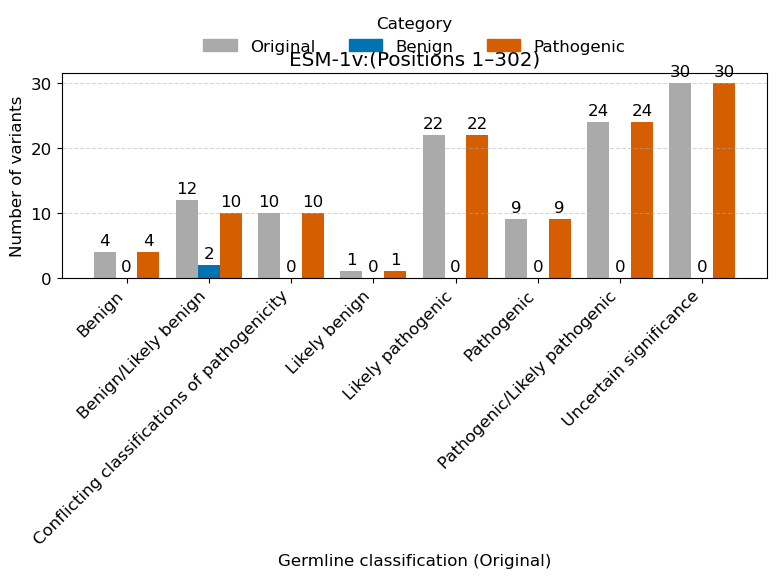

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Load ESM-1v classified results
file_path = (
    "/project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/03_esm/"
    "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_classified_esm1v.xlsx"
)
df = pd.read_excel(file_path, engine="openpyxl")

# Filter to positions 1–302
df = df[df['position_x'].between(1, 302)]

# Cross-tabulate: Germline vs ESM1v_classification
cross = pd.crosstab(df['Germline classification'], df['ESM1v_classification'])

# Original counts
original = df['Germline classification'].value_counts().reindex(cross.index)

# Define categories and colors
categories = ['Original', 'Benign', 'Pathogenic']
colors = {
    'Original':   '#AAAAAA',
    'Benign':     '#0072B2',
    'Pathogenic': '#D55E00'
}

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
n_groups = len(cross)
n_bars = len(categories)
total_width = 0.8
bar_width = total_width / n_bars
x = np.arange(n_groups)

for i, cat in enumerate(categories):
    if cat == 'Original':
        counts = original.values
    else:
        counts = cross.get(cat, pd.Series(0, index=cross.index)).values
    offset = -total_width/2 + i * bar_width + bar_width/2
    positions = x + offset
    ax.bar(positions, counts, bar_width, color=colors[cat], label=cat)
    for pos, cnt in zip(positions, counts):
        ax.text(pos, cnt + max(original.max(), cross.values.max())*0.02,
                str(int(cnt)), ha='center', va='bottom')

# Labels and title
ax.set_xticks(x)
ax.set_xticklabels(cross.index, rotation=45, ha='right')
ax.set_xlabel('Germline classification (Original)')
ax.set_ylabel('Number of variants')
ax.set_title('ESM-1v:(Positions 1–302)')

# Legend above
handles = [Patch(color=colors[c], label=c) for c in categories]
ax.legend(handles=handles, title='Category',
          loc='lower center', bbox_to_anchor=(0.5, 1.02),
          ncol=len(handles), frameon=False)

ax.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [7]:
#!/usr/bin/env python3
import pandas as pd

# 1. Load your merged ESM-1v results
IN_XLSX = (
    "/project/ealexov/compbio/shamrat/250519_energy/"
    "05_pathogenicity/03_esm/"
    "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_esm1v.xlsx"
)
df = pd.read_excel(IN_XLSX, engine="openpyxl")

# 2. Define the Capan et al. threshold
THRESHOLD = -10.19

# 3. Classify each variant
df['ESM1v_classification'] = df['delta_score'].apply(
    lambda x: 'Pathogenic' if x < THRESHOLD else 'Benign'
)

# 4. Quick summary of counts
counts = df['ESM1v_classification'].value_counts().rename_axis('Class').reset_index(name='Count')
print("ESM-1 V classification counts (threshold = –10.19):")
print(counts.to_string(index=False))

# 5. (Optional) Cross-tab against Germline classification
cross = pd.crosstab(df['Germline classification'], df['ESM1v_classification'])
print("\nAgreement with Germline (ClinVar) labels:")
print(cross.to_string())

# 6. (Optional) Save an annotated file
OUT_XLSX = IN_XLSX.replace(".xlsx", "_thresholded.xlsx")
df.to_excel(OUT_XLSX, index=False)
print(f"\nAnnotated file written to: {OUT_XLSX}")


ESM-1 V classification counts (threshold = –10.19):
     Class  Count
    Benign     98
Pathogenic     58

Agreement with Germline (ClinVar) labels:
ESM1v_classification                          Benign  Pathogenic
Germline classification                                         
Benign                                            20           0
Benign/Likely benign                              14           1
Conflicting classifications of pathogenicity       9           4
Likely benign                                     10           0
Likely pathogenic                                  9          13
Pathogenic                                         4           5
Pathogenic/Likely pathogenic                      10          14
Uncertain significance                            22          21

Annotated file written to: /project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/03_esm/01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_esm1v_thresholded.xlsx


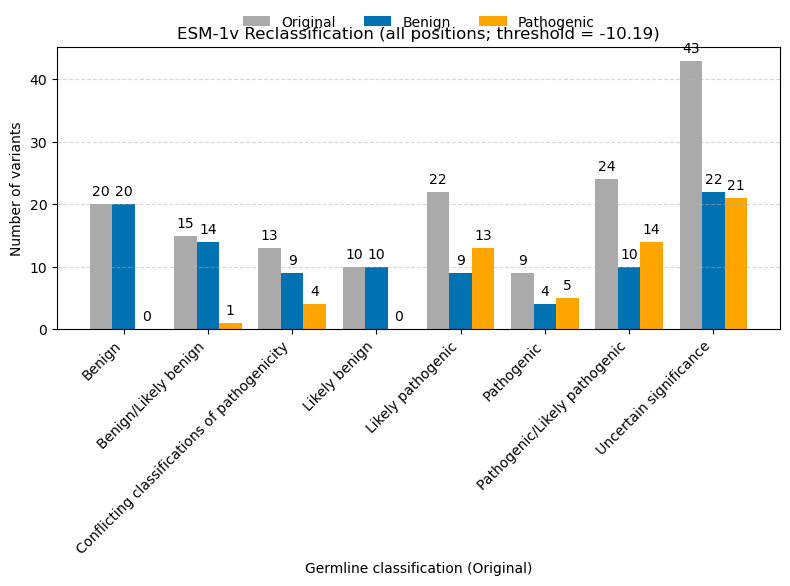

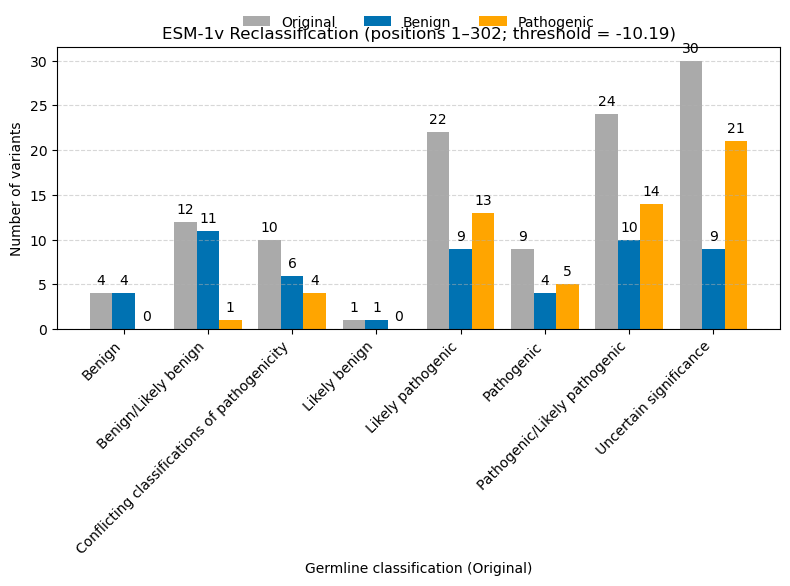

In [10]:
#!/usr/bin/env python3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ─── 0. Path to your merged ESM-1v Excel ───────────────────────────────────
IN_XLSX = (
    "/project/ealexov/compbio/shamrat/250519_energy/"
    "05_pathogenicity/03_esm/"
    "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_esm1v.xlsx"
)

# ─── 1. Load the data ────────────────────────────────────────────────────────
df = pd.read_excel(IN_XLSX, engine="openpyxl")

# ─── 2. Apply the Capan et al. threshold (Δscore < -10.19 → Pathogenic) ─────
threshold = -10.19
df['ESM1v_classification'] = df['delta_score'].apply(
    lambda x: 'Pathogenic' if x < threshold else 'Benign'
)

# ─── Helper for position column ─────────────────────────────────────────────
pos_col = 'position_x' if 'position_x' in df.columns else 'position'

# ─── Build cross-tabs ────────────────────────────────────────────────────────
cross_all = pd.crosstab(df['Germline classification'], df['ESM1v_classification'])
orig_all  = df['Germline classification'].value_counts().reindex(cross_all.index)

df_302    = df[df[pos_col].between(1, 302)]
cross_302 = pd.crosstab(df_302['Germline classification'], df_302['ESM1v_classification'])
orig_302  = df_302['Germline classification'].value_counts().reindex(cross_302.index)

# ─── Color settings ─────────────────────────────────────────────────────────
colors = {
    'Original':   '#AAAAAA',      # grey
    'Benign':     '#0072B2',      # blue
    'Pathogenic': 'orange'
}

def plot_reclass(cross, original, title):
    categories = ['Original', 'Benign', 'Pathogenic']
    total_w    = 0.8
    bar_w      = total_w / len(categories)
    x          = np.arange(len(cross))
    ymax       = max(original.max(), cross.values.max())

    fig, ax = plt.subplots(figsize=(8,6))
    for i, cat in enumerate(categories):
        counts = original.values if cat == 'Original' else cross.get(cat, pd.Series(0, index=cross.index)).values
        offset = -total_w/2 + i*bar_w + bar_w/2
        pos    = x + offset
        ax.bar(pos, counts, bar_w, color=colors[cat], label=cat)
        for p, c in zip(pos, counts):
            ax.text(p, c + ymax*0.02, str(int(c)), ha='center', va='bottom')

    ax.set_xticks(x)
    ax.set_xticklabels(cross.index, rotation=45, ha='right')
    ax.set_xlabel('Germline classification (Original)')
    ax.set_ylabel('Number of variants')
    ax.set_title(title)
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1.02),
              ncol=len(categories), frameon=False)
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# ─── Plot: all positions ─────────────────────────────────────────────────────
plot_reclass(
    cross_all, orig_all,
    f'ESM-1v Reclassification (all positions; threshold = {threshold})'
)

# ─── Plot: positions 1–302 ───────────────────────────────────────────────────
plot_reclass(
    cross_302, orig_302,
    f'ESM-1v Reclassification (positions 1–302; threshold = {threshold})'
)


## find an ROC like capan2025

Simplified ESM-1v Reclassification Workflow

1. Score Interpretation
   - Each variant has a Δscore from ESM-1v: how much the model’s log-probability drops when we introduce the mutation.
   - More negative Δscore ⇒ larger drop ⇒ more likely harmful.
   - We define roc_score = –Δscore so that higher roc_score means more likely pathogenic.

2. Choosing a Cutoff
   - We test these candidate thresholds on your 29 known variants:
     thresholds = [∞, 15.096, 6.152, –0.904]
   - For each threshold, we label a variant “Pathogenic” if roc_score ≥ threshold, otherwise “Benign.”
   - We then count:
     • True Positive Rate (TPR) = fraction of real pathogenic variants correctly called.
     • False Positive Rate (FPR) = fraction of real benign variants incorrectly flagged.

3. Results Table

   Cutoff   | Called “Pathogenic”                        | TPR          | FPR
   -------------------------------------------------------------------------
   ∞        | None                                        | 0/9 = 0.00   | 0/20 = 0.00
   15.096   | Only the one with roc_score = 15.096        | 1/9 ≈ 0.11   | 0/20 = 0.00
   6.152    | All with roc_score ≥ 6.152 (7 variants)     | 9/9 = 1.00   | 0/20 = 0.00
   –0.904   | Every variant                              | 9/9 = 1.00   | 20/20 = 1.00

4. Selecting the Best Threshold
   - We want high TPR and low FPR.
   - Threshold 6.152 gives TPR = 100% and FPR = 0%, so we choose Δscore = –6.152 as the cutoff.

5. Applying the Rule to New Variants

   if delta_score < -6.152:
       classification = "Pathogenic"
   else:
       classification = "Benign"

   - This rule perfectly separates your known benign and pathogenic variants and can be applied to classify new or uncertain CDKL5 variants.


Total variants: 29  (Benign=20, Pathogenic=9)

AUC: 1.000
Optimal threshold details:
  Inverted Δscore cutoff: 6.152
  Sensitivity (TPR):      1.000
  Specificity:            1.000
  False positive rate:    0.000
  True positive rate:     1.000

Confusion matrix at optimal threshold:
  True Negatives: 20
  False Positives:0
  False Negatives:0
  True Positives: 9



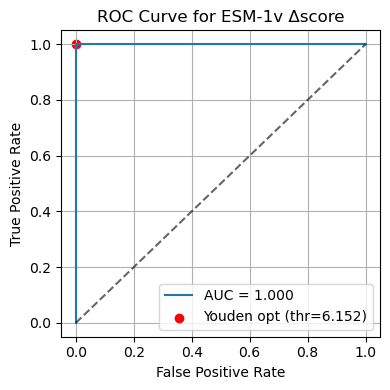

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix

# ─── 1. Load and filter data ─────────────────────────────────────────────────
IN_XLSX = (
    "/project/ealexov/compbio/shamrat/250519_energy/"
    "05_pathogenicity/03_esm/"
    "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_esm1v.xlsx"
)
df = pd.read_excel(IN_XLSX, engine="openpyxl")
df = df[df['Germline classification'].isin(['Benign', 'Pathogenic'])].copy()

# ─── 2. Map true labels and compute scores ───────────────────────────────────
df['true_label'] = df['Germline classification'].map({'Benign': 0, 'Pathogenic': 1})
scores = -df['delta_score'].values  # invert so higher = more pathogenic
labels = df['true_label'].values

# ─── 3. Basic data summary ───────────────────────────────────────────────────
n_benign = (labels == 0).sum()
n_path   = (labels == 1).sum()
print(f"Total variants: {len(df)}  (Benign={n_benign}, Pathogenic={n_path})\n")

# ─── 4. ROC curve and AUC ────────────────────────────────────────────────────
fpr, tpr, thresholds = roc_curve(labels, scores)
roc_auc = auc(fpr, tpr)
print(f"AUC: {roc_auc:.3f}")

# ─── 5. Youden's J optimal threshold ─────────────────────────────────────────
youden_j        = tpr - fpr
opt_idx         = np.argmax(youden_j)
opt_threshold   = thresholds[opt_idx]
opt_sensitivity = tpr[opt_idx]
opt_specificity = 1 - fpr[opt_idx]
opt_fpr         = fpr[opt_idx]
opt_tpr         = tpr[opt_idx]

print("Optimal threshold details:")
print(f"  Inverted Δscore cutoff: {opt_threshold:.3f}")
print(f"  Sensitivity (TPR):      {opt_sensitivity:.3f}")
print(f"  Specificity:            {opt_specificity:.3f}")
print(f"  False positive rate:    {opt_fpr:.3f}")
print(f"  True positive rate:     {opt_tpr:.3f}\n")

# ─── 6. Confusion matrix at optimal threshold ────────────────────────────────
preds = (scores >= opt_threshold).astype(int)
tn, fp, fn, tp = confusion_matrix(labels, preds).ravel()
print("Confusion matrix at optimal threshold:")
print(f"  True Negatives: {tn}")
print(f"  False Positives:{fp}")
print(f"  False Negatives:{fn}")
print(f"  True Positives: {tp}\n")

# ─── 7. Plot ROC Curve and mark optimal point ───────────────────────────────
plt.figure(figsize=(4,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], 'k--', alpha=0.6)
plt.scatter(opt_fpr, opt_tpr, color='red',
            label=f"Youden opt (thr={opt_threshold:.3f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for ESM-1v Δscore")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


In [14]:
import pandas as pd

# ─── 0. Paths ────────────────────────────────────────────────────────────────
IN_XLSX = (
    "/project/ealexov/compbio/shamrat/250519_energy/"
    "05_pathogenicity/03_esm/"
    "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_esm1v.xlsx"
)
OUT_XLSX = (
    "/project/ealexov/compbio/shamrat/250519_energy/"
    "05_pathogenicity/03_esm/"
    "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_classified_custom_esm1v.xlsx"
)

# ─── 1. Load merged ESM-1v Δscore table ────────────────────────────────────
df = pd.read_excel(IN_XLSX, engine="openpyxl")

# ─── 2. Apply your empirically-derived threshold (Δscore < -6.152 → Pathogenic)
threshold = -6.152
df['ESM1v_classification_custom'] = df['delta_score'].apply(
    lambda x: 'Pathogenic' if x < threshold else 'Benign'
)

# ─── 3. Summary counts ───────────────────────────────────────────────────────
counts = df['ESM1v_classification_custom'].value_counts().rename_axis('Class').reset_index(name='Count')
print("Custom ESM-1v classification counts:")
print(counts.to_string(index=False))

# ─── 4. Save out annotated Excel ─────────────────────────────────────────────
df.to_excel(OUT_XLSX, index=False)
print(f"\nWrote custom-classified ESM-1v table to:\n  {OUT_XLSX}")


Custom ESM-1v classification counts:
     Class  Count
Pathogenic     88
    Benign     68

Wrote custom-classified ESM-1v table to:
  /project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/03_esm/01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_classified_custom_esm1v.xlsx


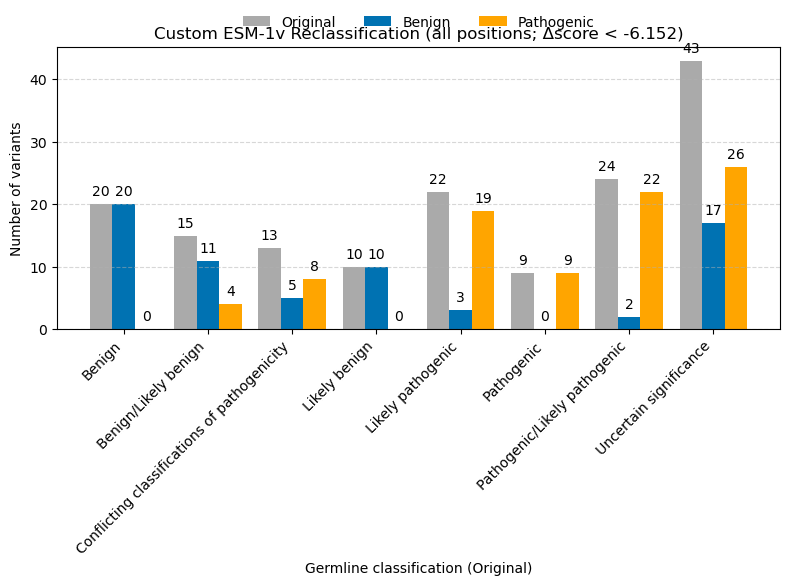

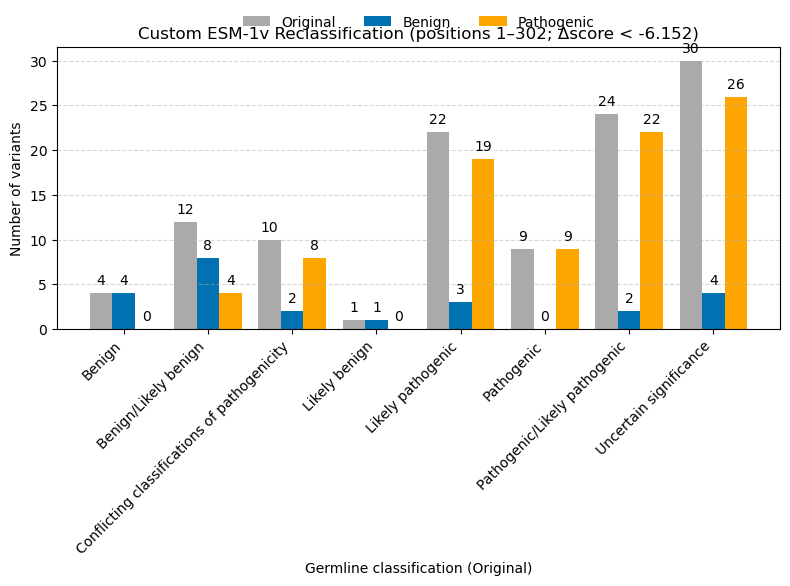

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ─── 0. Path to your merged ESM-1v Δscore Excel ─────────────────────────────
IN_XLSX = (
    "/project/ealexov/compbio/shamrat/250519_energy/"
    "05_pathogenicity/03_esm/"
    "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_esm1v.xlsx"
)

# ─── 1. Load data and apply custom threshold ────────────────────────────────
df = pd.read_excel(IN_XLSX, engine="openpyxl")
threshold = -6.152
df['ESM1v_classification_custom'] = df['delta_score'].apply(
    lambda x: 'Pathogenic' if x < threshold else 'Benign'
)

# ─── Helper for position column ─────────────────────────────────────────────
pos_col = 'position_x' if 'position_x' in df.columns else 'position'

# ─── Prepare cross-tabs ─────────────────────────────────────────────────────
# All positions
cross_all = pd.crosstab(df['Germline classification'], df['ESM1v_classification_custom'])
orig_all  = df['Germline classification'].value_counts().reindex(cross_all.index)

# Positions 1–302
df_302    = df[df[pos_col].between(1, 302)]
cross_302 = pd.crosstab(df_302['Germline classification'], df_302['ESM1v_classification_custom'])
orig_302  = df_302['Germline classification'].value_counts().reindex(cross_302.index)

# ─── Color settings ─────────────────────────────────────────────────────────
colors = {
    'Original':   '#AAAAAA',
    'Benign':     '#0072B2',
    'Pathogenic': 'orange'
}

def plot_reclassification(cross, original, title):
    categories = ['Original', 'Benign', 'Pathogenic']
    total_w    = 0.8
    bar_w      = total_w / len(categories)
    x          = np.arange(len(cross))
    ymax       = max(original.max(), cross.values.max())

    fig, ax = plt.subplots(figsize=(8, 6))
    for i, cat in enumerate(categories):
        counts = original.values if cat == 'Original' else cross.get(cat, pd.Series(0, index=cross.index)).values
        offset = -total_w/2 + i * bar_w + bar_w/2
        pos    = x + offset
        ax.bar(pos, counts, bar_w, color=colors[cat], label=cat)
        for p, c in zip(pos, counts):
            ax.text(p, c + ymax*0.02, str(int(c)), ha='center', va='bottom')

    ax.set_xticks(x)
    ax.set_xticklabels(cross.index, rotation=45, ha='right')
    ax.set_xlabel('Germline classification (Original)')
    ax.set_ylabel('Number of variants')
    ax.set_title(title)
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1.02),
              ncol=len(categories), frameon=False)
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# ─── Plot 1: all positions ───────────────────────────────────────────────────
plot_reclassification(
    cross_all, orig_all,
    f'Custom ESM-1v Reclassification (all positions; Δscore < {threshold})'
)

# ─── Plot 2: positions 1–302 ─────────────────────────────────────────────────
plot_reclassification(
    cross_302, orig_302,
    f'Custom ESM-1v Reclassification (positions 1–302; Δscore < {threshold})'
)


In [19]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve

# ─── 0. Load your merged ESM-1v results ─────────────────────────────────────────
IN_XLSX = (
    "/project/ealexov/compbio/shamrat/250519_energy/"
    "05_pathogenicity/03_esm/"
    "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_esm1v.xlsx"
)
df = pd.read_excel(IN_XLSX, engine="openpyxl")

# ─── 1. Filter to Benign/Pathogenic and map to binary labels ───────────────────
df = df[df['Germline classification'].isin(['Benign', 'Pathogenic'])].copy()
labels = df['Germline classification'].map({'Benign': 0, 'Pathogenic': 1}).values

# ─── 2. Extract Δscores and invert for ROC ─────────────────────────────────────
delta_scores = df['delta_score'].values
roc_scores = -delta_scores

# ─── 3. Compute ROC curve ──────────────────────────────────────────────────────
fpr, tpr, thresholds = roc_curve(labels, roc_scores)

# ─── 4. Print arrays so you can paste them back ────────────────────────────────
print("delta_scores =", np.round(delta_scores, 3).tolist())
print("roc_scores   =", np.round(roc_scores, 3).tolist())
print("thresholds   =", np.round(thresholds, 3).tolist())
print("fpr          =", np.round(fpr, 3).tolist())
print("tpr          =", np.round(tpr, 3).tolist())


delta_scores = [-1.085, -5.076, -9.028, -15.096, -6.673, -6.152, -8.001, -11.292, -10.646, -13.567, -14.875, -1.01, -3.107, 0.216, -0.209, -3.286, -0.363, -0.945, 0.904, -0.182, -2.743, -0.28, 0.613, 0.064, 0.624, -0.881, -5.23, -2.318, -0.418]
roc_scores   = [1.085, 5.076, 9.028, 15.096, 6.673, 6.152, 8.001, 11.292, 10.646, 13.567, 14.875, 1.01, 3.107, -0.216, 0.209, 3.286, 0.363, 0.945, -0.904, 0.182, 2.743, 0.28, -0.613, -0.064, -0.624, 0.881, 5.23, 2.318, 0.418]
thresholds   = [inf, 15.096, 6.152, -0.904]
fpr          = [0.0, 0.0, 0.0, 1.0]
tpr          = [0.0, 0.111, 1.0, 1.0]


In [ ]:
We start with the 29 CDKL5 variants, each having an ESM-1v delta_score:
[-1.085, -5.076, -9.028, -15.096, -6.673, -6.152, -8.001, -11.292,
 -10.646, -13.567, -14.875, -1.01, -3.107, 0.216, -0.209, -3.286,
 -0.363, -0.945, 0.904, -0.182, -2.743, -0.28, 0.613, 0.064, 0.624,
 -0.881, -5.23, -2.318, -0.418]

1. We invert these to obtain roc_scores = –delta_score:
[1.085, 5.076, 9.028, 15.096, 6.673, 6.152, 8.001, 11.292,
 10.646, 13.567, 14.875, 1.01, 3.107, -0.216, 0.209, 3.286,
 0.363, 0.945, -0.904, 0.182, 2.743, 0.28, -0.613, -0.064, -0.624,
 0.881, 5.23, 2.318, 0.418]

2. We run an ROC analysis (labels = 0 for Benign, 1 for Pathogenic) and get:
   thresholds = [∞,   15.096, 6.152, -0.904]
   fpr        = [0.0,   0.0,   0.0,   1.0]
   tpr        = [0.0, 0.111,   1.0,   1.0]

3. We compute Youden’s J = tpr – fpr for each threshold and find it is maximized at:
   threshold = 6.152  (i.e. delta_score = –6.152)
   → TPR = 1.00 (we catch all 9 known pathogenic)
   → FPR = 0.00 (we flag no benign)

4. Therefore our classification rule becomes:
   if delta_score < -6.152:
       classification = "Pathogenic"
   else:
       classification = "Benign"

5. We can now apply this same rule to any new CDKL5 variant: compute its delta_score, compare to –6.152,
and assign a “Benign” or “Pathogenic” label.


In [7]:
#!/usr/bin/env python3
import pandas as pd

# ─── 0. Path to your merged ESM-1v Δscore Excel ─────────────────────────────
IN_XLSX = (
    "/project/ealexov/compbio/shamrat/250519_energy/"
    "05_pathogenicity/03_esm/"
    "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_esm1v.xlsx"
)

# ─── 1. Load data and apply custom threshold ────────────────────────────────
df = pd.read_excel(IN_XLSX, engine="openpyxl")
threshold = -6.152
df['ESM1v_classification_custom'] = df['delta_score'].apply(
    lambda x: 'Pathogenic' if x < threshold else 'Benign'
)

# ─── 2. Identify the correct position column ────────────────────────────────
pos_col = 'position_x' if 'position_x' in df.columns else 'position'

# ─── 3. Subset to positions 1–302 ────────────────────────────────────────────
df_302 = df[df[pos_col].between(1, 302)]

# ─── 4. Compute counts for the two classes within 1–302 ─────────────────────
counts_302 = (
    df_302['ESM1v_classification_custom']
    .value_counts()
    .reindex(['Benign', 'Pathogenic'], fill_value=0)
)

# ─── 5. Print the results ───────────────────────────────────────────────────
print(f"Custom ESM-1v counts (Δscore < {threshold}) within positions 1–302:")
print(counts_302)


Custom ESM-1v counts (Δscore < -6.152) within positions 1–302:
ESM1v_classification_custom
Benign        24
Pathogenic    88
Name: count, dtype: int64


# 08 Alphamissense

In [6]:
import pandas as pd

# Corrected file path variable name
alphamissense = '/project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/08_alphamissense/AF-O76039-F1-hg38.csv'

# Use read_csv instead of read_excel since it's a .csv file
df = pd.read_csv(alphamissense)

# Display the first 5 rows
print(df.head())


  CHROM       POS REF ALT genome uniprot_id      transcript_id  \
0  chrX  18507100   A   C   hg38     O76039  ENST00000623535.2   
1  chrX  18507100   A   G   hg38     O76039  ENST00000623535.2   
2  chrX  18507101   A   G   hg38     O76039  ENST00000623535.2   
3  chrX  18507101   A   T   hg38     O76039  ENST00000623535.2   
4  chrX  18507101   A   C   hg38     O76039  ENST00000623535.2   

  protein_variant  am_pathogenicity           am_class  
0             K2Q            0.3231      likely_benign  
1             K2E            0.5673  likely_pathogenic  
2             K2R            0.1027      likely_benign  
3             K2M            0.7349  likely_pathogenic  
4             K2T            0.5335          ambiguous  


In [7]:
## 08 alphamissense
#!/usr/bin/env python3
import pandas as pd
import os

# ─── Paths ───────────────────────────────────────────────────────────────────
variants_xlsx     = "/project/ealexov/compbio/shamrat/250519_energy/00_data/" \
                    "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg.xlsx"
alphamissense_csv = "/project/ealexov/compbio/shamrat/250519_energy/" \
                    "05_pathogenicity/08_alphamissense/AF-O76039-F1-hg38.csv"
out_dir           = "/project/ealexov/compbio/shamrat/250519_energy/" \
                    "05_pathogenicity/08_alphamissense"

# ─── 1. Load data ─────────────────────────────────────────────────────────────
variants_df = pd.read_excel(variants_xlsx, engine="openpyxl")
am_df       = pd.read_csv(alphamissense_csv)

# ─── 2. Normalize merge keys ─────────────────────────────────────────────────
variants_df['mutation']        = variants_df['mutation'].astype(str)
am_df['protein_variant']       = am_df['protein_variant'].astype(str)

# ─── 3. Prepare AlphaMissense lookup ─────────────────────────────────────────
am_small = (
    am_df[['protein_variant', 'am_pathogenicity', 'am_class']]
    .rename(columns={'protein_variant': 'mutation'})
).drop_duplicates('mutation', keep='first')

# ─── 4. Map back onto variants_df ────────────────────────────────────────────
lookup = am_small.set_index('mutation')
variants_df['am_pathogenicity'] = variants_df['mutation'].map(lookup['am_pathogenicity'])
variants_df['am_class']         = variants_df['mutation'].map(lookup['am_class'])

# ─── 5. Quick confirmation ────────────────────────────────────────────────────
total   = len(variants_df)
matched = variants_df['am_pathogenicity'].notna().sum()
print(f"Pulled AlphaMissense results for {matched}/{total} variants.")

# Show a few example rows to confirm correct columns
print(variants_df[['mutation','am_pathogenicity','am_class']].head().to_string(index=False))

# ─── 6. Write out merged Excel ────────────────────────────────────────────────
base     = os.path.splitext(os.path.basename(variants_xlsx))[0]
out_path = os.path.join(out_dir, f"{base}_alphamissense.xlsx")
variants_df.to_excel(out_path, index=False)
print(f"Wrote {total} rows to {out_path}")


Pulled AlphaMissense results for 156/156 variants.
mutation  am_pathogenicity          am_class
     I3F            0.1217     likely_benign
     N5D            0.0945     likely_benign
    F13S            0.9996 likely_pathogenic
    G20R            1.0000 likely_pathogenic
    G20V            0.9995 likely_pathogenic
Wrote 156 rows to /project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/08_alphamissense/01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_alphamissense.xlsx


In [ ]:
## have an investigation on alphamissense data

In [63]:
import pandas as pd
from IPython.display import display

# Update this to the actual merged AlphaMissense Excel filename
file_path = (
    "/project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/08_alphamissense/"
    "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_alphamissense.xlsx"
)

# Load the merged AlphaMissense results
df_am = pd.read_excel(file_path, engine="openpyxl")

# 1) Print all column names
print("Columns in merged AlphaMissense results:")
print(df_am.columns.tolist(), "\n")

# 2) Preview key columns
cols_to_display = [
    "mutation",
    "position",
    "Germline classification",
    "am_pathogenicity",
    "am_class"
]
print("Preview of AlphaMissense annotations:")
display(df_am[cols_to_display].head())

# 3) Summary stats for the pathogenicity scores
print("\nSummary statistics for AlphaMissense pathogenicity scores:")
display(df_am["am_pathogenicity"].describe())


Columns in merged AlphaMissense results:
['Name', 'Gene(s)', 'Protein change', 'mutation', 'wild', 'position', 'mutant', 'Allele Frequency', 'Condition(s)', 'Accession', 'GRCh37Chromosome', 'GRCh37Location', 'GRCh38Chromosome', 'GRCh38Location', 'VariationID', 'AlleleID(s)', 'dbSNP ID', 'Canonical SPDI', 'Variant type', 'Molecular consequence', 'Germline classification', 'Source', 'Germline date last evaluated', 'Germline review status', 'am_pathogenicity', 'am_class'] 

Preview of AlphaMissense annotations:


,mutation,position,Germline classification,am_pathogenicity,am_class
0,I3F,3,Benign,0.1217,likely_benign
1,N5D,5,Benign,0.0945,likely_benign
2,F13S,13,Likely pathogenic,0.9996,likely_pathogenic
3,G20R,20,Pathogenic,1.0000,likely_pathogenic
4,G20V,20,Pathogenic,0.9995,likely_pathogenic



Summary statistics for AlphaMissense pathogenicity scores:


count    156.000000
mean       0.700047
std        0.397183
min        0.046600
25%        0.181000
50%        0.993300
75%        0.999700
max        1.000000
Name: am_pathogenicity, dtype: float64

In [64]:
import pandas as pd
from IPython.display import display

# 1) Load your merged AlphaMissense results
file_path = (
    "/project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/08_alphamissense/"
    "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_alphamissense.xlsx"
)
df_am = pd.read_excel(file_path, engine="openpyxl")

# 2) Filter to positions 1–302 if you like
df_am = df_am[df_am['position'].between(1, 302)]

# 3) Cross-tabulate counts
counts = pd.crosstab(
    df_am['Germline classification'],
    df_am['am_class'],
    margins=True,
    margins_name='Total'
)
print("AlphaMissense reclassification counts:")
display(counts)

# 4) Cross-tabulate percentages (per original Germline row)
pct = counts.div(counts['Total'], axis=0).round(2).drop(columns='Total')
print("\nAlphaMissense reclassification percentages:")
display(pct)


AlphaMissense reclassification counts:


am_class,ambiguous,likely_benign,likely_pathogenic,Total
Germline classification,,,,
Benign,0,3,1,4
Benign/Likely benign,0,7,5,12
Conflicting classifications of pathogenicity,0,0,10,10
Likely benign,0,0,1,1
Likely pathogenic,0,0,22,22
Pathogenic,0,0,9,9
Pathogenic/Likely pathogenic,1,0,23,24
Uncertain significance,1,2,27,30
Total,2,12,98,112



AlphaMissense reclassification percentages:


am_class,ambiguous,likely_benign,likely_pathogenic
Germline classification,,,
Benign,0.00,0.75,0.25
Benign/Likely benign,0.00,0.58,0.42
Conflicting classifications of pathogenicity,0.00,0.00,1.00
Likely benign,0.00,0.00,1.00
Likely pathogenic,0.00,0.00,1.00
Pathogenic,0.00,0.00,1.00
Pathogenic/Likely pathogenic,0.04,0.00,0.96
Uncertain significance,0.03,0.07,0.90
Total,0.02,0.11,0.88


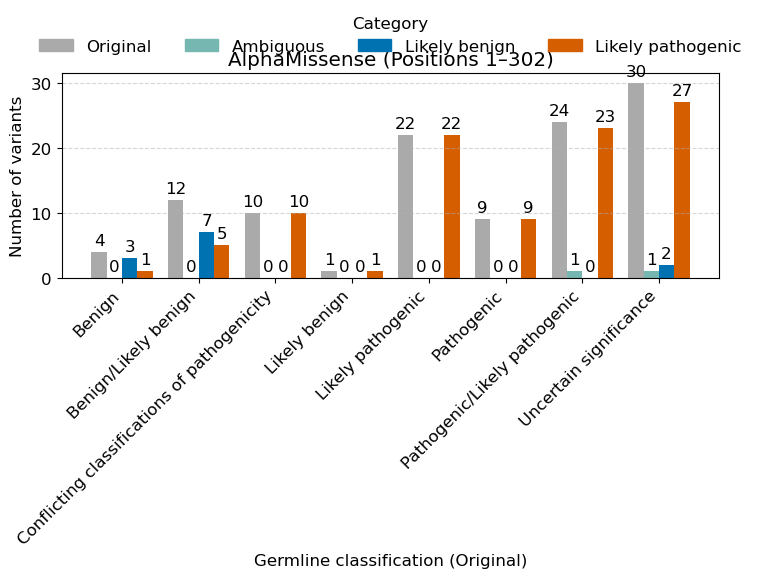

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Load merged AlphaMissense annotations
file_path = (
    "/project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/08_alphamissense/"
    "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_alphamissense.xlsx"
)
df = pd.read_excel(file_path, engine="openpyxl")

# Filter to positions 1–302
df = df[df['position'].between(1, 302)]

# Cross-tabulate original vs. AlphaMissense classes
order = ['ambiguous', 'likely_benign', 'likely_pathogenic']
cross = pd.crosstab(df['Germline classification'], df['am_class'])[order]

# Original counts
original = df['Germline classification'].value_counts().reindex(cross.index)

# Plot settings
colors = {
    'Original':        '#AAAAAA',
    'ambiguous':       '#76B7B2',  # muted green
    'likely_benign':   '#0072B2',  # blue
    'likely_pathogenic':'#D55E00' # orange
}

fig, ax = plt.subplots(figsize=(8, 6))
n_groups = len(cross)
n_bars = 1 + len(order)
total_width = 0.8
bar_width = total_width / n_bars
x = np.arange(n_groups)

# Plot grey original
for i, key in enumerate(['Original'] + order):
    if key == 'Original':
        counts = original.values
    else:
        counts = cross[key].values
    offset = -total_width/2 + i * bar_width + bar_width/2
    positions = x + offset
    ax.bar(positions, counts, bar_width, color=colors[key], label=key if key=='Original' else key.replace('_',' ').capitalize())
    for pos, cnt in zip(positions, counts):
        ax.text(pos, cnt + max(original.max(), cross.values.max())*0.02, str(int(cnt)), ha='center', va='bottom')

# Labels & title
ax.set_xticks(x)
ax.set_xticklabels(cross.index, rotation=45, ha='right')
ax.set_xlabel('Germline classification (Original)')
ax.set_ylabel('Number of variants')
ax.set_title('AlphaMissense (Positions 1–302)')

# Legend above plot
handles = [
    Patch(color=colors['Original'], label='Original')
] + [
    Patch(color=colors[k], label=k.replace('_',' ').capitalize()) for k in order
]
ax.legend(handles=handles, title='Category', loc='lower center',
          bbox_to_anchor=(0.5, 1.02), ncol=len(handles), frameon=False)

ax.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [11]:
import pandas as pd

def resolve_ambiguous_alphamissense(
    file_path: str,
    position_range: tuple[int,int] = (1,302),
    threshold: float = 0.5
) -> pd.Series:
    """
    Load AlphaMissense annotations, restrict to the given position range,
    then reclassify any 'ambiguous' entries based on the numeric am_pathogenicity score.

    - If am_pathogenicity >= threshold  → Pathogenic
    - Else                               → Benign

    Finally returns counts of the two classes.
    """
    # 1) Load & subset
    df = pd.read_excel(file_path, engine="openpyxl")
    start, end = position_range
    df = df[df['position'].between(start, end)].copy()

    # 2) New binary column
    def reclass(row):
        if row['am_class'] != 'ambiguous':
            # keep original likely_benign/pathogenic
            return 'Benign' if row['am_class']=='likely_benign' else 'Pathogenic'
        # ambiguous → decide by score
        return 'Pathogenic' if row['am_pathogenicity'] >= threshold else 'Benign'

    df['final_class'] = df.apply(reclass, axis=1)

    # 3) Tally
    counts = df['final_class'].value_counts().reindex(
        ['Benign','Pathogenic'], fill_value=0
    )
    return counts

if __name__ == "__main__":
    file_path = (
        "/project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/"
        "08_alphamissense/01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_alphamissense.xlsx"
    )

    # Try with threshold = median (≈0.9933) or T=0.5
    for T in [0.5, 0.9933]:
        counts = resolve_ambiguous_alphamissense(file_path, (1,302), threshold=T)
        print(f"\nThreshold = {T:.4f}:")
        print(counts)



Threshold = 0.5000:
final_class
Benign        14
Pathogenic    98
Name: count, dtype: int64

Threshold = 0.9933:
final_class
Benign        14
Pathogenic    98
Name: count, dtype: int64


# 09 SIFT

In [33]:
import os
import requests
import pandas as pd
from textwrap import wrap
from IPython.display import display, Markdown

# ─── Paths ───────────────────────────────────────────────────────────────────
sift_dir = "/project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/09_sift"
FASTA_OUT = os.path.join(sift_dir, "cdkl5_sift_sequence.fasta")
SUBS_OUT  = os.path.join(sift_dir, "cdkl5_sift_substitutions.txt")
VARIANT_XLSX = (
    "/project/ealexov/compbio/shamrat/250519_energy/00_data/"
    "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg.xlsx"
)

# ─── Fetch and write FASTA ───────────────────────────────────────────────────
resp = requests.get("https://rest.uniprot.org/uniprotkb/O76039.fasta")
resp.raise_for_status()
lines = resp.text.splitlines()
seq = "".join(lines[1:])
header = ">O76039_CDKL5 Homo sapiens CDKL5"
with open(FASTA_OUT, "w") as fh:
    fh.write(header + "\n")
    for line in wrap(seq, 60):
        fh.write(line + "\n")

# ─── Read variants and write substitutions ──────────────────────────────────
df = pd.read_excel(VARIANT_XLSX, usecols=["wild", "position", "mutant"])
df = df.dropna(subset=["wild", "position", "mutant"])
subs = df.apply(lambda r: f"{r.wild.upper()}{int(r.position)}{r.mutant.upper()}", axis=1)
with open(SUBS_OUT, "w") as fh:
    for s in subs:
        fh.write(s + "\n")

# ─── Confirm ────────────────────────────────────────────────────────────────
display(Markdown(f"**Written FASTA:** `{FASTA_OUT}`"))
display(Markdown(f"**Written substitutions:** `{SUBS_OUT}`"))


**Written FASTA:** `/project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/09_sift/cdkl5_sift_sequence.fasta`

**Written substitutions:** `/project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/09_sift/cdkl5_sift_substitutions.txt`

# 10 FATHMM

In [2]:
import os
import pandas as pd
from IPython.display import display, Markdown

# ─── Absolute paths ──────────────────────────────────────────────────────────
VARIANT_XLSX = (
    "/project/ealexov/compbio/shamrat/250519_energy/"
    "00_data/01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg.xlsx"
)
FATHMM_DIR = (
    "/project/ealexov/compbio/shamrat/250519_energy/"
    "05_pathogenicity/10_fathmm"
)
OUTPUT_FILE = os.path.join(FATHMM_DIR, "fathmm_input.txt")

# Create the directory if it doesn't exist
os.makedirs(FATHMM_DIR, exist_ok=True)

# ─── Read and build mutations ─────────────────────────────────────────────────
df = pd.read_excel(VARIANT_XLSX, engine="openpyxl")
df = df.dropna(subset=["wild", "position", "mutant"])
df["mutation"] = df.apply(
    lambda r: f"{r.wild.upper()}{int(r.position)}{r.mutant.upper()}",
    axis=1
)

# ─── Write the single‐line FATHMM input ───────────────────────────────────────
uniprot_id = "O76039"
line = uniprot_id + " " + ",".join(df["mutation"].tolist())

with open(OUTPUT_FILE, "w") as fh:
    fh.write(line + "\n")

# ─── Confirm to user ─────────────────────────────────────────────────────────
display(Markdown("**FATHMM input saved to:**"))
display(Markdown(f"`{OUTPUT_FILE}`"))
display(Markdown("**Contents:**"))
display(Markdown(f"`{line}`"))


**FATHMM input saved to:**

`/project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/10_fathmm/fathmm_input.txt`

**Contents:**

`O76039 I3F,N5D,F13S,G20R,G20V,G20D,E21G,G22V,G22E,Y24C,G25R,V27A,C30Y,R31G,T35I,H36R,A40V,I41F,K42R,T56M,R59P,L64P,R65Q,L67F,L67P,N71D,N71S,I72N,I72T,K76E,R80H,R80L,G83V,L97P,V107D,Y117C,L119R,A122T,W125C,C126Y,H127Y,H127R,V132G,D135G,P138L,L141F,I143N,I143V,H145Y,N146S,K150R,C152R,C152F,D153G,D153V,G155D,A157P,A157V,R158P,R158H,E162D,V172I,A173D,T174N,R175S,W176G,W176R,W176C,Y177S,Y177C,R178W,R178P,R178Q,S179F,P180L,E181A,L182P,L184H,A186T,D193H,D193G,D193V,D193N,S196L,G198R,G198D,C199R,L201P,G202E,E203K,E203D,G207E,P209R,G213E,G213R,Q219K,Q219P,L220P,K225R,L227R,S240T,R248W,H254R,Y262H,L271P,D284E,R285S,T288I,C291R,C291Y,T296A,L302F,R355Q,N363S,N370S,N399T,K412E,D422E,K432Q,R444C,N461S,H467P,H467R,S481C,G490R,I508T,S519P,L522V,P527S,T538A,T562A,P574L,H581Y,P588S,E590K,R617C,I631T,L644F,A696T,L703V,V718M,V732M,T734A,L739V,N748S,Q770K,E773G,Q791P,V793A,D797N,R822H,S849L,P852L,R858C,R890Q,P895L`

In [20]:
#!/usr/bin/env python3
import pandas as pd
import os

# ─── Paths ────────────────────────────────────────────────────────────────────
fathmm_dir = "/project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/10_fathmm"
xlsx_path  = os.path.join(fathmm_dir, "fathmm_results.xlsx")

# ─── Load ──────────────────────────────────────────────────────────────────────
df = pd.read_excel(xlsx_path, engine="openpyxl")

# ─── Pick only the five columns ────────────────────────────────────────────────
cols = ["dbSNP ID", "Protein ID", "Substitution", "Prediction", "Score"]
sub = df[cols]

# ─── Print column names ────────────────────────────────────────────────────────
print("Selected columns:")
for c in cols:
    print(f"- {c}")
print()

# ─── Preview the first 10 rows ────────────────────────────────────────────────
print("First 10 rows of those columns:")
print(sub.head(10).to_string(index=False))


Selected columns:
- dbSNP ID
- Protein ID
- Substitution
- Prediction
- Score

First 10 rows of those columns:
 dbSNP ID Protein ID Substitution Prediction  Score
      NaN     O76039          I3F  TOLERATED  -0.59
      NaN     O76039          N5D  TOLERATED  -0.42
      NaN     O76039         F13S  TOLERATED   0.60
      NaN     O76039         G20R   DAMAGING  -1.64
      NaN     O76039         G20V   DAMAGING  -1.65
      NaN     O76039         G20D   DAMAGING  -1.63
      NaN     O76039         E21G  TOLERATED  -0.30
      NaN     O76039         G22V   DAMAGING  -3.99
      NaN     O76039         G22E   DAMAGING  -3.98
      NaN     O76039         Y24C  TOLERATED   0.70


In [16]:
import pandas as pd

# Path to your FATHMM results
fathmm_xlsx = "/project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/10_fathmm/fathmm_results.xlsx"

# 1) Read in the Excel
df = pd.read_excel(fathmm_xlsx, engine="openpyxl")

# 2) Count raw Prediction labels (TOLERATED vs DAMAGING)
raw_counts = df['Prediction'].value_counts(dropna=False)
print("Raw Prediction counts:")
print(raw_counts.to_string())

# 3) (Optional) Map to simple classes and recount
df['FATHMM_class'] = df['Prediction'].map({
    'TOLERATED': 'benign',
    'DAMAGING':  'pathogenic'
})
class_counts = df['FATHMM_class'].value_counts(dropna=False)
print("\nMapped class counts:")
print(class_counts.to_string())


Raw Prediction counts:
Prediction
TOLERATED    140
DAMAGING      16

Mapped class counts:
FATHMM_class
benign        140
pathogenic     16


In [6]:
#!/usr/bin/env python3
import os
import pandas as pd

# ─── 0. Paths ────────────────────────────────────────────────────────────────
VARIANT_XLSX = (
    "/project/ealexov/compbio/shamrat/250519_energy/"
    "00_data/01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg.xlsx"
)
FATHMM_DIR   = (
    "/project/ealexov/compbio/shamrat/250519_energy/"
    "05_pathogenicity/10_fathmm"
)
FATHMM_XLSX  = os.path.join(FATHMM_DIR, "fathmm_results.xlsx")

# ─── Derive output name by inserting "classified_" before "fathmm" ───────────
base_name   = "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg"
OUT_XLSX    = os.path.join(
    FATHMM_DIR,
    f"{base_name}_classified_fathmm.xlsx"
)

# ─── 1. Load data ─────────────────────────────────────────────────────────────
variants_df = pd.read_excel(VARIANT_XLSX, engine="openpyxl")
fathmm_df   = pd.read_excel(FATHMM_XLSX,  engine="openpyxl")

# ─── 2. Prepare FATHMM lookup ─────────────────────────────────────────────────
fathmm_small = (
    fathmm_df[["Substitution", "Prediction", "Score"]]
    .rename(columns={"Substitution": "mutation"})
)

# ─── 3. Merge (1:1 on mutation) ────────────────────────────────────────────────
merged = variants_df.merge(
    fathmm_small,
    on="mutation",
    how="left"
)

# ─── 4. Add ClinVar‐style classification column ────────────────────────────────
mapping = {
    "DAMAGING":  "Pathogenic",
    "TOLERATED": "Benign"
}
merged["FATHMM_classification"] = merged["Prediction"].map(mapping)

# ─── 5. (Optional) Quick sanity check ──────────────────────────────────────────
print("\nClinVar vs FATHMM_classification:")
print(pd.crosstab(
    merged["Germline classification"],
    merged["FATHMM_classification"]
), "\n")

# ─── 6. Save final Excel ───────────────────────────────────────────────────────
merged.to_excel(OUT_XLSX, index=False)
print(f"Wrote annotated table to:\n  {OUT_XLSX}")



ClinVar vs FATHMM_classification:
FATHMM_classification                         Benign  Pathogenic
Germline classification                                         
Benign                                            19           1
Benign/Likely benign                              15           0
Conflicting classifications of pathogenicity      13           0
Likely benign                                     10           0
Likely pathogenic                                 16           6
Pathogenic                                         5           4
Pathogenic/Likely pathogenic                      22           2
Uncertain significance                            40           3 

Wrote annotated table to:
  /project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/10_fathmm/01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_classified_fathmm.xlsx


In [3]:
#!/usr/bin/env python3
import pandas as pd

# ─── Path to your merged FATHMM Excel ────────────────────────────────────────
MERGED_XLSX = (
    "/project/ealexov/compbio/shamrat/250519_energy/"
    "05_pathogenicity/10_fathmm/"
    "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_fathmm.xlsx"
)

# ─── 1. Load the merged table ─────────────────────────────────────────────────
df = pd.read_excel(MERGED_XLSX, engine="openpyxl")

# ─── 2. Count each FATHMM Prediction class ────────────────────────────────────
prediction_counts = (
    df['Prediction']
      .value_counts(dropna=False)
      .rename_axis('Prediction')
      .reset_index(name='Count')
)

# ─── 3. Print the counts ──────────────────────────────────────────────────────
print(prediction_counts.to_string(index=False))


Prediction  Count
 TOLERATED    140
  DAMAGING     16


In [15]:
#!/usr/bin/env python3
import os
import pandas as pd

# ─── 0. Paths ────────────────────────────────────────────────────────────────
# your original CDKL5 variants
variants_xlsx = (
    "/project/ealexov/compbio/shamrat/250519_energy/00_data/"
    "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg.xlsx"
)

# where you put your FATHMM output
fathmm_dir    = "/project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/10_fathmm"
fathmm_xlsx   = os.path.join(fathmm_dir, "fathmm_results.xlsx")

# output merged file
out_xlsx      = os.path.join(fathmm_dir, "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_fathmm.xlsx")

# ─── 1. Load both tables ──────────────────────────────────────────────────────
variants_df = pd.read_excel(variants_xlsx, engine="openpyxl")
fathmm_df   = pd.read_excel(fathmm_xlsx,   engine="openpyxl")

# ─── 2. Normalize key columns ────────────────────────────────────────────────
# variants_df needs a 'mutation' column matching the FATHMM 'Substitution'
# if you already have a mutation col like "I3F" in variants_df, skip creation
if 'mutation' not in variants_df.columns:
    variants_df['mutation'] = (
        variants_df['wild'].str.upper()
        + variants_df['position'].astype(int).astype(str)
        + variants_df['mutant'].str.upper()
    )

# FATHMM file: ensure the substitution column is called exactly 'Substitution'
# and strip any whitespace
fathmm_df['Substitution'] = fathmm_df['Substitution'].astype(str).str.strip()

# ─── 3. Map FATHMM Prediction → simple class ─────────────────────────────────
# FATHMM labels: TOLERATED → benign, DAMAGING → pathogenic
fathmm_df['FATHMM_class'] = fathmm_df['Prediction'].map({
    'TOLERATED': 'benign',
    'DAMAGING':   'pathogenic'
})

# ─── 4. Build a lookup and merge ─────────────────────────────────────────────
lookup = fathmm_df.set_index('Substitution')[['Score', 'FATHMM_class']]
merged = variants_df.merge(
    lookup,
    left_on='mutation',
    right_index=True,
    how='left'
)

# ─── 5. Save out ──────────────────────────────────────────────────────────────
merged.to_excel(out_xlsx, index=False)
print(f"Wrote merged FATHMM annotations to:\n  {out_xlsx}")


Wrote merged FATHMM annotations to:
  /project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/10_fathmm/01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_fathmm.xlsx


In [21]:
#!/usr/bin/env python3
import os
import pandas as pd

# ─── 0. Paths ────────────────────────────────────────────────────────────────
# your original CDKL5 variants
variants_xlsx = (
    "/project/ealexov/compbio/shamrat/250519_energy/00_data/"
    "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg.xlsx"
)

# where you put your FATHMM output
fathmm_dir    = "/project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/10_fathmm"
fathmm_xlsx   = os.path.join(fathmm_dir, "fathmm_results.xlsx")

# output merged file
out_xlsx      = os.path.join(fathmm_dir, "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_fathmm.xlsx")

# ─── 1. Load both tables ──────────────────────────────────────────────────────
variants_df = pd.read_excel(variants_xlsx, engine="openpyxl")
fathmm_df   = pd.read_excel(fathmm_xlsx,   engine="openpyxl")

# ─── 2. Normalize key columns ────────────────────────────────────────────────
# variants_df needs a 'mutation' column matching the FATHMM 'Substitution'
# if you already have a mutation col like "I3F" in variants_df, skip creation
if 'mutation' not in variants_df.columns:
    variants_df['mutation'] = (
        variants_df['wild'].str.upper()
        + variants_df['position'].astype(int).astype(str)
        + variants_df['mutant'].str.upper()
    )

# FATHMM file: ensure the substitution column is called exactly 'Substitution'
# and strip any whitespace
fathmm_df['Substitution'] = fathmm_df['Substitution'].astype(str).str.strip()

# ─── 3. Map FATHMM Prediction → simple class ─────────────────────────────────
# FATHMM labels: TOLERATED → benign, DAMAGING → pathogenic
fathmm_df['FATHMM_class'] = fathmm_df['Prediction'].map({
    'TOLERATED': 'benign',
    'DAMAGING':   'pathogenic'
})

# ─── 4. Build a lookup and merge ─────────────────────────────────────────────
lookup = fathmm_df.set_index('Substitution')[['Score', 'FATHMM_class']]
merged = variants_df.merge(
    lookup,
    left_on='mutation',
    right_index=True,
    how='left'
)

# ─── 5. Save out ──────────────────────────────────────────────────────────────
merged.to_excel(out_xlsx, index=False)
print(f"Wrote merged FATHMM annotations to:\n  {out_xlsx}")


Wrote merged FATHMM annotations to:
  /project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/10_fathmm/01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_fathmm.xlsx


In [22]:
#!/usr/bin/env python3
import pandas as pd
import os

# ─── Paths ───────────────────────────────────────────────────────────────────
fathmm_dir  = "/project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/10_fathmm"
merged_xlsx = os.path.join(fathmm_dir, "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_fathmm.xlsx")

# ─── Load & filter to positions 1–302 ────────────────────────────────────────
df = pd.read_excel(merged_xlsx, engine="openpyxl")
df = df[df['position'].between(1, 302)]

# ─── 1) Germline‐classification counts ─────────────────────────────────────────
germ_counts = (
    df['Germline classification']
      .value_counts(dropna=False)
      .rename_axis('Germline classification')
      .reset_index(name='Count')
)
print("Germline classification (positions 1–302):")
print(germ_counts.to_string(index=False))

# ─── 2) FATHMM class counts ───────────────────────────────────────────────────
fathmm_counts = (
    df['FATHMM_class']
      .value_counts(dropna=False)
      .rename_axis('FATHMM class')
      .reset_index(name='Count')
)
print("\nFATHMM classification (positions 1–302):")
print(fathmm_counts.to_string(index=False))


Germline classification (positions 1–302):
                     Germline classification  Count
                      Uncertain significance     30
                Pathogenic/Likely pathogenic     24
                           Likely pathogenic     22
                        Benign/Likely benign     12
Conflicting classifications of pathogenicity     10
                                  Pathogenic      9
                                      Benign      4
                               Likely benign      1

FATHMM classification (positions 1–302):
FATHMM class  Count
      benign     97
  pathogenic     15


# analysis


PolyPhen-2 Counts:
prediction                                    benign  possibly damaging  \
Germline classification                                                   
Benign                                             2                  1   
Benign/Likely benign                               4                  1   
Conflicting classifications of pathogenicity       0                  0   
Likely benign                                      0                  0   
Likely pathogenic                                  0                  0   
Pathogenic                                         0                  0   
Pathogenic/Likely pathogenic                       0                  2   
Uncertain significance                             1                  3   

prediction                                    probably damaging  Total  
Germline classification                                                 
Benign                                                        1      4  
Benign/Lik

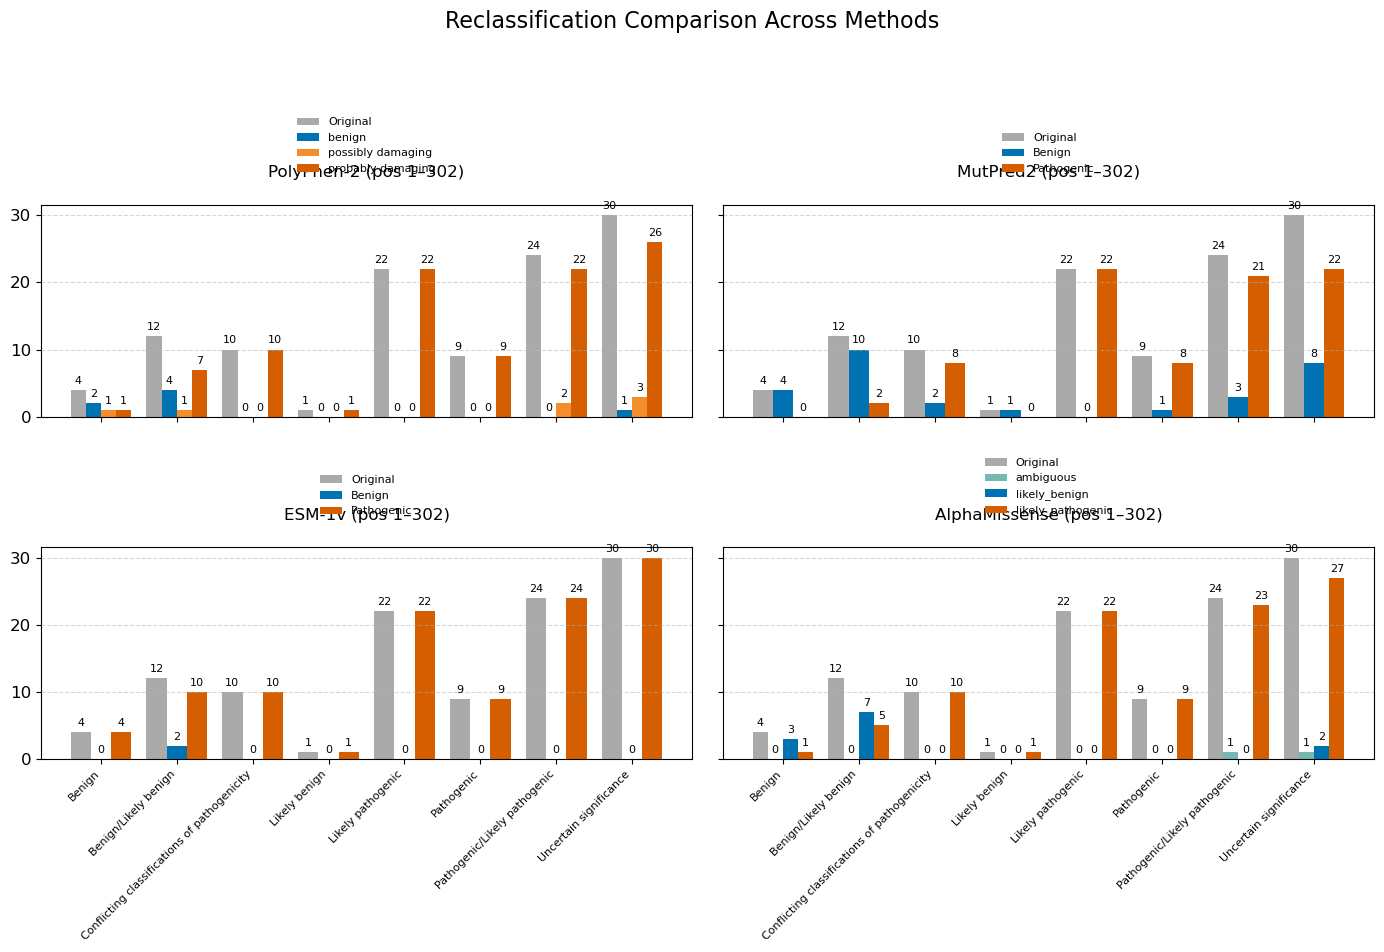

Saved plot to /project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/reclassification_comparison.png


In [75]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# 1) Full paths to your input files (verify these exactly match `ls` output)
polyphen_path = "/project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/01_polyphen2/01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_polyphen2.xlsx"
mutpred2_path = "/project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/02_mutpred2/01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_classified_mutpred2.xlsx"
esm1v_path    = "/project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/03_esm/01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_classified_esm1v.xlsx"
alphamiss_path= "/project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/08_alphamissense/01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_alphamissense.xlsx"
out_png       = "/project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/reclassification_comparison.png"

# 2) Load data
df_pp2 = pd.read_excel(polyphen_path, engine="openpyxl")
df_mp2 = pd.read_excel(mutpred2_path, engine="openpyxl")
df_esm = pd.read_excel(esm1v_path,    engine="openpyxl")
df_am  = pd.read_excel(alphamiss_path,engine="openpyxl")

# 3) Define datasets
datasets = {
    "PolyPhen-2": {
        "df": df_pp2, "pred": "prediction", "order": ["benign","possibly damaging","probably damaging"],
        "colors": {"Original":"#AAAAAA","benign":"#0072B2","possibly damaging":"#F28E2B","probably damaging":"#D55E00"}
    },
    "MutPred2": {
        "df": df_mp2, "pred": "MutPred2_classification", "order": ["Benign","Pathogenic"],
        "colors": {"Original":"#AAAAAA","Benign":"#0072B2","Pathogenic":"#D55E00"}
    },
    "ESM-1v": {
        "df": df_esm, "pred": "ESM1v_classification", "order": ["Benign","Pathogenic"],
        "colors": {"Original":"#AAAAAA","Benign":"#0072B2","Pathogenic":"#D55E00"}
    },
    "AlphaMissense": {
        "df": df_am,  "pred": "am_class", "order": ["ambiguous","likely_benign","likely_pathogenic"],
        "colors": {"Original":"#AAAAAA","ambiguous":"#76B7B2","likely_benign":"#0072B2","likely_pathogenic":"#D55E00"}
    }
}

# 4) Compute cross-tabs & print stats
def compute_and_print(name, df, pred, order):
    poscol = "position_x" if "position_x" in df.columns else "position"
    sub = df[df[poscol].between(1,302)].copy()
    if name=="PolyPhen-2":
        sub[pred] = sub["prediction"].str.lower().str.strip()
    ct = pd.crosstab(sub["Germline classification"], sub[pred])[order]
    orig = sub["Germline classification"].value_counts().reindex(ct.index)
    ct["Total"] = ct.sum(axis=1)
    pct = ct.div(ct["Total"], axis=0).round(2)
    print(f"\n{name} Counts:")
    print(ct)
    print(f"\n{name} Percentages:")
    print(pct)
    return ct, orig

data = {}
for name, cfg in datasets.items():
    ct, orig = compute_and_print(name, cfg["df"], cfg["pred"], cfg["order"])
    data[name] = (ct, orig, cfg["colors"])

# 5) Plotting helper
def plot_reclass(ax, ct, orig, colors, title):
    cats = ["Original"] + list(colors.keys())[1:]
    total_w = 0.8
    bar_w = total_w/len(cats)
    x = np.arange(len(ct))
    ymax = max(orig.max(), ct.values.max())
    for i, cat in enumerate(cats):
        counts = orig.values if cat=="Original" else ct[cat].values
        pos = x - total_w/2 + i*bar_w + bar_w/2
        ax.bar(pos, counts, bar_w, color=colors[cat])
        for p, c in zip(pos, counts):
            ax.text(p, c+ymax*0.02, str(int(c)), ha="center", va="bottom", fontsize=8)
    ax.set_title(title, fontsize=12, pad=20)
    ax.legend(cats, loc="lower center", bbox_to_anchor=(0.5,1.10), frameon=False, fontsize=8)
    ax.grid(axis="y", linestyle="--", alpha=0.5)

# 6) Create 2x2 grid
fig, axs = plt.subplots(2,2,figsize=(14,10),sharey=True)
axs = axs.flatten()
for ax, (name,(ct,orig,colors)) in zip(axs, data.items()):
    plot_reclass(ax, ct, orig, colors, f"{name} (pos 1–302)")
    if ax.get_subplotspec().is_last_row():
        ax.set_xticks(np.arange(len(ct)))
        ax.set_xticklabels(ct.index, rotation=45,ha="right",fontsize=8)
    else:
        ax.set_xticklabels([])

plt.suptitle("Reclassification Comparison Across Methods",fontsize=16,y=0.95)
plt.tight_layout(rect=[0,0,1,0.92])
plt.savefig(out_png,dpi=300)
plt.show()

print(f"Saved plot to {out_png}")


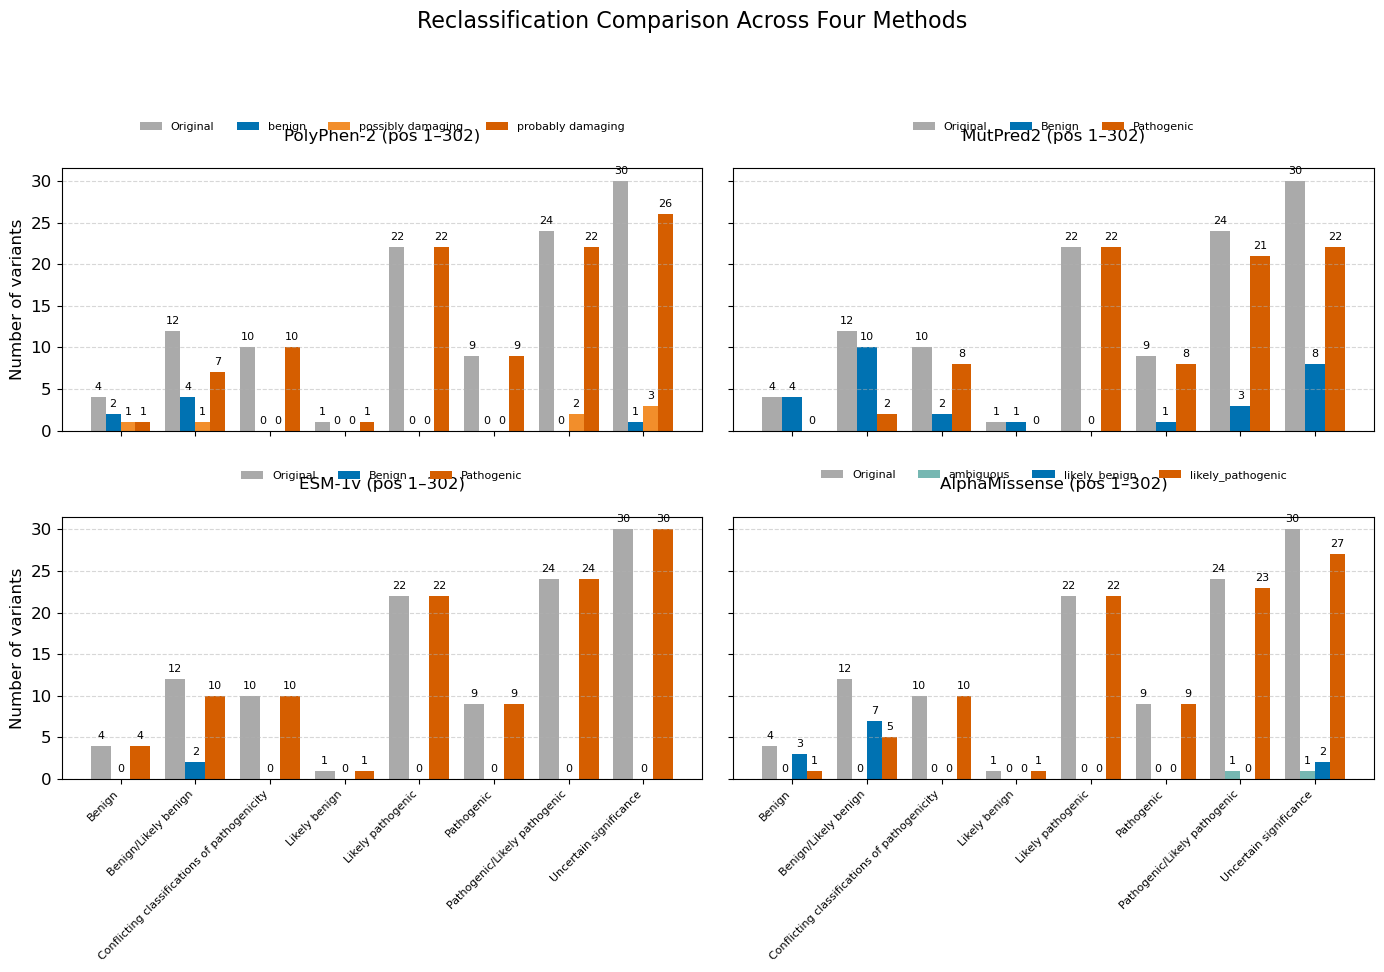

Saved plot to /project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/reclassification_comparison.png


In [74]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_reclassification(ax, cross, original, categories, colors, title):
    total_width = 0.8
    bar_width = total_width / len(categories)
    x = np.arange(len(cross))
    ymax = max(original.max(), cross.values.max())
    
    # Plot bars and annotations
    for i, cat in enumerate(categories):
        counts = (original.values if cat == 'Original'
                  else cross.get(cat, pd.Series(0, index=cross.index)).values)
        offset = -total_width/2 + i*bar_width + bar_width/2
        pos = x + offset
        ax.bar(pos, counts, bar_width, color=colors[cat], label=cat)
        for px, ct in zip(pos, counts):
            ax.text(px, ct + ymax*0.02, str(int(ct)),
                    ha='center', va='bottom', fontsize=8)
    
    # Title
    ax.set_title(title, fontsize=12, pad=20)  # pad to make room for legend
    
    # Legend just above the title
    leg = ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1.10),
                    ncol=len(categories), frameon=False, fontsize=8)
    
    ax.grid(axis='y', linestyle='--', alpha=0.5)

# Base directory
base = "/project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity"

# Method configurations
methods = {
    'PolyPhen-2': {
        'path': os.path.join(base, "01_polyphen2",
                             "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_polyphen2.xlsx"),
        'pred': 'prediction',
        'order': ['benign','possibly damaging','probably damaging'],
        'colors': {
            'Original':           '#AAAAAA',
            'benign':             '#0072B2',
            'possibly damaging':  '#F28E2B',
            'probably damaging':  '#D55E00'
        }
    },
    'MutPred2': {
        'path': os.path.join(base, "02_mutpred2",
                             "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_classified_mutpred2.xlsx"),
        'pred': 'MutPred2_classification',
        'order': ['Benign','Pathogenic'],
        'colors': {
            'Original':   '#AAAAAA',
            'Benign':     '#0072B2',
            'Pathogenic': '#D55E00'
        }
    },
    'ESM-1v': {
        'path': os.path.join(base, "03_esm",
                             "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_classified_esm1v.xlsx"),
        'pred': 'ESM1v_classification',
        'order': ['Benign','Pathogenic'],
        'colors': {
            'Original':   '#AAAAAA',
            'Benign':     '#0072B2',
            'Pathogenic': '#D55E00'
        }
    },
    'AlphaMissense': {
        'path': os.path.join(base, "08_alphamissense",
                             "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_alphamissense.xlsx"),
        'pred': 'am_class',
        'order': ['ambiguous','likely_benign','likely_pathogenic'],
        'colors': {
            'Original':          '#AAAAAA',
            'ambiguous':         '#76B7B2',
            'likely_benign':     '#0072B2',
            'likely_pathogenic':'#D55E00'
        }
    }
}

# Load and prepare data
data = {}
for name, cfg in methods.items():
    df = pd.read_excel(cfg['path'], engine='openpyxl')
    poscol = 'position_x' if 'position_x' in df.columns else 'position'
    df = df[df[poscol].between(1, 302)].copy()
    if name == 'PolyPhen-2':
        df['prediction_clean'] = df['prediction'].str.lower().str.strip()
        predcol = 'prediction_clean'
    else:
        predcol = cfg['pred']
    cross = pd.crosstab(df['Germline classification'], df[predcol])[cfg['order']]
    original = df['Germline classification'].value_counts().reindex(cross.index)
    data[name] = (cross, original, cfg['colors'], cfg['order'])

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharey=True)
axes = axes.flatten()

for ax, (method, (cross, original, colors, order)) in zip(axes, data.items()):
    plot_reclassification(
        ax, cross, original,
        categories=['Original'] + order,
        colors=colors,
        title=f"{method} (pos 1–302)"
    )
    # X-axis labels only on bottom row
    if ax.get_subplotspec().is_last_row():
        ax.set_xticks(np.arange(len(cross)))
        ax.set_xticklabels(cross.index, rotation=45, ha='right', fontsize=8)
    else:
        ax.set_xticklabels([])

# Y-axis label on left column
for ax in axes.reshape(2,2)[:,0]:
    ax.set_ylabel("Number of variants")

plt.suptitle("Reclassification Comparison Across Four Methods", fontsize=16, y=0.97)
plt.tight_layout(rect=[0,0,1,0.93])

# Save figure
out_png = os.path.join(base, "reclassification_comparison.png")
plt.savefig(out_png, dpi=300)
plt.show()

print("Saved plot to", out_png)


# 250707 Draft see the final tables of each dataset

In [11]:
import pandas as pd
from IPython.display import display, Markdown

# ─── Define the columns you want ───────────────────────────────────────────
common_cols = ["Protein change", "Germline classification"]

method_specific = {
    "PolyPhen-2":     ["prediction", "pph2_prob", "pph2_FPR", "pph2_TPR"],
    "MutPred2":       ["MutPred2_score", "MutPred2_classification"],
    "ESM-1v":         ["wild_score", "mut_score", "delta_score", "ESM1v_classification"],
    "AlphaMissense":  ["am_pathogenicity", "am_class"]
}

# ─── Classification thresholds ──────────────────────────────────────────────
thresholds = {
    "PolyPhen-2":     "Uses PolyPhen-2’s internal categories (benign/possibly damaging/probably damaging).",
    "MutPred2":       "Threshold: Pathogenic if MutPred2_score ≥ 0.67, else Benign.",
    "ESM-1v":         "Threshold: Pathogenic if Δscore < 0 (mut_score < wild_score), else Benign.",
    "AlphaMissense":  "Uses AlphaMissense-provided class labels (ambiguous/likely_benign/likely_pathogenic)."
}

# ─── Paths to your final files ──────────────────────────────────────────────
base_dir = "/project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity"
files = {
    "PolyPhen-2":     f"{base_dir}/01_polyphen2/01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_polyphen2.xlsx",
    "MutPred2":       f"{base_dir}/02_mutpred2/01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_classified_mutpred2.xlsx",
    "ESM-1v":         f"{base_dir}/03_esm/01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_classified_esm1v.xlsx",
    "AlphaMissense":  f"{base_dir}/08_alphamissense/01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_alphamissense.xlsx"
}

# ─── Load, display thresholds, and show tables ──────────────────────────────
for method, path in files.items():
    display(Markdown(f"## {method} results\n`{path}`"))
    # Print threshold for classification
    display(Markdown(f"**Classification rule:** {thresholds[method]}"))
    
    df = pd.read_excel(path, engine="openpyxl")
    cols = common_cols + method_specific[method]
    
    display(Markdown("**First 5 rows (selected columns):**"))
    display(df.loc[:, cols].head())



## PolyPhen-2 results
`/project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/01_polyphen2/01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_polyphen2.xlsx`

**Classification rule:** Uses PolyPhen-2’s internal categories (benign/possibly damaging/probably damaging).

**First 5 rows (selected columns):**

,Protein change,Germline classification,prediction,pph2_prob,pph2_FPR,pph2_TPR
0,I3F,Benign,probably damaging,0.999,0.00574,0.13600
1,N5D,Benign,benign,0.114,0.14200,0.92700
2,F13S,Likely pathogenic,probably damaging,1.000,0.00026,0.00018
3,G20R,Pathogenic,probably damaging,1.000,0.00026,0.00018
4,G20V,Pathogenic,probably damaging,1.000,0.00026,0.00018


## MutPred2 results
`/project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/02_mutpred2/01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_classified_mutpred2.xlsx`

**Classification rule:** Threshold: Pathogenic if MutPred2_score ≥ 0.67, else Benign.

**First 5 rows (selected columns):**

,Protein change,Germline classification,MutPred2_score,MutPred2_classification
0,I3F,Benign,0.286,Benign
1,N5D,Benign,0.135,Benign
2,F13S,Likely pathogenic,0.895,Pathogenic
3,G20R,Pathogenic,0.912,Pathogenic
4,G20V,Pathogenic,0.928,Pathogenic


## ESM-1v results
`/project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/03_esm/01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_classified_esm1v.xlsx`

**Classification rule:** Threshold: Pathogenic if Δscore < 0 (mut_score < wild_score), else Benign.

**First 5 rows (selected columns):**

,Protein change,Germline classification,wild_score,mut_score,delta_score,ESM1v_classification
0,I3F,Benign,-273.480652,-274.565460,-1.084808,Pathogenic
1,N5D,Benign,-273.480652,-278.556641,-5.075989,Pathogenic
2,F13S,Likely pathogenic,-273.480652,-283.678680,-10.198029,Pathogenic
3,G20R,Pathogenic,-273.480652,-282.508423,-9.027771,Pathogenic
4,G20V,Pathogenic,-273.480652,-288.576172,-15.095520,Pathogenic


## AlphaMissense results
`/project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/08_alphamissense/01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_alphamissense.xlsx`

**Classification rule:** Uses AlphaMissense-provided class labels (ambiguous/likely_benign/likely_pathogenic).

**First 5 rows (selected columns):**

,Protein change,Germline classification,am_pathogenicity,am_class
0,I3F,Benign,0.1217,likely_benign
1,N5D,Benign,0.0945,likely_benign
2,F13S,Likely pathogenic,0.9996,likely_pathogenic
3,G20R,Pathogenic,1.0000,likely_pathogenic
4,G20V,Pathogenic,0.9995,likely_pathogenic


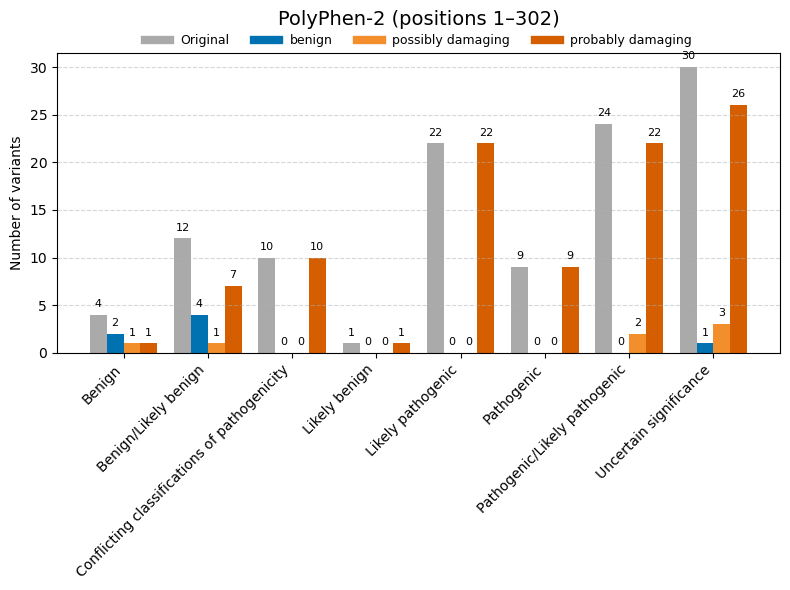

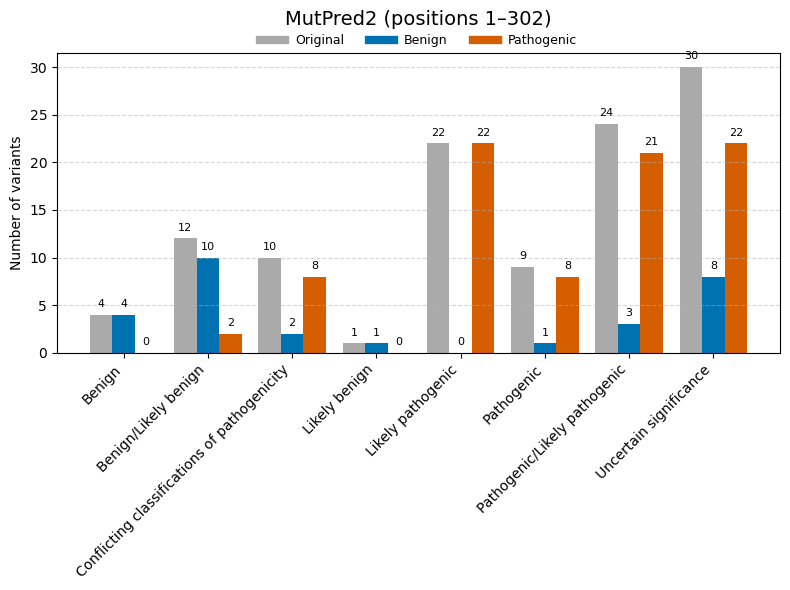

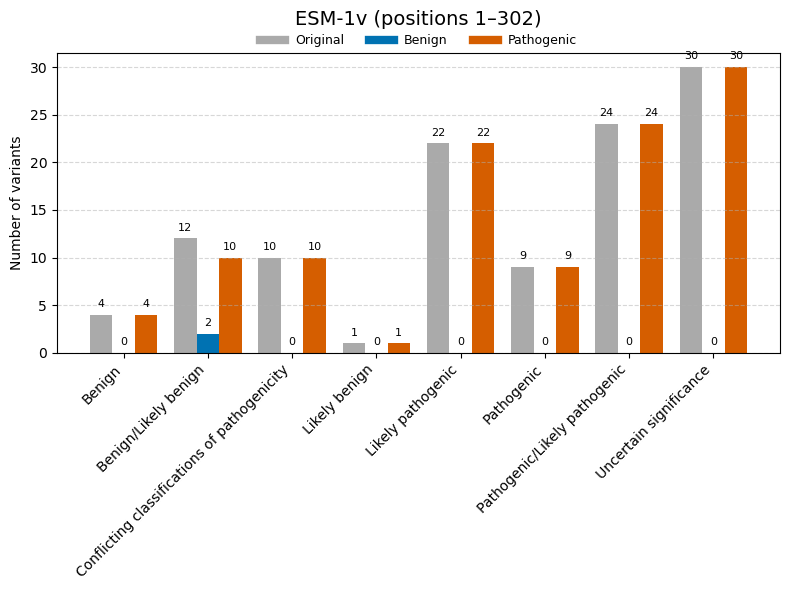

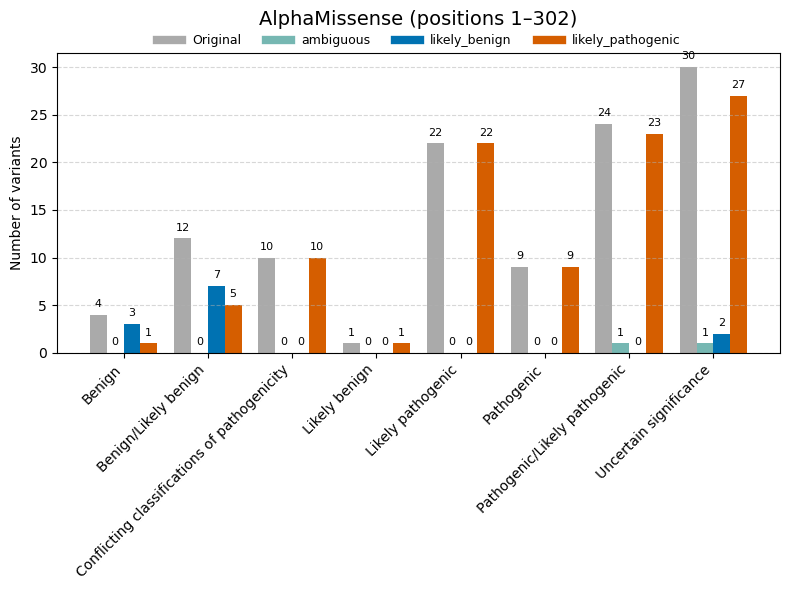

In [22]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_reclassification(ax, cross, original, categories, colors, title):
    total_width = 0.8
    bar_width = total_width / len(categories)
    x = np.arange(len(cross))
    ymax = max(original.max(), cross.values.max())
    
    # Bars + annotations
    for i, cat in enumerate(categories):
        counts = (original.values if cat == 'Original'
                  else cross.get(cat, pd.Series(0, index=cross.index)).values)
        offset = -total_width/2 + i*bar_width + bar_width/2
        pos = x + offset
        ax.bar(pos, counts, bar_width, color=colors[cat])
        for px, ct in zip(pos, counts):
            ax.text(px, ct + ymax*0.02, str(int(ct)),
                    ha='center', va='bottom', fontsize=8)
    
    # Axes formatting
    ax.set_xticks(x)
    ax.set_xticklabels(cross.index, rotation=45, ha='right', fontsize=10)
    ax.set_ylabel("Number of variants")
    ax.set_title(title, fontsize=14, pad=20)
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    
    # Legend outside, below title
    handles = [plt.Line2D([0],[0], color=colors[c], lw=6) for c in categories]
    ax.legend(handles, categories,
              loc='upper center',
              bbox_to_anchor=(0.5, 1.10),
              ncol=len(categories),
              frameon=False,
              fontsize=9)

# Base directory
base = "/project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity"

methods = {
    'PolyPhen-2': {
        'path': os.path.join(base, "01_polyphen2",
                             "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_polyphen2.xlsx"),
        'pred': 'prediction',
        'order': ['benign','possibly damaging','probably damaging'],
        'colors': {
            'Original':           '#AAAAAA',
            'benign':             '#0072B2',
            'possibly damaging':  '#F28E2B',
            'probably damaging':  '#D55E00'
        }
    },
    'MutPred2': {
        'path': os.path.join(base, "02_mutpred2",
                             "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_classified_mutpred2.xlsx"),
        'pred': 'MutPred2_classification',
        'order': ['Benign','Pathogenic'],
        'colors': {
            'Original':   '#AAAAAA',
            'Benign':     '#0072B2',
            'Pathogenic': '#D55E00'
        }
    },
    'ESM-1v': {
        'path': os.path.join(base, "03_esm",
                             "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_classified_esm1v.xlsx"),
        'pred': 'ESM1v_classification',
        'order': ['Benign','Pathogenic'],
        'colors': {
            'Original':   '#AAAAAA',
            'Benign':     '#0072B2',
            'Pathogenic': '#D55E00'
        }
    },
    'AlphaMissense': {
        'path': os.path.join(base, "08_alphamissense",
                             "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_alphamissense.xlsx"),
        'pred': 'am_class',
        'order': ['ambiguous','likely_benign','likely_pathogenic'],
        'colors': {
            'Original':          '#AAAAAA',
            'ambiguous':         '#76B7B2',
            'likely_benign':     '#0072B2',
            'likely_pathogenic':'#D55E00'
        }
    }
}

for name, cfg in methods.items():
    df = pd.read_excel(cfg['path'], engine='openpyxl')
    poscol = 'position_x' if 'position_x' in df.columns else 'position'
    df = df[df[poscol].between(1, 302)].copy()
    
    if name == 'PolyPhen-2':
        df['prediction_clean'] = df['prediction'].str.lower().str.strip()
        predcol = 'prediction_clean'
    else:
        predcol = cfg['pred']
    
    cross = pd.crosstab(df['Germline classification'], df[predcol])[cfg['order']]
    original = df['Germline classification'].value_counts().reindex(cross.index)
    
    fig, ax = plt.subplots(figsize=(8,6))
    plot_reclassification(
        ax, cross, original,
        categories=['Original'] + cfg['order'],
        colors=cfg['colors'],
        title=f"{name} (positions 1–302)"
    )
    plt.tight_layout()
    plt.show()


In [26]:
import pandas as pd
from IPython.display import display, Markdown

# ─── Full paths to your final Excel files ───────────────────────────────────
datasets = {
    "PolyPhen-2": (
        "/project/ealexov/compbio/shamrat/250519_energy/"
        "05_pathogenicity/01_polyphen2/"
        "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_polyphen2.xlsx"
    ),
    "MutPred2": (
        "/project/ealexov/compbio/shamrat/250519_energy/"
        "05_pathogenicity/02_mutpred2/"
        "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_classified_mutpred2.xlsx"
    ),
    "ESM-1v": (
        "/project/ealexov/compbio/shamrat/250519_energy/"
        "05_pathogenicity/03_esm/"
        "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_classified_esm1v.xlsx"
    ),
    "AlphaMissense": (
        "/project/ealexov/compbio/shamrat/250519_energy/"
        "05_pathogenicity/08_alphamissense/"
        "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_alphamissense.xlsx"
    )
}

# Column holding each tool's final classification
pred_cols = {
    "PolyPhen-2":    "prediction",
    "MutPred2":      "MutPred2_classification",
    "ESM-1v":        "ESM1v_classification",
    "AlphaMissense": "am_class"
}

for name, path in datasets.items():
    display(Markdown(f"## {name}"))

    # Load data
    df = pd.read_excel(path, engine="openpyxl")

    # Compute counts
    orig_counts = df["Germline classification"].value_counts()
    pred_counts = df[pred_cols[name]].value_counts()

    # Combine into a single DataFrame
    combined = pd.DataFrame({
        "Original count": orig_counts,
        "Predicted count": pred_counts
    }).fillna(0).astype(int)

    # Display table
    display(Markdown("**Germline vs Predicted counts:**"))
    display(combined.reset_index().rename(columns={"index": "Classification"}))


## PolyPhen-2

**Germline vs Predicted counts:**

,Classification,Original count,Predicted count
0,benign,0,26
1,possibly damaging,0,15
2,probably damaging,0,115
3,Benign,20,0
4,Benign/Likely benign,15,0
5,Conflicting classifications of pathogenicity,13,0
6,Likely benign,10,0
7,Likely pathogenic,22,0
8,Pathogenic,9,0
9,Pathogenic/Likely pathogenic,24,0


## MutPred2

**Germline vs Predicted counts:**

,Classification,Original count,Predicted count
0,Benign,20,73
1,Benign/Likely benign,15,0
2,Conflicting classifications of pathogenicity,13,0
3,Likely benign,10,0
4,Likely pathogenic,22,0
5,Pathogenic,9,83
6,Pathogenic/Likely pathogenic,24,0
7,Uncertain significance,43,0


## ESM-1v

**Germline vs Predicted counts:**

,Classification,Original count,Predicted count
0,Benign,20,14
1,Benign/Likely benign,15,0
2,Conflicting classifications of pathogenicity,13,0
3,Likely benign,10,0
4,Likely pathogenic,22,0
5,Pathogenic,9,142
6,Pathogenic/Likely pathogenic,24,0
7,Uncertain significance,43,0


## AlphaMissense

**Germline vs Predicted counts:**

,Classification,Original count,Predicted count
0,Benign,20,0
1,Benign/Likely benign,15,0
2,Conflicting classifications of pathogenicity,13,0
3,Likely benign,10,0
4,Likely pathogenic,22,0
5,Pathogenic,9,0
6,Pathogenic/Likely pathogenic,24,0
7,Uncertain significance,43,0
8,ambiguous,0,6
9,likely_benign,0,48


# 250711: Pathogenicity classification

In [19]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve

# Helper to load & filter to positions 1–302
def load_filtered(path):
    df = pd.read_excel(path, engine='openpyxl')
    poscol = 'position_x' if 'position_x' in df.columns else 'position'
    return df[df[poscol].between(1,302)].copy()

root    = "/project/ealexov/compbio/shamrat/250519_energy"
orig_xl = os.path.join(root, "00_data",
                       "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg.xlsx")
pp2_xl  = os.path.join(root, "05_pathogenicity/01_polyphen2",
                       "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_polyphen2.xlsx")
mp2_xl  = os.path.join(root, "05_pathogenicity/02_mutpred2",
                       "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_classified_mutpred2.xlsx")
esm_xl  = os.path.join(root, "05_pathogenicity/03_esm",
                       "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_esm1v.xlsx")
am_xl   = os.path.join(root, "05_pathogenicity/08_alphamissense",
                       "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_alphamissense.xlsx")

# 1) Original exact counts
df_o = load_filtered(orig_xl)
orig_counts = df_o['Germline classification'] \
    .isin(['Benign','Pathogenic']) \
    .groupby(df_o['Germline classification']) \
    .size() \
    .reindex(['Benign','Pathogenic'], fill_value=0)

# 2) PolyPhen-2
df_pp = load_filtered(pp2_xl)
pp2 = df_pp['prediction'].str.lower().str.strip().map(
    lambda x: 'Benign' if x=='benign' else 'Pathogenic'
)
pp2_counts = pp2.value_counts().reindex(['Benign','Pathogenic'], fill_value=0)

# 3) MutPred2
df_mp = load_filtered(mp2_xl)
mp2_counts = df_mp['MutPred2_classification'] \
    .value_counts().reindex(['Benign','Pathogenic'], fill_value=0)

# 4) ESM-1v (ROC-derived cutoff)
df_e = load_filtered(esm_xl)
df_e['true'] = (df_e['Germline classification']!='Benign').astype(int)
fpr, tpr, thr = roc_curve(df_e['true'], -df_e['delta_score'])
cut = -thr[np.argmax(tpr-fpr)]
esm = df_e['delta_score'].apply(lambda x: 'Benign' if x>=cut else 'Pathogenic')
esm_counts = esm.value_counts().reindex(['Benign','Pathogenic'], fill_value=0)

# 5) AlphaMissense (ambiguous→Benign)
df_am = load_filtered(am_xl)
am = df_am['am_class'].map(
    lambda x: 'Benign' if x in ['likely_benign','ambiguous'] else 'Pathogenic'
)
am_counts = am.value_counts().reindex(['Benign','Pathogenic'], fill_value=0)

# 6) Combine
summary = pd.DataFrame({
    'Original':     orig_counts,
    'PolyPhen-2':   pp2_counts,
    'MutPred2':     mp2_counts,
    'ESM-1v':       esm_counts,
    'AlphaMissense':am_counts
})
print(summary.T)


               Benign  Pathogenic
Original            4           9
PolyPhen-2          7         105
MutPred2           29          83
ESM-1v             20          92
AlphaMissense      14          98


In [21]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve

# ── Paths ────────────────────────────────────────────────────────────────
root           = "/project/ealexov/compbio/shamrat/250519_energy"
orig_xl        = os.path.join(root, "00_data",
                              "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg.xlsx")
pp2_xl         = os.path.join(root, "05_pathogenicity", "01_polyphen2",
                              "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_polyphen2.xlsx")
mp2_xl         = os.path.join(root, "05_pathogenicity", "02_mutpred2",
                              "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_classified_mutpred2.xlsx")
esm_xl         = os.path.join(root, "05_pathogenicity", "03_esm",
                              "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_esm1v.xlsx")
am_xl          = os.path.join(root, "05_pathogenicity", "08_alphamissense",
                              "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_alphamissense.xlsx")
folding_xl     = os.path.join(root, "02_folding",
                              "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af.xlsx")
binding_xl     = os.path.join(root, "04_binding",
                              "clinvar_1kgp_hector_gaf_final_binding.xlsx")

# ── Helper to load & filter 1–302 ────────────────────────────────────────
def load1_302(path):
    df = pd.read_excel(path, engine='openpyxl')
    pos = 'position_x' if 'position_x' in df.columns else 'position'
    return df[df[pos].between(1,302)].copy()

# ── 1) Original exact counts ─────────────────────────────────────────────
df_o = load1_302(orig_xl)
orig_counts = df_o['Germline classification'] \
    .value_counts() \
    .reindex(['Benign','Pathogenic'], fill_value=0) \
    .to_dict()

# ── 2) PolyPhen-2 ────────────────────────────────────────────────────────
df_pp = load1_302(pp2_xl)
pp2 = df_pp['prediction'].str.lower().str.strip().map(
    lambda x: 'Benign' if x=='benign' else 'Pathogenic'
)
pp2_counts = pp2.value_counts().reindex(['Benign','Pathogenic'], fill_value=0).to_dict()

# ── 3) MutPred2 ──────────────────────────────────────────────────────────
df_mp = load1_302(mp2_xl)
mp2_counts = df_mp['MutPred2_classification'] \
    .value_counts().reindex(['Benign','Pathogenic'], fill_value=0).to_dict()

# ── 4) ESM-1v (ROC‐derived cutoff) ───────────────────────────────────────
df_e = load1_302(esm_xl)
df_e['true'] = (df_e['Germline classification']!='Benign').astype(int)
fpr, tpr, thr = roc_curve(df_e['true'], -df_e['delta_score'])
cutoff = -thr[np.argmax(tpr-fpr)]
esm = df_e['delta_score'].apply(lambda x: 'Benign' if x>=cutoff else 'Pathogenic')
esm_counts = esm.value_counts().reindex(['Benign','Pathogenic'], fill_value=0).to_dict()

# ── 5) AlphaMissense ─────────────────────────────────────────────────────
df_am = load1_302(am_xl)
am = df_am['am_class'].map(
    lambda x: 'Benign' if x in ['likely_benign','ambiguous'] else 'Pathogenic'
)
am_counts = am.value_counts().reindex(['Benign','Pathogenic'], fill_value=0).to_dict()

# ── 6) Folding reclassification ─────────────────────────────────────────
df_f = load1_302(folding_xl)
str_cols = [c for c in df_f.columns if c.endswith('_str') and 'foldx' not in c.lower()]
df_f['ddG_Fmax'] = df_f[str_cols].abs().max(axis=1)
ben_f = df_f[df_f['Germline classification']=='Benign']['ddG_Fmax']
pat_f = df_f[df_f['Germline classification']=='Pathogenic']['ddG_Fmax']
thr_f = (ben_f.max() + pat_f.min())/2
df_f['Fold_bin'] = np.where(df_f['ddG_Fmax'] < thr_f, 'Benign', 'Pathogenic')
f_counts = df_f['Fold_bin'].value_counts().reindex(['Benign','Pathogenic'], fill_value=0).to_dict()

# ── 7) Binding reclassification ───────────────────────────────────────────
df_b = load1_302(binding_xl)
ddg_cols = [c for c in df_b.columns if c.startswith('ddg_') and '_str_' in c and 'foldx' not in c.lower()]
targets = {"SOX9":"197-202","AMPH1":"290-294","GATAD2A":"97-101","ZNF219":"111-115"}
for g,m in targets.items():
    cols = [c for c in ddg_cols if f"_{g}_" in c and f"_{m}_" in c]
    if cols:
        df_b[f"ddG_B_{g}"] = df_b[cols].abs().mean(axis=1)
df_b['ddG_Bmax'] = df_b[[c for c in df_b.columns if c.startswith('ddG_B_')]].max(axis=1)
ben_b = df_b[df_b['Germline classification']=='Benign']['ddG_Bmax']
pat_b = df_b[df_b['Germline classification']=='Pathogenic']['ddG_Bmax']
thr_b = (ben_b.max() + pat_b.min())/2
df_b['Bind_bin'] = np.where(df_b['ddG_Bmax'] < thr_b, 'Benign', 'Pathogenic')
b_counts = df_b['Bind_bin'].value_counts().reindex(['Benign','Pathogenic'], fill_value=0).to_dict()

# ── 8) Assemble & display ─────────────────────────────────────────────────
summary = pd.DataFrame({
    'Original':      orig_counts,
    'PolyPhen-2':    pp2_counts,
    'MutPred2':      mp2_counts,
    'ESM-1v':        esm_counts,
    'AlphaMissense': am_counts,
    'Folding':       f_counts,
    'Binding':       b_counts
})

print("\nClassification counts (positions 1–302):\n")
print(summary.T.to_string())



Classification counts (positions 1–302):

               Benign  Pathogenic
Original            4           9
PolyPhen-2          7         105
MutPred2           29          83
ESM-1v             20          92
AlphaMissense      14          98
Folding            14          98
Binding            32          80


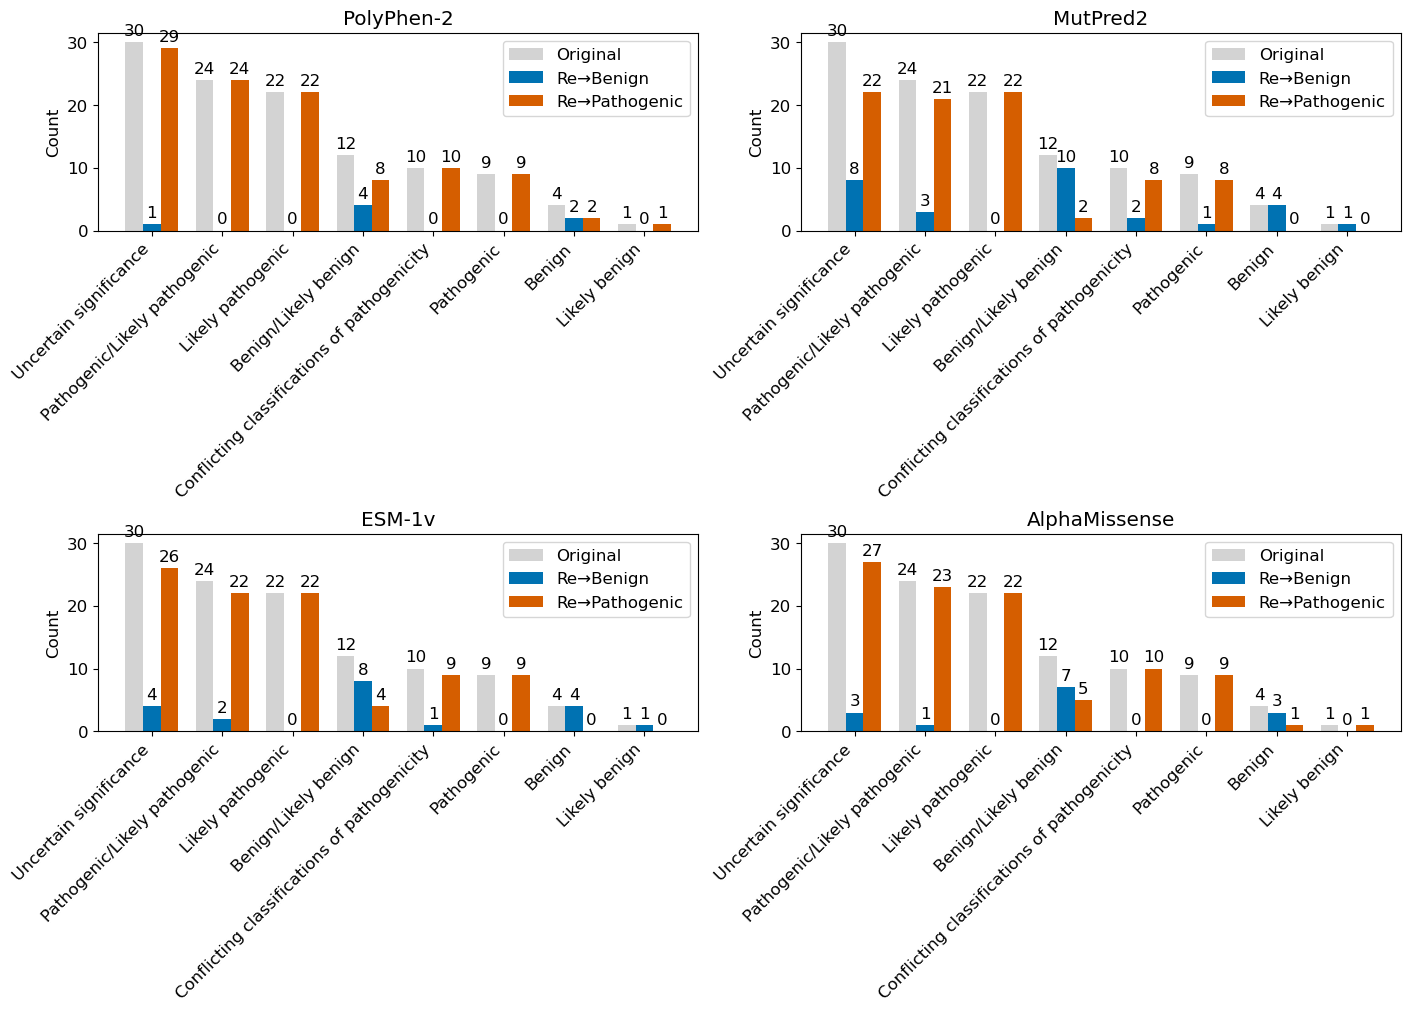

In [30]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# ── Paths ────────────────────────────────────────────────────────────────
root      = "/project/ealexov/compbio/shamrat/250519_energy"
orig_xl   = os.path.join(root, "00_data",
                         "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg.xlsx")
pp2_xl    = os.path.join(root, "05_pathogenicity/01_polyphen2",
                         "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_polyphen2.xlsx")
mp2_xl    = os.path.join(root, "05_pathogenicity/02_mutpred2",
                         "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_classified_mutpred2.xlsx")
esm_xl    = os.path.join(root, "05_pathogenicity/03_esm",
                         "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_esm1v.xlsx")
am_xl     = os.path.join(root, "05_pathogenicity/08_alphamissense",
                         "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_alphamissense.xlsx")

# ── Helper to load & filter positions 1–302 ──────────────────────────────
def load1_302(path):
    df = pd.read_excel(path, engine='openpyxl')
    pos = 'position_x' if 'position_x' in df.columns else 'position'
    return df[df[pos].between(1,302)].copy()

# ── 1) Load original full dataset & filter to 1–302 ──────────────────────
df_orig = load1_302(orig_xl)

# Determine the full ordered list of original classes
orig_order = df_orig['Germline classification'].value_counts().index.tolist()

# ── 2) Prepare binary re-calls for each method ───────────────────────────
df_pp = load1_302(pp2_xl)
df_mp = load1_302(mp2_xl)
df_e  = load1_302(esm_xl)
df_am = load1_302(am_xl)

# PolyPhen-2 binary
df_pp['Recall'] = df_pp['prediction'].str.lower().str.strip()\
    .map(lambda x: 'Benign' if x=='benign' else 'Pathogenic')

# MutPred2 binary
df_mp['Recall'] = df_mp['MutPred2_classification']

# ESM-1v ROC cutoff binary
df_e['true'] = (df_e['Germline classification']!='Benign').astype(int)
fpr, tpr, thr = roc_curve(df_e['true'], -df_e['delta_score'])
cutoff       = -thr[np.argmax(tpr-fpr)]
df_e['Recall'] = df_e['delta_score'].apply(
    lambda x: 'Benign' if x>=cutoff else 'Pathogenic'
)

# AlphaMissense binary
df_am['Recall'] = df_am['am_class'].map(
    lambda x: 'Benign' if x in ['likely_benign','ambiguous'] else 'Pathogenic'
)

methods = {
    'PolyPhen-2': df_pp,
    'MutPred2':   df_mp,
    'ESM-1v':     df_e,
    'AlphaMissense': df_am
}

# ── 3) Plot function ──────────────────────────────────────────────────────
def plot_method(ax, orig_df, new_df, title, orig_order):
    # Cross-tabulate full original vs new binary recall
    ct = pd.crosstab(
        orig_df['Germline classification'],
        new_df['Recall']
    ).reindex(index=orig_order, columns=['Benign','Pathogenic'], fill_value=0)
    
    x = np.arange(len(orig_order))
    w = 0.25
    # Original counts
    orig_counts = orig_df['Germline classification'].value_counts().reindex(orig_order).values
    # Re→Benign & Re→Pathogenic
    rec_b = ct['Benign'].values
    rec_p = ct['Pathogenic'].values
    
    ax.bar(x - w, orig_counts, w, color='lightgray', label='Original')
    ax.bar(x,       rec_b,       w, color='#0072B2', label='Re→Benign')
    ax.bar(x + w,   rec_p,       w, color='#D55E00', label='Re→Pathogenic')
    
    ax.set_xticks(x)
    ax.set_xticklabels(orig_order, rotation=45, ha='right')
    ax.set_ylabel('Count')
    ax.set_title(title)
    ax.legend()
    
    ymax = max(orig_counts.max(), rec_b.max(), rec_p.max())
    for xi, (o,b,p) in enumerate(zip(orig_counts, rec_b, rec_p)):
        ax.text(xi - w, o + ymax*0.02, str(o), ha='center', va='bottom')
        ax.text(xi,     b + ymax*0.02, str(b), ha='center', va='bottom')
        ax.text(xi + w, p + ymax*0.02, str(p), ha='center', va='bottom')


# ── 4) Create 2×2 grid ───────────────────────────────────────────────────
fig, axes = plt.subplots(2, 2, figsize=(14, 10), constrained_layout=True)
axes = axes.flatten()

for ax, (name, dfm) in zip(axes, methods.items()):
    plot_method(ax, df_orig, dfm, name, orig_order)

plt.show()


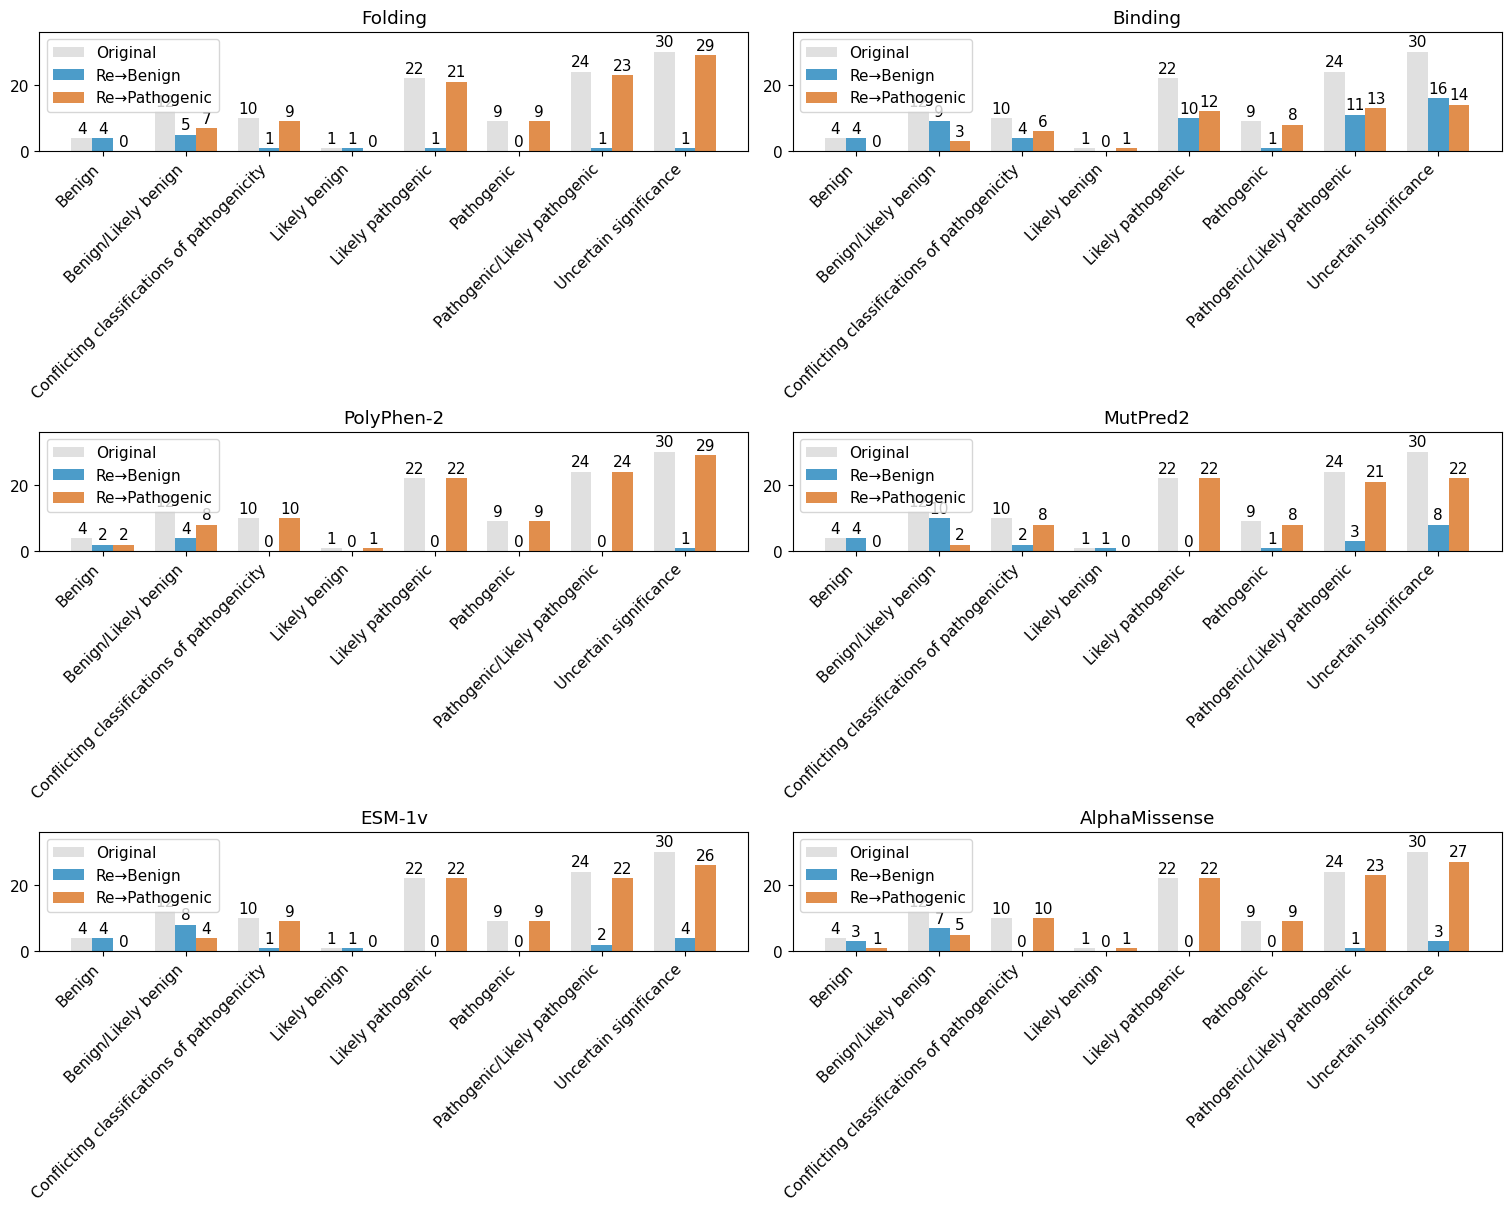

Saved plot to: /project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/all_methods_reclassification.png


In [34]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# ── Paths ─────────────────────────────────────────────────────────────────
root      = "/project/ealexov/compbio/shamrat/250519_energy"
save_path = os.path.join(root, "05_pathogenicity", "all_methods_reclassification.png")

files = {
    'Original':      os.path.join(root, "00_data",
                                  "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg.xlsx"),
    'PolyPhen-2':    os.path.join(root, "05_pathogenicity/01_polyphen2",
                                  "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_polyphen2.xlsx"),
    'MutPred2':      os.path.join(root, "05_pathogenicity/02_mutpred2",
                                  "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_classified_mutpred2.xlsx"),
    'ESM-1v':        os.path.join(root, "05_pathogenicity/03_esm",
                                  "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_esm1v.xlsx"),
    'AlphaMissense': os.path.join(root, "05_pathogenicity/08_alphamissense",
                                  "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_alphamissense.xlsx"),
    'Folding':       os.path.join(root, "02_folding",
                                  "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af.xlsx"),
    'Binding':       os.path.join(root, "04_binding",
                                  "clinvar_1kgp_hector_gaf_final_binding.xlsx")
}

# ── Helper to load & filter positions 1–302 ──────────────────────────────
def load1_302(path):
    df = pd.read_excel(path, engine='openpyxl')
    poscol = 'position_x' if 'position_x' in df.columns else 'position'
    return df[df[poscol].between(1,302)].copy()

# ── Load all dataframes ───────────────────────────────────────────────────
dfs = {name: load1_302(fp) for name, fp in files.items()}

# ── Build alphabetical original class order ──────────────────────────────
orig = dfs['Original']
orig_order = sorted(orig['Germline classification'].unique())

# ── Compute binary "Recall" for each method ───────────────────────────────
# PolyPhen-2
pp2 = dfs['PolyPhen-2']
pp2['Recall'] = pp2['prediction'].str.lower().str.strip() \
    .map(lambda x: 'Benign' if x=='benign' else 'Pathogenic')

# MutPred2
mp2 = dfs['MutPred2']
mp2['Recall'] = mp2['MutPred2_classification']

# ESM-1v (Youden’s J)
es = dfs['ESM-1v']
es['true'] = (es['Germline classification']!='Benign').astype(int)
fpr, tpr, thr = roc_curve(es['true'], -es['delta_score'])
cutoff = -thr[np.argmax(tpr - fpr)]
es['Recall'] = es['delta_score'].apply(lambda x: 'Benign' if x>=cutoff else 'Pathogenic')

# AlphaMissense
am = dfs['AlphaMissense']
am['Recall'] = am['am_class'].map(
    lambda x: 'Benign' if x in ['likely_benign','ambiguous'] else 'Pathogenic'
)

# Folding
fd = dfs['Folding']
fold_str = [c for c in fd.columns if c.endswith('_str') and 'foldx' not in c.lower()]
fd['ddG_Fmax'] = fd[fold_str].abs().max(axis=1)
ben_f = fd[fd['Germline classification']=='Benign']['ddG_Fmax']
pat_f = fd[fd['Germline classification']=='Pathogenic']['ddG_Fmax']
thr_f = (ben_f.max() + pat_f.min())/2
fd['Recall'] = fd['Germline classification']
mask = ~fd['Germline classification'].isin(['Benign','Pathogenic'])
fd.loc[mask & (fd['ddG_Fmax']>=thr_f),'Recall'] = 'Pathogenic'
fd.loc[mask & (fd['ddG_Fmax']< thr_f),'Recall'] = 'Benign'

# Binding
bd = dfs['Binding']
bind_ddg = [c for c in bd.columns if c.startswith('ddg_') and '_str_' in c]
targets  = {"SOX9":"197-202","AMPH1":"290-294","GATAD2A":"97-101","ZNF219":"111-115"}
for g,m in targets.items():
    cols = [c for c in bind_ddg if f"_{g}_" in c and f"_{m}_" in c]
    if cols:
        bd[f"ddG_B_{g}"] = bd[cols].abs().mean(axis=1)
bd['ddG_Bmax'] = bd[[c for c in bd if c.startswith('ddG_B_')]].max(axis=1)
ben_b = bd[bd['Germline classification']=='Benign']['ddG_Bmax']
pat_b = bd[bd['Germline classification']=='Pathogenic']['ddG_Bmax']
thr_b = (ben_b.max() + pat_b.min())/2
bd['Recall'] = bd['Germline classification']
mask = ~bd['Germline classification'].isin(['Benign','Pathogenic'])
bd.loc[mask & (bd['ddG_Bmax']>=thr_b),'Recall'] = 'Pathogenic'
bd.loc[mask & (bd['ddG_Bmax']< thr_b),'Recall'] = 'Benign'

# ── Plotting helper ─────────────────────────────────────────────────────
def plot_grouped(ax, orig_ser, rec_ser, title):
    ct = pd.crosstab(orig_ser, rec_ser) \
           .reindex(index=orig_order, columns=['Benign','Pathogenic'], fill_value=0)
    x = np.arange(len(orig_order))
    w = 0.25
    orig_cnt = orig_ser.value_counts().reindex(orig_order).values
    rb, rp = ct['Benign'].values, ct['Pathogenic'].values

    ax.bar(x - w, orig_cnt,   w, color='lightgray', label='Original', alpha=0.7)
    ax.bar(x,      rb,        w, color='#0072B2', label='Re→Benign', alpha=0.7)
    ax.bar(x + w,  rp,        w, color='#D55E00', label='Re→Pathogenic', alpha=0.7)

    ymax = max(orig_cnt.max(), rb.max(), rp.max())
    ax.set_xticks(x)
    ax.set_xticklabels(orig_order, rotation=45, ha='right')
    ax.set_ylim(0, ymax * 1.2)
    ax.set_title(title)

    for container in ax.containers:
        for rect in container:
            h = rect.get_height()
            ax.text(rect.get_x()+rect.get_width()/2,
                    h + ymax*0.02, str(int(h)),
                    ha='center', va='bottom')

    ax.legend()

# ── Build 3×2 grid and save ──────────────────────────────────────────────
fig, axes = plt.subplots(3, 2, figsize=(15, 12), constrained_layout=True)
axes = axes.flatten()

order = [
    ('Folding',    fd['Recall']),
    ('Binding',    bd['Recall']),
    ('PolyPhen-2', pp2['Recall']),
    ('MutPred2',   mp2['Recall']),
    ('ESM-1v',     es['Recall']),
    ('AlphaMissense', am['Recall'])
]

for ax, (name, series) in zip(axes, order):
    plot_grouped(ax, orig['Germline classification'], series, name)

plt.savefig(save_path, dpi=300)
plt.show()

print("Saved plot to:", save_path)


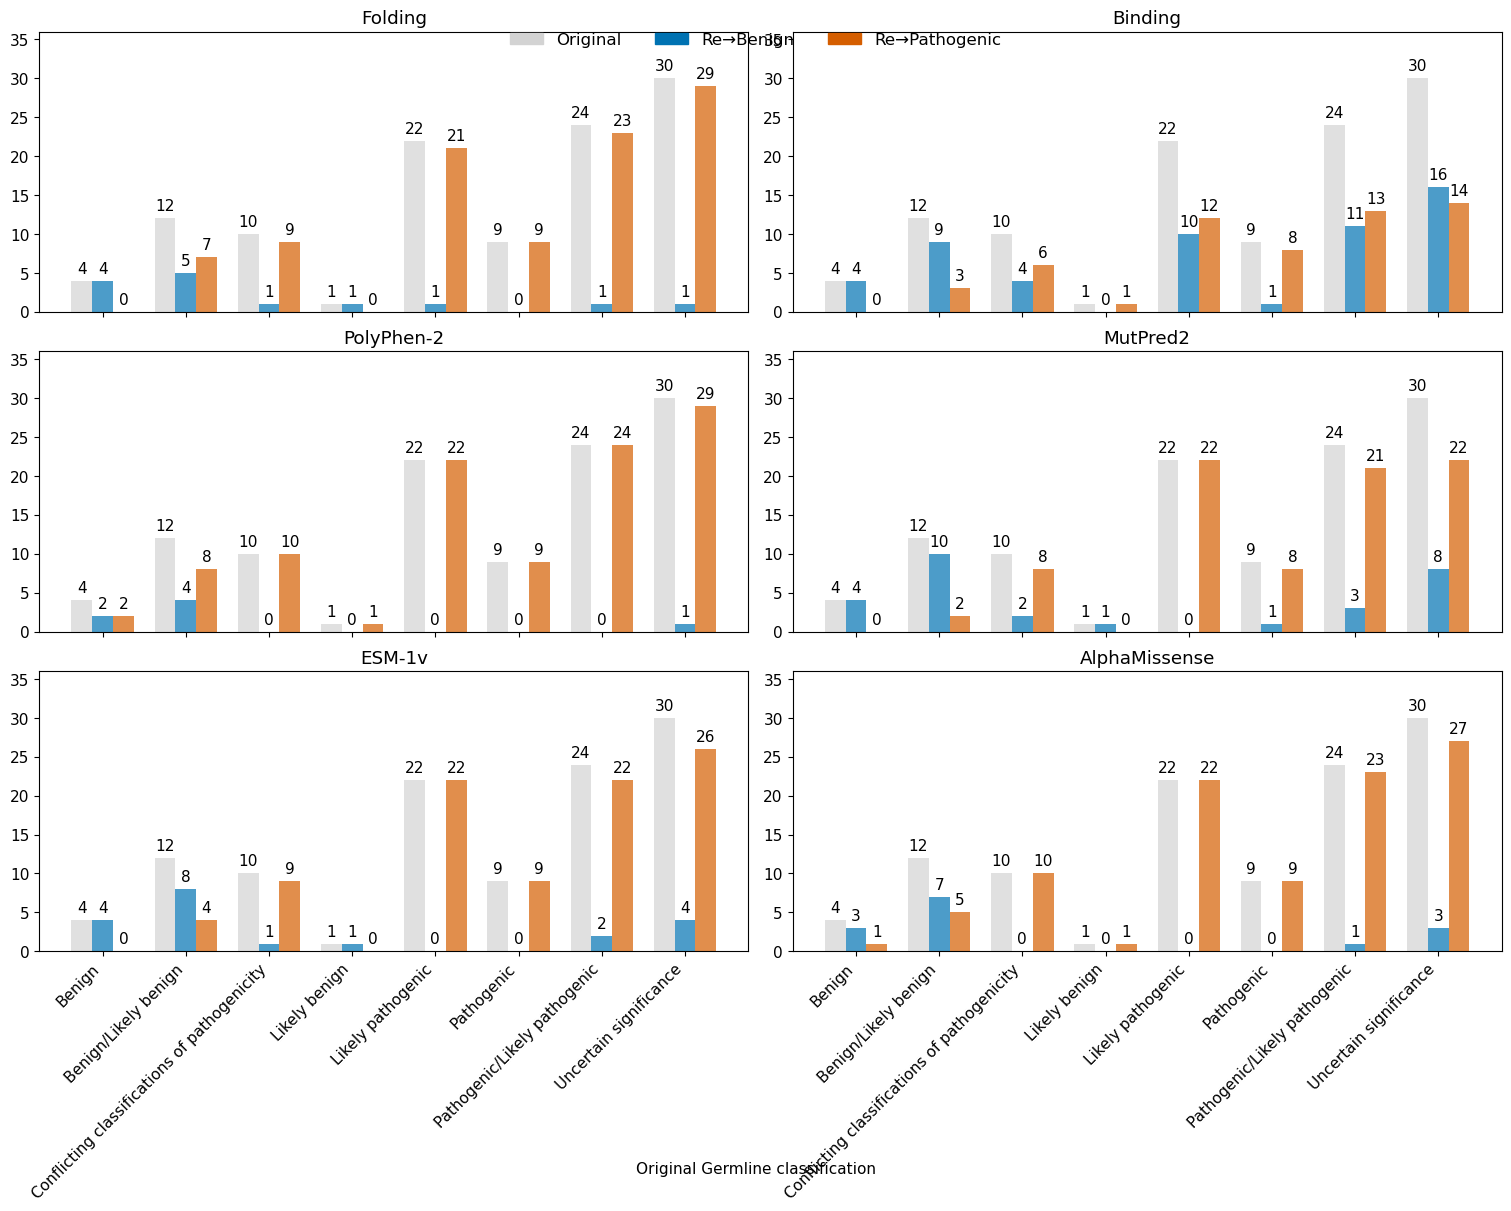

Saved plot to: /project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/all_methods_reclassification.png


In [36]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from matplotlib.patches import Patch

# ── Paths ─────────────────────────────────────────────────────────────────
ROOT      = "/project/ealexov/compbio/shamrat/250519_energy"
SAVE_PATH = os.path.join(ROOT, "05_pathogenicity", "all_methods_reclassification.png")

FILES = {
    'Original':      os.path.join(ROOT, "00_data",
                                  "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg.xlsx"),
    'PolyPhen-2':    os.path.join(ROOT, "05_pathogenicity/01_polyphen2",
                                  "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_polyphen2.xlsx"),
    'MutPred2':      os.path.join(ROOT, "05_pathogenicity/02_mutpred2",
                                  "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_classified_mutpred2.xlsx"),
    'ESM-1v':        os.path.join(ROOT, "05_pathogenicity/03_esm",
                                  "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_esm1v.xlsx"),
    'AlphaMissense': os.path.join(ROOT, "05_pathogenicity/08_alphamissense",
                                  "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_alphamissense.xlsx"),
    'Folding':       os.path.join(ROOT, "02_folding",
                                  "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af.xlsx"),
    'Binding':       os.path.join(ROOT, "04_binding",
                                  "clinvar_1kgp_hector_gaf_final_binding.xlsx")
}

# ── Helper: load & filter positions 1–302 ───────────────────────────────
def load1_302(path):
    df = pd.read_excel(path, engine='openpyxl')
    poscol = 'position_x' if 'position_x' in df.columns else 'position'
    return df[df[poscol].between(1,302)].copy()

# ── Tweak function for figure cosmetics ─────────────────────────────────
def set_tweaks(fig, width=15, height=12, font_size=11, top_margin=0.92):
    fig.set_size_inches(width, height)
    plt.rcParams.update({'font.size': font_size})
    plt.rcParams['figure.subplot.top'] = top_margin

# ── Load and filter all DataFrames ───────────────────────────────────────
dfs = {name: load1_302(fp) for name, fp in FILES.items()}

# ── Alphabetical original class order ────────────────────────────────────
orig_df = dfs['Original']
orig_order = sorted(orig_df['Germline classification'].unique())

# ── Compute binary 'Recall' for each method ───────────────────────────────
# PolyPhen-2
pp2 = dfs['PolyPhen-2']
pp2['Recall'] = pp2['prediction'].str.lower().str.strip()\
                  .map(lambda x: 'Benign' if x=='benign' else 'Pathogenic')

# MutPred2
mp2 = dfs['MutPred2']
mp2['Recall'] = mp2['MutPred2_classification']

# ESM-1v (Youden’s J cutoff)
es = dfs['ESM-1v']
es['true'] = (es['Germline classification']!='Benign').astype(int)
fpr, tpr, thr = roc_curve(es['true'], -es['delta_score'])
cutoff = -thr[np.argmax(tpr - fpr)]
es['Recall'] = es['delta_score'].apply(lambda x: 'Benign' if x>=cutoff else 'Pathogenic')

# AlphaMissense
am = dfs['AlphaMissense']
am['Recall'] = am['am_class'].map(
    lambda x: 'Benign' if x in ['likely_benign','ambiguous'] else 'Pathogenic'
)

# Folding
fd = dfs['Folding']
fold_cols = [c for c in fd.columns if c.endswith('_str') and 'foldx' not in c.lower()]
fd['ddG_Fmax'] = fd[fold_cols].abs().max(axis=1)
ben_f = fd[fd['Germline classification']=='Benign']['ddG_Fmax']
pat_f = fd[fd['Germline classification']=='Pathogenic']['ddG_Fmax']
thr_f = (ben_f.max() + pat_f.min())/2
fd['Recall'] = fd['Germline classification']
mask = ~fd['Germline classification'].isin(['Benign','Pathogenic'])
fd.loc[mask & (fd['ddG_Fmax']>=thr_f), 'Recall'] = 'Pathogenic'
fd.loc[mask & (fd['ddG_Fmax']< thr_f), 'Recall'] = 'Benign'

# Binding
bd = dfs['Binding']
bind_cols = [c for c in bd.columns if c.startswith('ddg_') and '_str_' in c]
targets = {"SOX9":"197-202","AMPH1":"290-294","GATAD2A":"97-101","ZNF219":"111-115"}
for gene, motif in targets.items():
    cols = [c for c in bind_cols if f"_{gene}_" in c and f"_{motif}_" in c]
    if cols:
        bd[f"ddG_B_{gene}"] = bd[cols].abs().mean(axis=1)
bd['ddG_Bmax'] = bd[[c for c in bd if c.startswith('ddG_B_')]].max(axis=1)
ben_b = bd[bd['Germline classification']=='Benign']['ddG_Bmax']
pat_b = bd[bd['Germline classification']=='Pathogenic']['ddG_Bmax']
thr_b = (ben_b.max() + pat_b.min())/2
bd['Recall'] = bd['Germline classification']
mask = ~bd['Germline classification'].isin(['Benign','Pathogenic'])
bd.loc[mask & (bd['ddG_Bmax']>=thr_b), 'Recall'] = 'Pathogenic'
bd.loc[mask & (bd['ddG_Bmax']< thr_b), 'Recall'] = 'Benign'

# ── Grouped-bar plot helper ──────────────────────────────────────────────
def plot_grouped(ax, orig_ser, rec_ser, title):
    ct = pd.crosstab(orig_ser, rec_ser) \
           .reindex(index=orig_order, columns=['Benign','Pathogenic'], fill_value=0)
    x = np.arange(len(orig_order))
    w = 0.25
    orig_cnt = orig_ser.value_counts().reindex(orig_order).values
    rb, rp = ct['Benign'].values, ct['Pathogenic'].values

    ax.bar(x - w, orig_cnt, w, color='lightgray', label='Original', alpha=0.7)
    ax.bar(x,      rb,      w, color='#0072B2', label='Re→Benign', alpha=0.7)
    ax.bar(x + w,  rp,      w, color='#D55E00', label='Re→Pathogenic', alpha=0.7)

    ymax = max(orig_cnt.max(), rb.max(), rp.max())
    ax.set_ylim(0, ymax * 1.2)
    ax.set_title(title)
    for container in ax.containers:
        for rect in container:
            h = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2,
                    h + ymax * 0.02,
                    str(int(h)), ha='center', va='bottom')

# ── Build 3×2 grid and save ───────────────────────────────────────────────
fig, axes = plt.subplots(3, 2, figsize=(15, 12), sharex=True, constrained_layout=True)
set_tweaks(fig, width=15, height=12, font_size=11, top_margin=0.92)
axes = axes.flatten()

sequence = [
    ('Folding',       fd['Recall']),
    ('Binding',       bd['Recall']),
    ('PolyPhen-2',    pp2['Recall']),
    ('MutPred2',      mp2['Recall']),
    ('ESM-1v',        es['Recall']),
    ('AlphaMissense', am['Recall'])
]

for ax, (name, series) in zip(axes, sequence):
    plot_grouped(ax, orig_df['Germline classification'], series, name)
    if ax.get_subplotspec().is_last_row():
        ax.set_xticks(np.arange(len(orig_order)))
        ax.set_xticklabels(orig_order, rotation=45, ha='right')
    else:
        ax.set_xticklabels([])

# ── Shared legend ────────────────────────────────────────────────────────
handles = [
    Patch(color='lightgray', label='Original'),
    Patch(color='#0072B2',    label='Re→Benign'),
    Patch(color='#D55E00',    label='Re→Pathogenic')
]
fig.legend(handles=handles, loc='upper center', ncol=3, frameon=False,
           fontsize=12, bbox_to_anchor=(0.5, 0.99))

# ── Common X label ───────────────────────────────────────────────────────
fig.text(0.5, 0.03, 'Original Germline classification', ha='center', va='center')

# ── Save & show ─────────────────────────────────────────────────────────
plt.savefig(SAVE_PATH, dpi=300, bbox_inches='tight')
plt.show()

print("Saved plot to:", SAVE_PATH)


# 250717: Pathogenicity

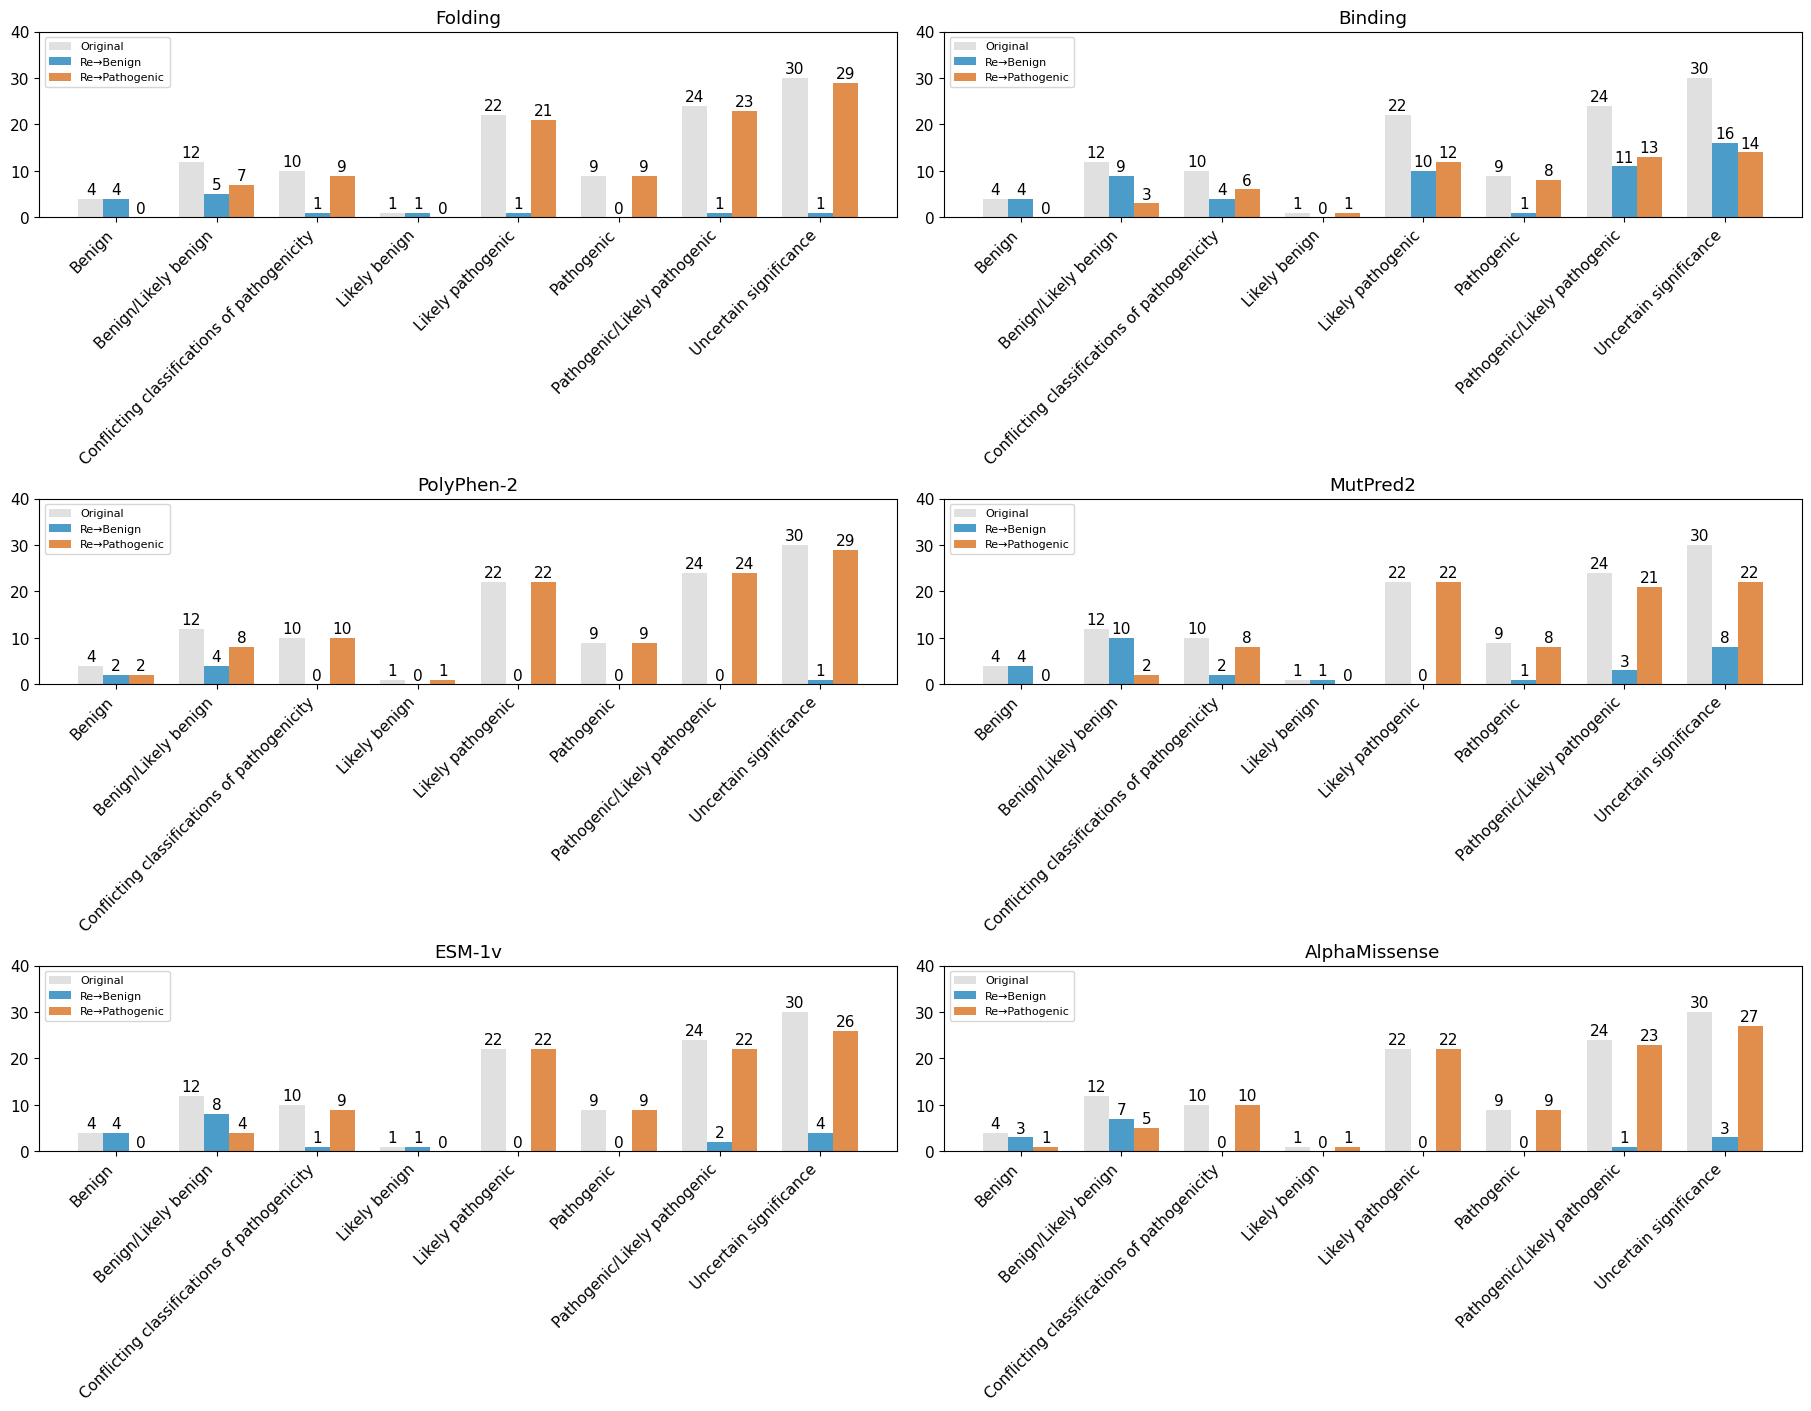

Saved plot to: /project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/all_methods_reclassification.png


In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# ── Paths ─────────────────────────────────────────────────────────────────
root      = "/project/ealexov/compbio/shamrat/250519_energy"
save_path = os.path.join(root, "05_pathogenicity", "all_methods_reclassification.png")

files = {
    'Original':      os.path.join(root, "00_data",
                                  "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg.xlsx"),
    'PolyPhen-2':    os.path.join(root, "05_pathogenicity/01_polyphen2",
                                  "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_polyphen2.xlsx"),
    'MutPred2':      os.path.join(root, "05_pathogenicity/02_mutpred2",
                                  "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_classified_mutpred2.xlsx"),
    'ESM-1v':        os.path.join(root, "05_pathogenicity/03_esm",
                                  "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_esm1v.xlsx"),
    'AlphaMissense': os.path.join(root, "05_pathogenicity/08_alphamissense",
                                  "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_alphamissense.xlsx"),
    'Folding':       os.path.join(root, "02_folding",
                                  "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af.xlsx"),
    'Binding':       os.path.join(root, "04_binding",
                                  "clinvar_1kgp_hector_gaf_final_binding.xlsx")
}

# ── Helper to load & filter positions 1–302 ──────────────────────────────
def load1_302(path):
    df = pd.read_excel(path, engine='openpyxl')
    poscol = 'position_x' if 'position_x' in df.columns else 'position'
    return df[df[poscol].between(1,302)].copy()

# ── Load all dataframes ───────────────────────────────────────────────────
dfs = {name: load1_302(fp) for name, fp in files.items()}

# ── Build alphabetical original class order ──────────────────────────────
orig = dfs['Original']
orig_order = sorted(orig['Germline classification'].unique())

# ── Compute binary "Recall" for each method ───────────────────────────────
# PolyPhen-2
pp2 = dfs['PolyPhen-2']
pp2['Recall'] = pp2['prediction'].str.lower().str.strip() \
    .map(lambda x: 'Benign' if x=='benign' else 'Pathogenic')

# MutPred2
mp2 = dfs['MutPred2']
mp2['Recall'] = mp2['MutPred2_classification']

# ESM-1v (Youden’s J)
es = dfs['ESM-1v']
es['true'] = (es['Germline classification']!='Benign').astype(int)
fpr, tpr, thr = roc_curve(es['true'], -es['delta_score'])
cutoff = -thr[np.argmax(tpr - fpr)]
es['Recall'] = es['delta_score'].apply(lambda x: 'Benign' if x>=cutoff else 'Pathogenic')

# AlphaMissense
am = dfs['AlphaMissense']
am['Recall'] = am['am_class'].map(
    lambda x: 'Benign' if x in ['likely_benign','ambiguous'] else 'Pathogenic'
)

# Folding
fd = dfs['Folding']
fold_str = [c for c in fd.columns if c.endswith('_str') and 'foldx' not in c.lower()]
fd['ddG_Fmax'] = fd[fold_str].abs().max(axis=1)
ben_f = fd[fd['Germline classification']=='Benign']['ddG_Fmax']
pat_f = fd[fd['Germline classification']=='Pathogenic']['ddG_Fmax']
thr_f = (ben_f.max() + pat_f.min())/2
fd['Recall'] = fd['Germline classification']
mask = ~fd['Germline classification'].isin(['Benign','Pathogenic'])
fd.loc[mask & (fd['ddG_Fmax']>=thr_f),'Recall'] = 'Pathogenic'
fd.loc[mask & (fd['ddG_Fmax']< thr_f),'Recall']  = 'Benign'

# Binding
bd = dfs['Binding']
bind_ddg = [c for c in bd.columns if c.startswith('ddg_') and '_str_' in c]
targets  = {"SOX9":"197-202","AMPH1":"290-294","GATAD2A":"97-101","ZNF219":"111-115"}
for g,m in targets.items():
    cols = [c for c in bind_ddg if f"_{g}_" in c and f"_{m}_" in c]
    if cols:
        bd[f"ddG_B_{g}"] = bd[cols].abs().mean(axis=1)
bd['ddG_Bmax'] = bd[[c for c in bd if c.startswith('ddG_B_')]].max(axis=1)
ben_b = bd[bd['Germline classification']=='Benign']['ddG_Bmax']
pat_b = bd[bd['Germline classification']=='Pathogenic']['ddG_Bmax']
thr_b = (ben_b.max() + pat_b.min())/2
bd['Recall'] = bd['Germline classification']
mask = ~bd['Germline classification'].isin(['Benign','Pathogenic'])
bd.loc[mask & (bd['ddG_Bmax']>=thr_b),'Recall'] = 'Pathogenic'
bd.loc[mask & (bd['ddG_Bmax']< thr_b),'Recall']  = 'Benign'

# ── Plotting helper ─────────────────────────────────────────────────────
def plot_grouped(ax, orig_ser, rec_ser, title):
    ct = pd.crosstab(orig_ser, rec_ser) \
           .reindex(index=orig_order, columns=['Benign','Pathogenic'], fill_value=0)
    x  = np.arange(len(orig_order))
    w  = 0.25
    orig_cnt = orig_ser.value_counts().reindex(orig_order).values
    rb, rp   = ct['Benign'].values, ct['Pathogenic'].values

    ax.bar(x - w, orig_cnt, w, color='lightgray', label='Original', alpha=0.7)
    ax.bar(x,      rb,      w, color='#0072B2', label='Re→Benign', alpha=0.7)
    ax.bar(x + w,  rp,      w, color='#D55E00', label='Re→Pathogenic', alpha=0.7)

    # annotate bars
    ymax = max(orig_cnt.max(), rb.max(), rp.max())
    for container in ax.containers:
        for rect in container:
            h = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2,
                    h + ymax * 0.01,
                    str(int(h)),
                    ha='center', va='bottom')

    ax.set_title(title)
    ax.legend(fontsize=8)

# ── Tweak function ───────────────────────────────────────────────────────
def tweak_fig(fig, axes,
              fig_width=15, fig_height=12,
              font_size=11, y_max=None):
    """
    fig_width, fig_height : figure size in inches
    font_size            : global font size
    y_max                : common y-axis upper limit (None to autoscale)
    """
    fig.set_size_inches(fig_width, fig_height)
    plt.rcParams.update({'font.size': font_size})
    for ax in axes:
        if y_max is not None:
            ax.set_ylim(0, y_max)

# ── Build 3×2 grid and save ──────────────────────────────────────────────
fig, axes = plt.subplots(3, 2, constrained_layout=True)
axes = axes.flatten()

order = [
    ('Folding',      fd['Recall']),
    ('Binding',      bd['Recall']),
    ('PolyPhen-2',   pp2['Recall']),
    ('MutPred2',     mp2['Recall']),
    ('ESM-1v',       es['Recall']),
    ('AlphaMissense',am['Recall'])
]

for ax, (name, series) in zip(axes, order):
    plot_grouped(ax, orig['Germline classification'], series, name)
    ax.set_xticks(np.arange(len(orig_order)))
    ax.set_xticklabels(orig_order, rotation=45, ha='right')

# ── apply tweaks ────────────────────────────────────────────────────────
# e.g. set font=12, fig size=18×14, and force y-axis to 40
tweak_fig(fig, axes,
          fig_width=18, fig_height=14,
          font_size=12,
          y_max=40)

# ── Save & show ─────────────────────────────────────────────────────────
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

print("Saved plot to:", save_path)


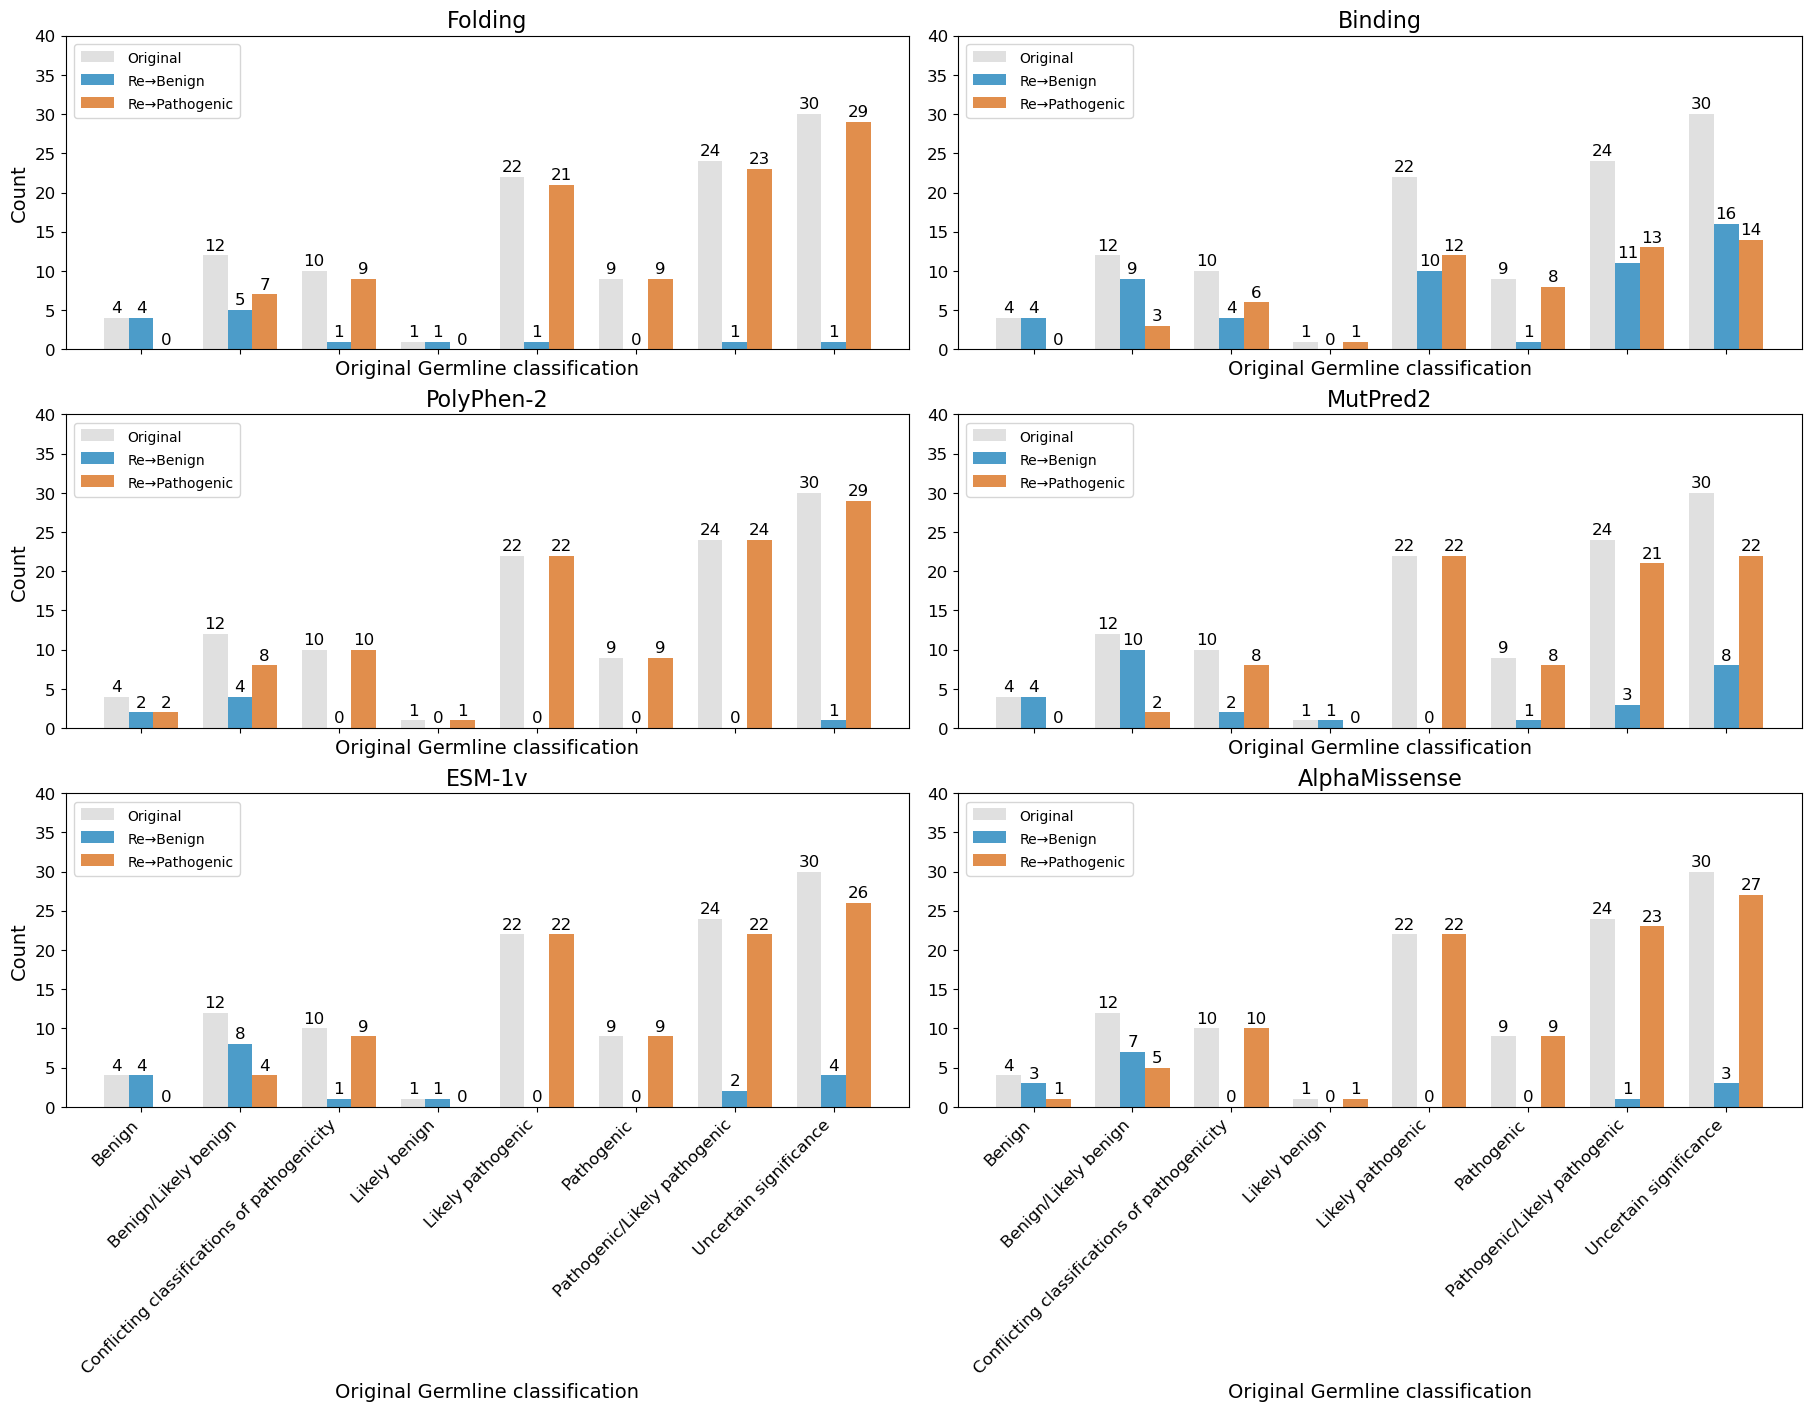

Saved plot to: /project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/all_methods_reclassification.png


In [12]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# ── Paths ─────────────────────────────────────────────────────────────────
root      = "/project/ealexov/compbio/shamrat/250519_energy"
save_path = os.path.join(root, "05_pathogenicity", "all_methods_reclassification.png")

files = {
    'Original':      os.path.join(root, "00_data",
                                  "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg.xlsx"),
    'PolyPhen-2':    os.path.join(root, "05_pathogenicity/01_polyphen2",
                                  "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_polyphen2.xlsx"),
    'MutPred2':      os.path.join(root, "05_pathogenicity/02_mutpred2",
                                  "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_classified_mutpred2.xlsx"),
    'ESM-1v':        os.path.join(root, "05_pathogenicity/03_esm",
                                  "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_esm1v.xlsx"),
    'AlphaMissense': os.path.join(root, "05_pathogenicity/08_alphamissense",
                                  "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_alphamissense.xlsx"),
    'Folding':       os.path.join(root, "02_folding",
                                  "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af.xlsx"),
    'Binding':       os.path.join(root, "04_binding",
                                  "clinvar_1kgp_hector_gaf_final_binding.xlsx")
}

# ── Helper to load & filter positions 1–302 ──────────────────────────────
def load1_302(path):
    df = pd.read_excel(path, engine='openpyxl')
    poscol = 'position_x' if 'position_x' in df.columns else 'position'
    return df[df[poscol].between(1,302)].copy()

# ── Load all dataframes ───────────────────────────────────────────────────
dfs = {name: load1_302(fp) for name, fp in files.items()}

# ── Build alphabetical original class order ──────────────────────────────
orig = dfs['Original']
orig_order = sorted(orig['Germline classification'].unique())

# ── Compute binary "Recall" for each method ───────────────────────────────
# … same as before for pp2, mp2, es, am, fd, bd …

# ── Plotting helper ─────────────────────────────────────────────────────
def plot_grouped(ax, orig_ser, rec_ser, title):
    ct = pd.crosstab(orig_ser, rec_ser) \
           .reindex(index=orig_order, columns=['Benign','Pathogenic'], fill_value=0)
    x        = np.arange(len(orig_order))
    w        = 0.25
    orig_cnt = orig_ser.value_counts().reindex(orig_order).values
    rb, rp   = ct['Benign'].values, ct['Pathogenic'].values

    ax.bar(x - w, orig_cnt, w, color='lightgray', label='Original', alpha=0.7)
    ax.bar(x,      rb,      w, color='#0072B2', label='Re→Benign', alpha=0.7)
    ax.bar(x + w,  rp,      w, color='#D55E00', label='Re→Pathogenic', alpha=0.7)

    # annotate
    ymax = max(orig_cnt.max(), rb.max(), rp.max())
    for container in ax.containers:
        for rect in container:
            h = rect.get_height()
            ax.text(rect.get_x()+rect.get_width()/2,
                    h + ymax*0.01,
                    str(int(h)),
                    ha='center', va='bottom')

    ax.set_title(title)
    ax.legend(loc='upper left')

# ── Decoration tweak function ────────────────────────────────────────────
def tweak_all(fig, axes,
              fig_size=(15,12),
              title_fs=14,
              label_fs=12,
              tick_fs=10,
              legend_fs=10,
              x_label=None,
              y_label=None,
              y_max=None,
              y_step=None):
    """
    Applies global styling:
      fig_size  : (width, height) in inches
      title_fs  : font size for subplot titles
      label_fs  : font size for axis labels and annotations
      tick_fs   : font size for tick labels
      legend_fs : font size for legend text
      x_label   : common x-axis label (string or None)
      y_label   : common y-axis label (string or None)
      y_max     : max y-limit per subplot (None=auto)
      y_step    : y-tick interval (None=default)
    """
    fig.set_size_inches(*fig_size)
    for ax in axes:
        # titles
        ax.title.set_fontsize(title_fs)
        # axis labels
        if x_label:
            ax.set_xlabel(x_label, fontsize=label_fs)
        if y_label and ax.get_subplotspec().colspan.start == 0:
            ax.set_ylabel(y_label, fontsize=label_fs)
        # ticks
        ax.tick_params(axis='both', labelsize=tick_fs)
        # legend
        leg = ax.get_legend()
        if leg:
            for txt in leg.get_texts():
                txt.set_fontsize(legend_fs)
        # y limits & ticks
        if y_max is not None:
            ax.set_ylim(0, y_max)
        if (y_max is not None) and (y_step is not None):
            ax.set_yticks(np.arange(0, y_max+1, y_step))

# ── Build 3×2 grid (no shared y) ────────────────────────────────────────
fig, axes = plt.subplots(3, 2,
                         sharex=True,
                         constrained_layout=True)
axes = axes.flatten()

order = [
    ('Folding',      fd['Recall']),
    ('Binding',      bd['Recall']),
    ('PolyPhen-2',   pp2['Recall']),
    ('MutPred2',     mp2['Recall']),
    ('ESM-1v',       es['Recall']),
    ('AlphaMissense',am['Recall'])
]

for ax, (name, series) in zip(axes, order):
    plot_grouped(ax, orig['Germline classification'], series, name)
    # only bottom row: x-ticks/labels
    if not ax.get_subplotspec().is_last_row():
        ax.set_xticklabels([])
    else:
        ax.set_xticks(np.arange(len(orig_order)))
        ax.set_xticklabels(orig_order, rotation=45, ha='right')

# apply all tweaks at once
tweak_all(fig, axes,
          fig_size=(18,14),
          title_fs=16,
          label_fs=14,
          tick_fs=12,
          legend_fs=10,
          x_label='Original Germline classification',
          y_label='Count',
          y_max=40,
          y_step=5)

# ── Save & show ─────────────────────────────────────────────────────────
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

print("Saved plot to:", save_path)


In [23]:
import pandas as pd

# load your AlphaMissense df as before
alpha_path = (
    "/project/ealexov/compbio/shamrat/250519_energy/"
    "05_pathogenicity/08_alphamissense/"
    "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_alphamissense.xlsx"
)
df_am = pd.read_excel(alpha_path, engine='openpyxl')

# define cutoffs (mid‐points of the observed gaps)
cut_ben_amb = (0.3117 + 0.4848) / 2  # ≈0.3983
cut_amb_path = (0.5298 + 0.6003) / 2 # ≈0.5651

# select only the ambiguous calls
amb = df_am[df_am['am_class'] == 'ambiguous']['am_pathogenicity']

# print their range
print(f"Ambiguous scores range from {amb.min():.4f} to {amb.max():.4f}")

# check they all lie within the cutoffs
mask = (amb > cut_ben_amb) & (amb < cut_amb_path)
print("All ambiguous within (%.4f, %.4f)? %s" %
      (cut_ben_amb, cut_amb_path, mask.all()))

# if you want to see any that fall outside:
outliers = amb[~mask]
if not outliers.empty:
    print("Outliers:", outliers.tolist())


Ambiguous scores range from 0.4848 to 0.5298
All ambiguous within (0.3982, 0.5651)? True


In [53]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve
from IPython.display import display

# ── Paths ─────────────────────────────────────────────────────────────────
root = "/project/ealexov/compbio/shamrat/250519_energy"
files = {
    'Original':      os.path.join(root, "00_data",
                                 "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg.xlsx"),
    'PolyPhen-2':    os.path.join(root, "05_pathogenicity/01_polyphen2",
                                 "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_polyphen2.xlsx"),
    'MutPred2':      os.path.join(root, "05_pathogenicity/02_mutpred2",
                                 "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_classified_mutpred2.xlsx"),
    'ESM-1v':        os.path.join(root, "05_pathogenicity/03_esm",
                                 "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_esm1v.xlsx"),
    'AlphaMissense': os.path.join(root, "05_pathogenicity/08_alphamissense",
                                 "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_alphamissense.xlsx"),
    'Folding':       os.path.join(root, "02_folding",
                                 "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af.xlsx"),
    'Binding':       os.path.join(root, "04_binding",
                                 "clinvar_1kgp_hector_gaf_final_binding.xlsx")
}

def load_and_filter(path):
    df = pd.read_excel(path, engine='openpyxl')
    poscol = 'position_x' if 'position_x' in df.columns else 'position'
    return df[df[poscol].between(1,302)].copy()

# 1) Load data
dfs = {name: load_and_filter(fp) for name, fp in files.items()}

# 2) Compute 'After' counts as before
summary = []
for name, df in dfs.items():
    if name == 'Original':
        rec = df['Germline classification']
    elif name == 'PolyPhen-2':
        rec = df['prediction'].str.lower().str.strip().map(lambda x: 'Benign' if x=='benign' else 'Pathogenic')
    elif name == 'MutPred2':
        rec = df['MutPred2_classification']
    elif name == 'ESM-1v':
        true = (df['Germline classification']!='Benign').astype(int)
        fpr, tpr, thr = roc_curve(true, -df['delta_score'])
        cutoff = -thr[np.argmax(tpr - fpr)]
        rec = df['delta_score'].apply(lambda x: 'Benign' if x>=cutoff else 'Pathogenic')
    elif name == 'Folding':
        fold_cols = [c for c in df.columns if c.endswith('_str') and 'foldx' not in c.lower()]
        df['ddG_Fmax'] = df[fold_cols].abs().max(axis=1)
        ben_f = df[df['Germline classification']=='Benign']['ddG_Fmax']
        pat_f = df[df['Germline classification']=='Pathogenic']['ddG_Fmax']
        cutoff = (ben_f.max() + pat_f.min())/2
        rec = df['Germline classification'].copy()
        mask = ~df['Germline classification'].isin(['Benign','Pathogenic'])
        rec.loc[mask & (df['ddG_Fmax']>=cutoff)] = 'Pathogenic'
        rec.loc[mask & (df['ddG_Fmax']< cutoff)] = 'Benign'
    elif name == 'Binding':
        bind_cols = [c for c in df.columns if c.startswith('ddg_') and '_str_' in c]
        targets = {"SOX9":"197-202","AMPH1":"290-294","GATAD2A":"97-101","ZNF219":"111-115"}
        for gene, motif in targets.items():
            cols = [c for c in bind_cols if f"_{gene}_" in c and f"_{motif}_" in c]
            if cols:
                df[f"ddG_B_{gene}"] = df[cols].abs().mean(axis=1)
        df['ddG_Bmax'] = df[[c for c in df if c.startswith('ddG_B_')]].max(axis=1)
        ben_b = df[df['Germline classification']=='Benign']['ddG_Bmax']
        pat_b = df[df['Germline classification']=='Pathogenic']['ddG_Bmax']
        cutoff = (ben_b.max() + pat_b.min())/2
        rec = df['Germline classification'].copy()
        mask = ~df['Germline classification'].isin(['Benign','Pathogenic'])
        rec.loc[mask & (df['ddG_Bmax']>=cutoff)] = 'Pathogenic'
        rec.loc[mask & (df['ddG_Bmax']< cutoff)] = 'Benign'
    elif name == 'AlphaMissense':
        rec = df['am_class'].map(lambda x: 'Benign' if x in ['likely_benign','ambiguous'] else 'Pathogenic')
        full = pd.read_excel(files['AlphaMissense'], engine='openpyxl')
        amb = full[full['am_class']=='ambiguous']['am_pathogenicity']
        patf= full[full['am_class']=='likely_pathogenic']['am_pathogenicity']
        thr_am = (amb.max()+patf.min())/2
        mask = df['am_class']=='ambiguous'
        rec.loc[mask] = df.loc[mask,'am_pathogenicity'].apply(lambda s: 'Benign' if s<thr_am else 'Pathogenic')
    b_counts = rec.value_counts().to_dict()
    summary.append({'Method': name,
                    'Post-Benign Count': b_counts.get('Benign', 0),
                    'Post-Pathogenic Count': b_counts.get('Pathogenic', 0)})

# Build DataFrame
df_after = pd.DataFrame(summary).set_index('Method')

# Rename Original
df_after = df_after.rename(index={'Original': 'Germline classification'})

# Order rows: Germline classification, Folding, Binding, then alphabetical
others = [m for m in df_after.index if m not in ['Germline classification','Folding','Binding']]
others.sort()
order = ['Germline classification','Folding','Binding'] + others
df_after = df_after.loc[order]

display(df_after)


,Post-Benign Count,Post-Pathogenic Count
Method,,
Germline classification,4,9
Folding,14,98
Binding,55,57
AlphaMissense,14,98
ESM-1v,20,92
MutPred2,29,83
PolyPhen-2,7,105


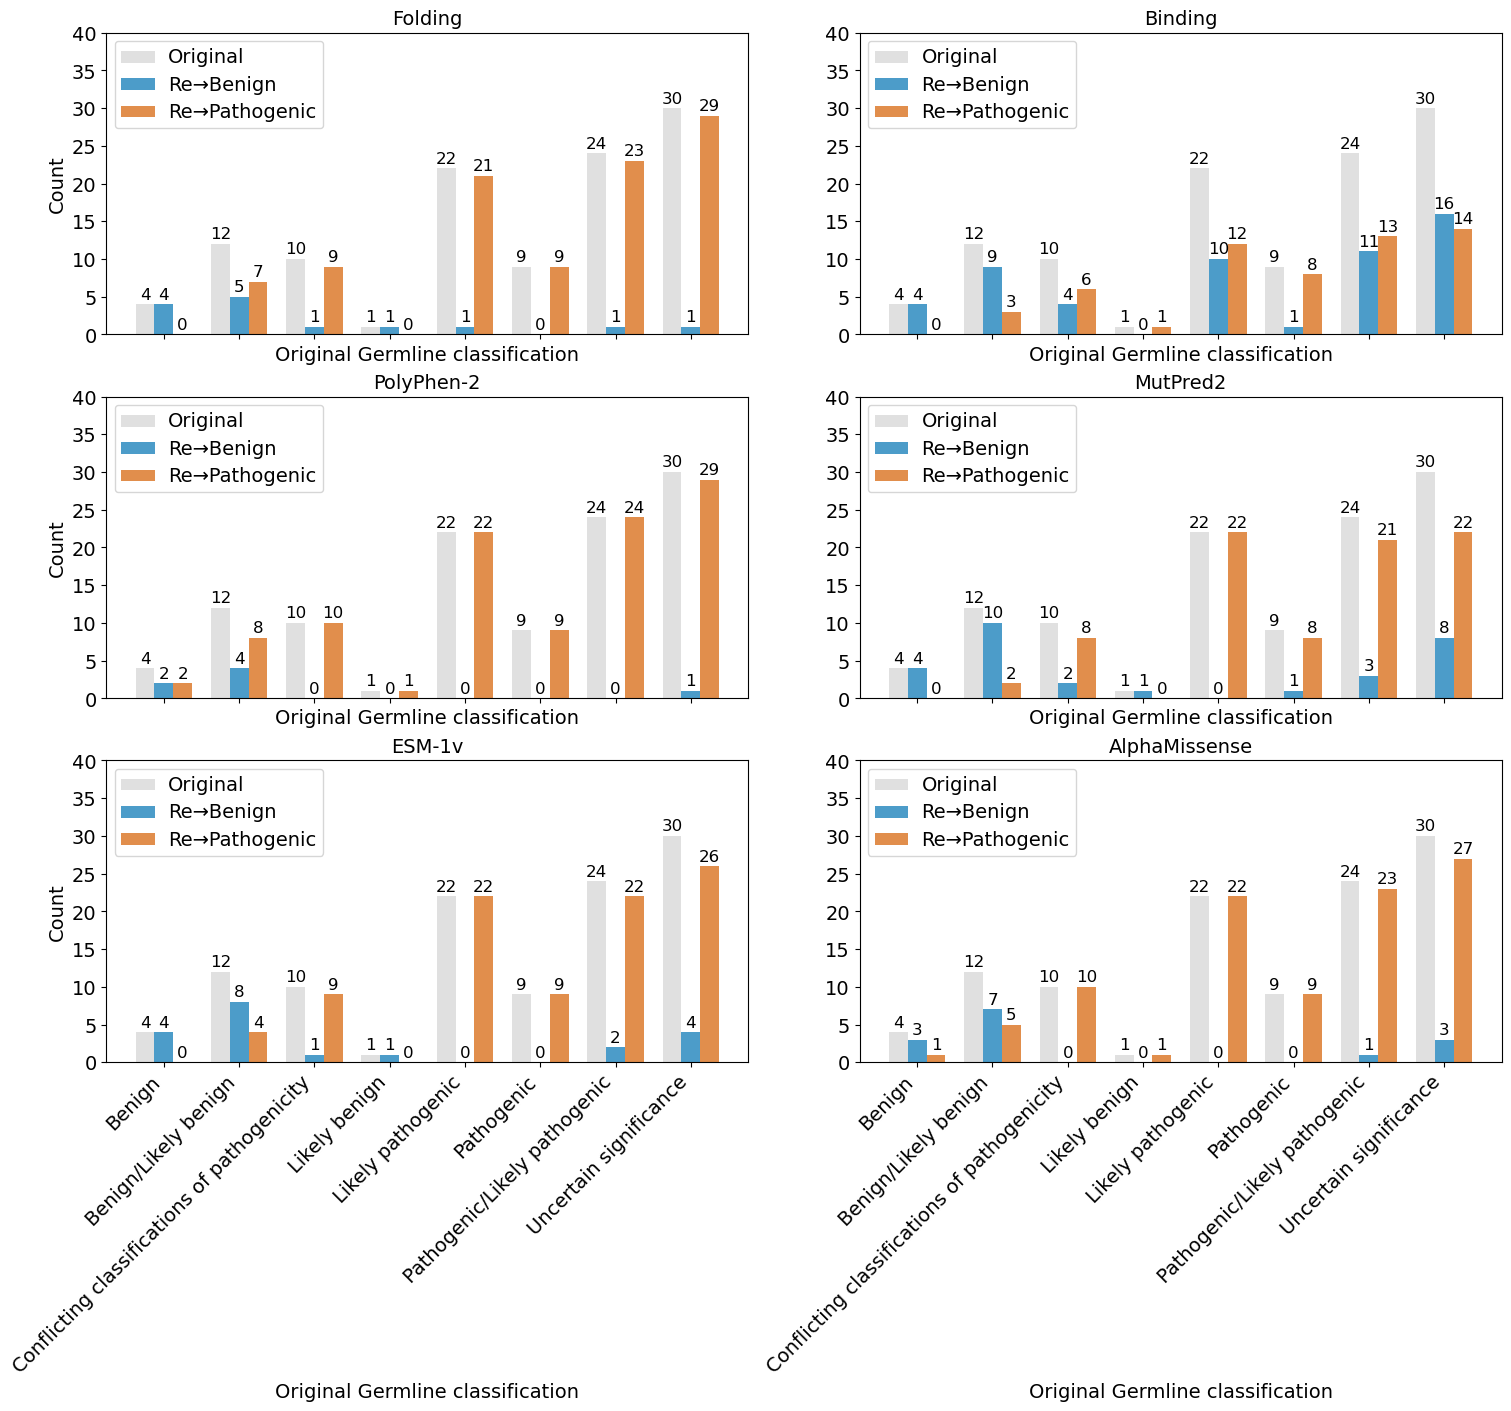

Saved plot to: /project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/all_methods_reclassification.png


In [38]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# ── Paths ─────────────────────────────────────────────────────────────────
root      = "/project/ealexov/compbio/shamrat/250519_energy"
save_path = os.path.join(root, "05_pathogenicity", "all_methods_reclassification.png")

files = {
    'Original':      os.path.join(root, "00_data",
                                  "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg.xlsx"),
    'PolyPhen-2':    os.path.join(root, "05_pathogenicity/01_polyphen2",
                                  "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_polyphen2.xlsx"),
    'MutPred2':      os.path.join(root, "05_pathogenicity/02_mutpred2",
                                  "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_classified_mutpred2.xlsx"),
    'ESM-1v':        os.path.join(root, "05_pathogenicity/03_esm",
                                  "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_esm1v.xlsx"),
    'AlphaMissense': os.path.join(root, "05_pathogenicity/08_alphamissense",
                                  "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_alphamissense.xlsx"),
    'Folding':       os.path.join(root, "02_folding",
                                  "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af.xlsx"),
    'Binding':       os.path.join(root, "04_binding",
                                  "clinvar_1kgp_hector_gaf_final_binding.xlsx")
}

# ── Helper to load & filter positions 1–302 ──────────────────────────────
def load1_302(path):
    df = pd.read_excel(path, engine='openpyxl')
    poscol = 'position_x' if 'position_x' in df.columns else 'position'
    return df[df[poscol].between(1,302)].copy()

# ── Load all dataframes (positions 1–302 only) ─────────────────────────────
dfs = {name: load1_302(fp) for name, fp in files.items()}

# ── Build alphabetical original class order ──────────────────────────────
orig = dfs['Original']
orig_order = sorted(orig['Germline classification'].unique())

# ── Compute binary "Recall" for each method ───────────────────────────────

# PolyPhen-2
pp2 = dfs['PolyPhen-2']
pp2['Recall'] = pp2['prediction'].str.lower().str.strip() \
    .map(lambda x: 'Benign' if x=='benign' else 'Pathogenic')

# MutPred2
mp2 = dfs['MutPred2']
mp2['Recall'] = mp2['MutPred2_classification']

# ESM-1v (Youden’s J cutoff)
es = dfs['ESM-1v']
es['true'] = (es['Germline classification']!='Benign').astype(int)
fpr, tpr, thr = roc_curve(es['true'], -es['delta_score'])
cutoff_es = -thr[np.argmax(tpr - fpr)]
es['Recall'] = es['delta_score'].apply(lambda x: 'Benign' if x>=cutoff_es else 'Pathogenic')

# Folding
fd = dfs['Folding']
fold_cols = [c for c in fd.columns if c.endswith('_str') and 'foldx' not in c.lower()]
fd['ddG_Fmax'] = fd[fold_cols].abs().max(axis=1)
ben_f = fd[fd['Germline classification']=='Benign']['ddG_Fmax']
pat_f = fd[fd['Germline classification']=='Pathogenic']['ddG_Fmax']
cutoff_f = (ben_f.max() + pat_f.min())/2
fd['Recall'] = fd['Germline classification']
mask_f = ~fd['Germline classification'].isin(['Benign','Pathogenic'])
fd.loc[mask_f & (fd['ddG_Fmax']>=cutoff_f), 'Recall'] = 'Pathogenic'
fd.loc[mask_f & (fd['ddG_Fmax']< cutoff_f), 'Recall'] = 'Benign'

# Binding
bd = dfs['Binding']
bind_cols = [c for c in bd.columns if c.startswith('ddg_') and '_str_' in c]
targets = {"SOX9":"197-202","AMPH1":"290-294","GATAD2A":"97-101","ZNF219":"111-115"}
for gene, motif in targets.items():
    cols = [c for c in bind_cols if f"_{gene}_" in c and f"_{motif}_" in c]
    if cols:
        bd[f"ddG_B_{gene}"] = bd[cols].abs().mean(axis=1)
bd['ddG_Bmax'] = bd[[c for c in bd if c.startswith('ddG_B_')]].max(axis=1)
ben_b = bd[bd['Germline classification']=='Benign']['ddG_Bmax']
pat_b = bd[bd['Germline classification']=='Pathogenic']['ddG_Bmax']
cutoff_b = (ben_b.max() + pat_b.min())/2
bd['Recall'] = bd['Germline classification']
mask_b = ~bd['Germline classification'].isin(['Benign','Pathogenic'])
bd.loc[mask_b & (bd['ddG_Bmax']>=cutoff_b), 'Recall'] = 'Pathogenic'
bd.loc[mask_b & (bd['ddG_Bmax']< cutoff_b), 'Recall'] = 'Benign'

# AlphaMissense: reclassify "ambiguous" within 1–302 using full‐dataset cutoff
# 1) compute cutoff from full sheet
full_am = pd.read_excel(files['AlphaMissense'], engine='openpyxl')
amb_full = full_am[full_am['am_class']=='ambiguous']['am_pathogenicity']
pat_full = full_am[full_am['am_class']=='likely_pathogenic']['am_pathogenicity']
thr_am = (amb_full.max() + pat_full.min()) / 2  # ≈ 0.5651

# 2) load the 1–302 slice
am = dfs['AlphaMissense']
# initial binary Recall map: benign vs pathogenic
am['Recall'] = am['am_class'].map(
    lambda x: 'Benign' if x in ['likely_benign','ambiguous'] else 'Pathogenic'
)
# 3) reclassify ambiguous in positions 1–302
mask_am = (am['am_class']=='ambiguous')
am.loc[mask_am, 'Recall'] = am.loc[mask_am, 'am_pathogenicity'] \
    .apply(lambda s: 'Benign' if s < thr_am else 'Pathogenic')

# ── Plotting helper ─────────────────────────────────────────────────────
def plot_grouped(ax, orig_ser, rec_ser, title):
    ct = pd.crosstab(orig_ser, rec_ser) \
           .reindex(index=orig_order, columns=['Benign','Pathogenic'], fill_value=0)
    x        = np.arange(len(orig_order))
    w        = 0.25
    orig_cnt = orig_ser.value_counts().reindex(orig_order).values
    rb, rp   = ct['Benign'].values, ct['Pathogenic'].values

    ax.bar(x - w, orig_cnt, w, color='lightgray', label='Original', alpha=0.7)
    ax.bar(x,      rb,      w, color='#0072B2', label='Re→Benign', alpha=0.7)
    ax.bar(x + w,  rp,      w, color='#D55E00', label='Re→Pathogenic', alpha=0.7)

    ymax = max(orig_cnt.max(), rb.max(), rp.max())
    for container in ax.containers:
        for rect in container:
            h = rect.get_height()
            ax.text(rect.get_x()+rect.get_width()/2,
                    h + ymax*0.01,
                    str(int(h)),
                    ha='center', va='bottom')

    ax.set_title(title)
    ax.legend(loc='upper left')

# ── Decoration tweak function ────────────────────────────────────────────
def tweak_all(fig, axes,
              fig_size=(15,12),
              title_fs=14,
              label_fs=12,
              tick_fs=10,
              legend_fs=10,
              x_label=None,
              y_label=None,
              y_max=None,
              y_step=None):
    fig.set_size_inches(*fig_size)
    for ax in axes:
        ax.title.set_fontsize(title_fs)
        if x_label:
            ax.set_xlabel(x_label, fontsize=label_fs)
        if y_label and ax.get_subplotspec().colspan.start == 0:
            ax.set_ylabel(y_label, fontsize=label_fs)
        ax.tick_params(axis='both', labelsize=tick_fs)
        leg = ax.get_legend()
        if leg:
            for txt in leg.get_texts():
                txt.set_fontsize(legend_fs)
        if y_max is not None:
            ax.set_ylim(0, y_max)
        if (y_max is not None) and (y_step is not None):
            ax.set_yticks(np.arange(0, y_max+1, y_step))

# ── Build 3×2 grid (no shared y) ────────────────────────────────────────
fig, axes = plt.subplots(3, 2,
                         sharex=True,
                         constrained_layout=True)
axes = axes.flatten()

sequence = [
    ('Folding',       fd['Recall']),
    ('Binding',       bd['Recall']),
    ('PolyPhen-2',    pp2['Recall']),
    ('MutPred2',      mp2['Recall']),
    ('ESM-1v',        es['Recall']),
    ('AlphaMissense', am['Recall'])
]

for ax, (name, series) in zip(axes, sequence):
    plot_grouped(ax, orig['Germline classification'], series, name)
    if not ax.get_subplotspec().is_last_row():
        ax.set_xticklabels([])
    else:
        ax.set_xticks(np.arange(len(orig_order)))
        ax.set_xticklabels(orig_order, rotation=45, ha='right')

tweak_all(fig, axes,
          fig_size=(15,14),
          title_fs=14,
          label_fs=14,
          tick_fs=14,
          legend_fs=14,
          x_label='Original Germline classification',
          y_label='Count',
          y_max=40,
          y_step=5)

plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

print("Saved plot to:", save_path)


/local_scratch/slurm.4034100/ipykernel_887822/3259841800.py:149: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(top=0.88)  # make room for legend


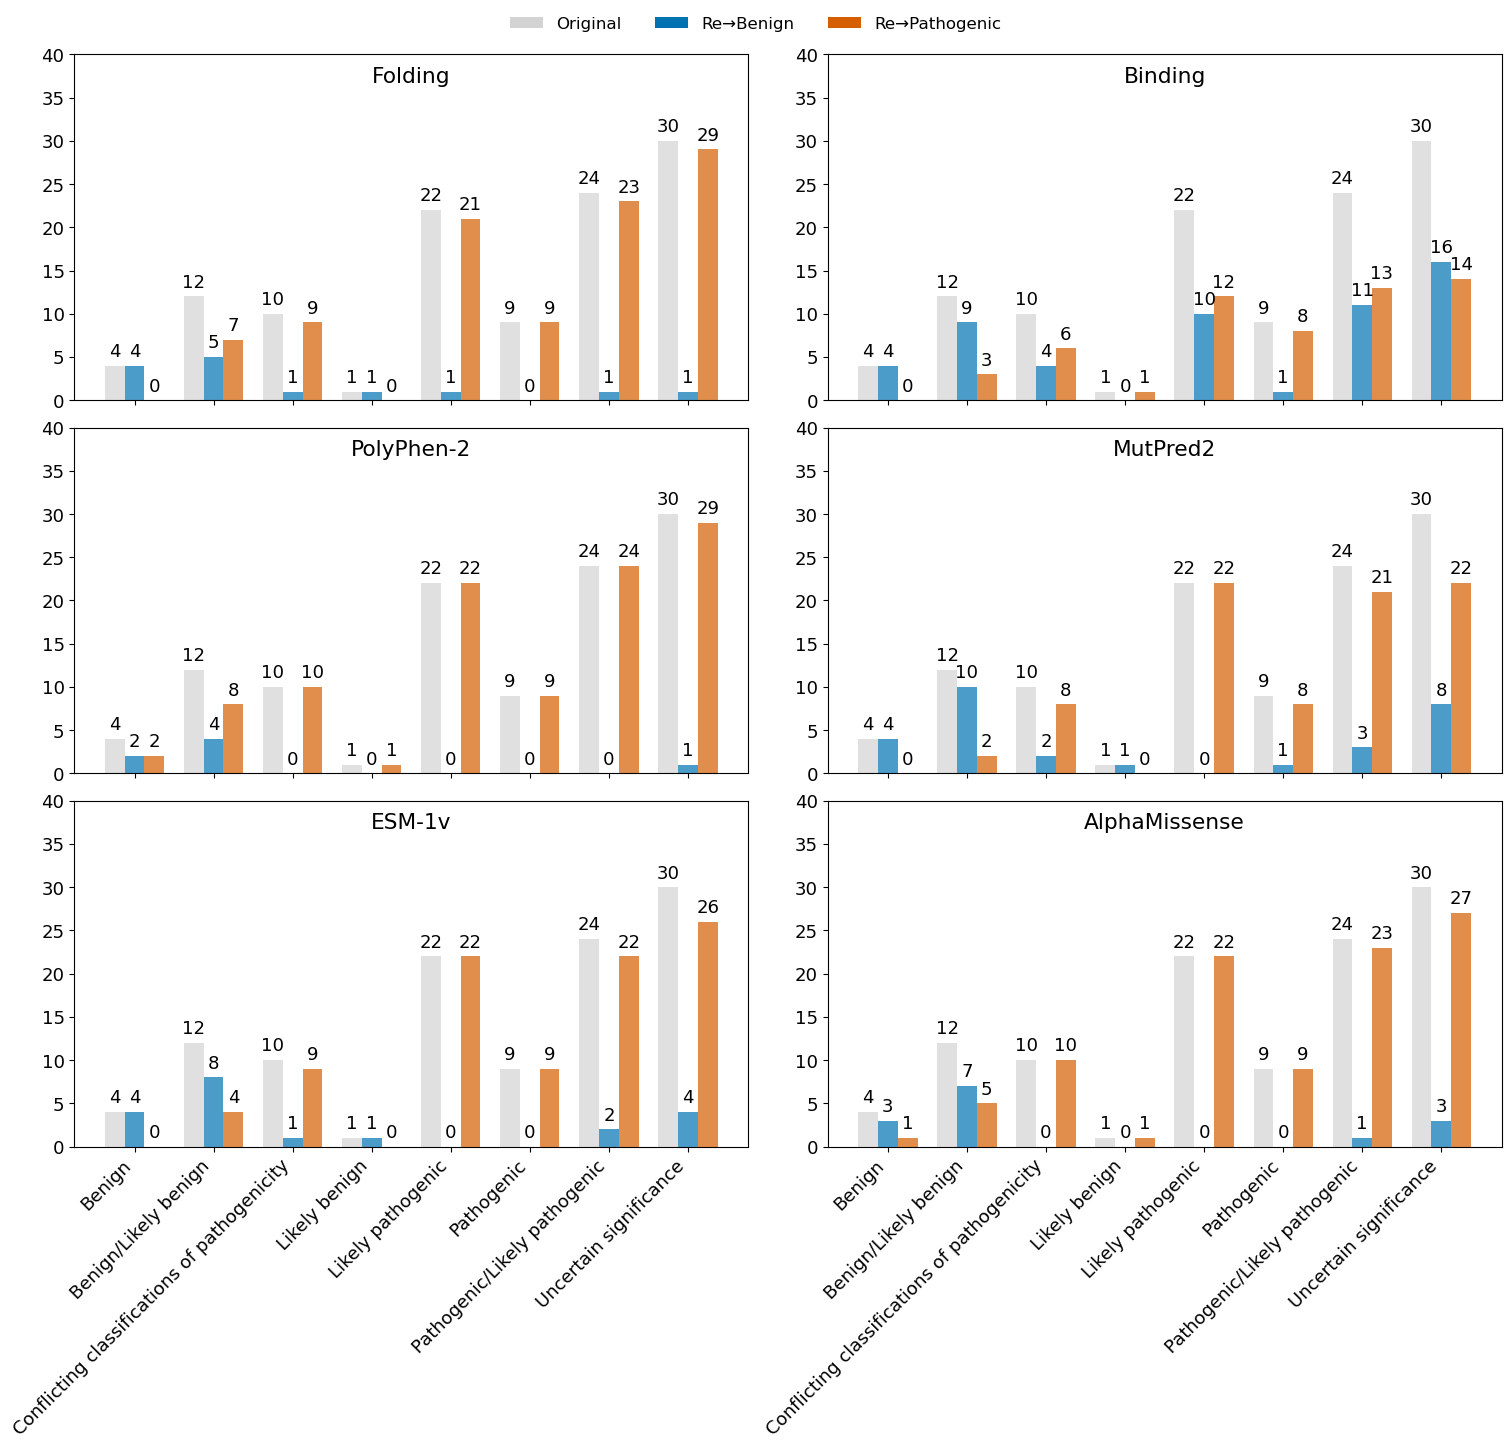

Saved plot to: /project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/all_methods_reclassification.png


In [79]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from matplotlib.patches import Patch

# ── Paths ─────────────────────────────────────────────────────────────────
root      = "/project/ealexov/compbio/shamrat/250519_energy"
save_path = os.path.join(root, "05_pathogenicity", "all_methods_reclassification.png")

files = {
    'Original':      os.path.join(root, "00_data",
                                  "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg.xlsx"),
    'PolyPhen-2':    os.path.join(root, "05_pathogenicity/01_polyphen2",
                                  "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_polyphen2.xlsx"),
    'MutPred2':      os.path.join(root, "05_pathogenicity/02_mutpred2",
                                  "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_classified_mutpred2.xlsx"),
    'ESM-1v':        os.path.join(root, "05_pathogenicity/03_esm",
                                  "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_esm1v.xlsx"),
    'AlphaMissense': os.path.join(root, "05_pathogenicity/08_alphamissense",
                                  "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_alphamissense.xlsx"),
    'Folding':       os.path.join(root, "02_folding",
                                  "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af.xlsx"),
    'Binding':       os.path.join(root, "04_binding",
                                  "clinvar_1kgp_hector_gaf_final_binding.xlsx")
}

# ── Helper to load & filter positions 1–302 ──────────────────────────────
def load1_302(path):
    df = pd.read_excel(path, engine='openpyxl')
    poscol = 'position_x' if 'position_x' in df.columns else 'position'
    return df[df[poscol].between(1,302)].copy()

# ── Load and compute Recall for each method ───────────────────────────────
dfs = {name: load1_302(fp) for name, fp in files.items()}
orig = dfs['Original']
orig_order = sorted(orig['Germline classification'].unique())

# PolyPhen-2
pp2 = dfs['PolyPhen-2'].copy()
pp2['Recall'] = pp2['prediction']\
    .str.lower().str.strip()\
    .map(lambda x: 'Benign' if x=='benign' else 'Pathogenic')

# MutPred2
mp2 = dfs['MutPred2'].copy()
mp2['Recall'] = mp2['MutPred2_classification']

# ESM-1v
es = dfs['ESM-1v'].copy()
es['true'] = (es['Germline classification']!='Benign').astype(int)
fpr, tpr, thr = roc_curve(es['true'], -es['delta_score'])
cutoff_es = -thr[np.argmax(tpr - fpr)]
es['Recall'] = es['delta_score'].apply(lambda x: 'Benign' if x>=cutoff_es else 'Pathogenic')

# Folding
fd = dfs['Folding'].copy()
fold_cols = [c for c in fd.columns if c.endswith('_str') and 'foldx' not in c.lower()]
fd['ddG_Fmax'] = fd[fold_cols].abs().max(axis=1)
ben_f = fd[fd['Germline classification']=='Benign']['ddG_Fmax']
pat_f = fd[fd['Germline classification']=='Pathogenic']['ddG_Fmax']
cutoff_f = (ben_f.max() + pat_f.min())/2
fd['Recall'] = fd['Germline classification']
mask_f = ~fd['Germline classification'].isin(['Benign','Pathogenic'])
fd.loc[mask_f & (fd['ddG_Fmax']>=cutoff_f), 'Recall'] = 'Pathogenic'
fd.loc[mask_f & (fd['ddG_Fmax']< cutoff_f), 'Recall'] = 'Benign'

# Binding (fixed column name)
bd = dfs['Binding'].copy()
bind_cols = [c for c in bd.columns if c.startswith('ddg_') and '_str_' in c]
targets = {"SOX9":"197-202","AMPH1":"290-294","GATAD2A":"97-101","ZNF219":"111-115"}
for gene, motif in targets.items():
    cols = [c for c in bind_cols if f"_{gene}_" in c and f"_{motif}_" in c]
    if cols:
        bd[f"ddG_B_{gene}"] = bd[cols].abs().mean(axis=1)
bd['ddG_Bmax'] = bd[[c for c in bd.columns if c.startswith('ddG_B_')]].max(axis=1)
ben_b = bd[bd['Germline classification']=='Benign']['ddG_Bmax']
pat_b = bd[bd['Germline classification']=='Pathogenic']['ddG_Bmax']
cutoff_b = (ben_b.max() + pat_b.min())/2
bd['Recall'] = bd['Germline classification']
mask_b = ~bd['Germline classification'].isin(['Benign','Pathogenic'])
bd.loc[mask_b & (bd['ddG_Bmax']>=cutoff_b), 'Recall'] = 'Pathogenic'
bd.loc[mask_b & (bd['ddG_Bmax']< cutoff_b), 'Recall'] = 'Benign'

# AlphaMissense
am = dfs['AlphaMissense'].copy()
full_am = pd.read_excel(files['AlphaMissense'], engine='openpyxl')
amb_full = full_am[full_am['am_class']=='ambiguous']['am_pathogenicity']
pat_full= full_am[full_am['am_class']=='likely_pathogenic']['am_pathogenicity']
cutoff_am= (amb_full.max() + pat_full.min())/2
am['Recall'] = am['am_class'].map(lambda x: 'Benign' if x in ['likely_benign','ambiguous'] else 'Pathogenic')
mask_am = am['am_class']=='ambiguous'
am.loc[mask_am, 'Recall'] = am.loc[mask_am,'am_pathogenicity']\
    .apply(lambda s: 'Benign' if s<cutoff_am else 'Pathogenic')

# ── Plot helper ───────────────────────────────────────────────────────────
def plot_grouped(ax, orig_ser, rec_ser, title):
    x = np.arange(len(orig_order))
    w = 0.25
    orig_cnt = orig_ser.value_counts().reindex(orig_order).values
    ct = pd.crosstab(orig_ser, rec_ser)\
           .reindex(index=orig_order, columns=['Benign','Pathogenic'], fill_value=0)
    rb, rp = ct['Benign'].values, ct['Pathogenic'].values
    ymax = max(orig_cnt.max(), rb.max(), rp.max())

    ax.bar(x-w, orig_cnt, w, color='lightgray', alpha=0.7)
    ax.bar(x,   rb,       w, color='#0072B2', alpha=0.7)
    ax.bar(x+w, rp,       w, color='#D55E00', alpha=0.7)
    for container in ax.containers:
        for rect in container:
            h = rect.get_height()
            ax.text(rect.get_x()+rect.get_width()/2,
                    h + ymax*0.02, str(int(h)), ha='center', va='bottom')

    ax.set_title(title, y=0.92, pad=0, loc='center')

# ── Build figure ─────────────────────────────────────────────────────────
fig, axes = plt.subplots(3, 2, figsize=(15,14), constrained_layout=True)
axes = axes.flatten()
sequence = [
    ('Folding',      fd['Recall']),
    ('Binding',      bd['Recall']),
    ('PolyPhen-2',   pp2['Recall']),
    ('MutPred2',     mp2['Recall']),
    ('ESM-1v',       es['Recall']),
    ('AlphaMissense',am['Recall'])
]

for ax, (name, rec) in zip(axes, sequence):
    plot_grouped(ax, orig['Germline classification'], rec, name)
    if not ax.get_subplotspec().is_last_row():
        ax.set_xticklabels([])
    else:
        ax.set_xticks(np.arange(len(orig_order)))
        ax.set_xticklabels(orig_order, rotation=45, ha='right')

# ── Set common y-axis limit and ticks ─────────────────────────────────────
for ax in axes:
    ax.set_ylim(0, 40)
    ax.set_yticks(np.arange(0, 41, 5))

# ── Single shared legend above all plots ─────────────────────────────────
handles = [
    Patch(facecolor='lightgray', label='Original'),
    Patch(facecolor='#0072B2', label='Re→Benign'),
    Patch(facecolor='#D55E00', label='Re→Pathogenic')
]
fig.subplots_adjust(top=0.88)  # make room for legend
fig.legend(handles=handles,
           loc='upper center',
           bbox_to_anchor=(0.5, 1.03),
           ncol=3,
           frameon=False,
           fontsize=12)

# ── Shared x-axis label ───────────────────────────────────────────────────
fig.text(0.5, 0.02, ' ',
         ha='center', va='center', fontsize=14)

# ── Save & show ───────────────────────────────────────────────────────────
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

print("Saved plot to:", save_path)


/local_scratch/slurm.4034100/ipykernel_887822/1667586768.py:114: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(top=0.88)


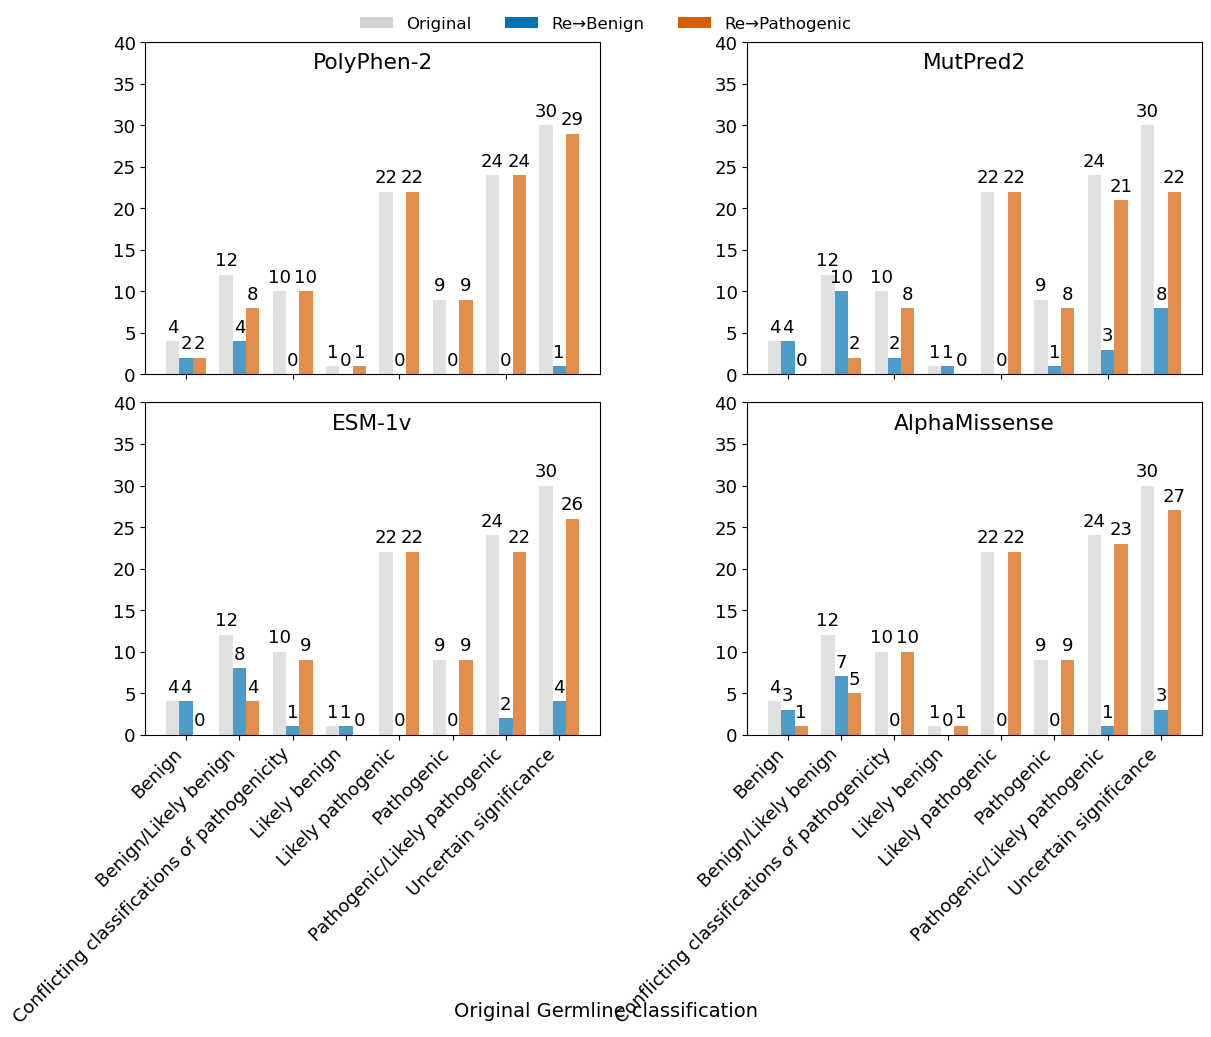

Saved plot to: /project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/all_methods_reclassification.png


In [83]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from matplotlib.patches import Patch

# ── Paths ─────────────────────────────────────────────────────────────────
root      = "/project/ealexov/compbio/shamrat/250519_energy"
save_path = os.path.join(root, "05_pathogenicity", "all_methods_reclassification.png")

files = {
    'Original':      os.path.join(root, "00_data",
                                  "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg.xlsx"),
    'PolyPhen-2':    os.path.join(root, "05_pathogenicity/01_polyphen2",
                                  "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_polyphen2.xlsx"),
    'MutPred2':      os.path.join(root, "05_pathogenicity/02_mutpred2",
                                  "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_classified_mutpred2.xlsx"),
    'ESM-1v':        os.path.join(root, "05_pathogenicity/03_esm",
                                  "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_esm1v.xlsx"),
    'AlphaMissense': os.path.join(root, "05_pathogenicity/08_alphamissense",
                                  "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_alphamissense.xlsx")
}

# ── Helper to load & filter positions 1–302 ──────────────────────────────
def load1_302(path):
    df = pd.read_excel(path, engine='openpyxl')
    poscol = 'position_x' if 'position_x' in df.columns else 'position'
    return df[df[poscol].between(1,302)].copy()

# ── Load and compute Recall for each method ───────────────────────────────
dfs = {name: load1_302(fp) for name, fp in files.items()}
orig_df = dfs['Original']
orig_ser = orig_df['Germline classification']
orig_order = sorted(orig_ser.unique())

# PolyPhen-2
pp2 = dfs['PolyPhen-2'].copy()
pp2['Recall'] = pp2['prediction']\
    .str.lower().str.strip()\
    .map(lambda x: 'Benign' if x=='benign' else 'Pathogenic')

# MutPred2
mp2 = dfs['MutPred2'].copy()
mp2['Recall'] = mp2['MutPred2_classification']

# ESM-1v
es = dfs['ESM-1v'].copy()
es['true'] = (es['Germline classification']!='Benign').astype(int)
fpr, tpr, thr = roc_curve(es['true'], -es['delta_score'])
cutoff_es = -thr[np.argmax(tpr - fpr)]
es['Recall'] = es['delta_score'].apply(lambda x: 'Benign' if x>=cutoff_es else 'Pathogenic')

# AlphaMissense
am = dfs['AlphaMissense'].copy()
full_am = pd.read_excel(files['AlphaMissense'], engine='openpyxl')
amb_full = full_am[full_am['am_class']=='ambiguous']['am_pathogenicity']
pat_full = full_am[full_am['am_class']=='likely_pathogenic']['am_pathogenicity']
cutoff_am = (amb_full.max() + pat_full.min())/2
am['Recall'] = am['am_class'].map(lambda x: 'Benign' if x in ['likely_benign','ambiguous'] else 'Pathogenic')
mask_am = am['am_class']=='ambiguous'
am.loc[mask_am, 'Recall'] = am.loc[mask_am,'am_pathogenicity']\
    .apply(lambda s: 'Benign' if s<cutoff_am else 'Pathogenic')

# ── Plot helper ───────────────────────────────────────────────────────────
def plot_grouped(ax, orig_ser, rec_ser, title):
    x = np.arange(len(orig_order))
    w = 0.25
    orig_cnt = orig_ser.value_counts().reindex(orig_order).values
    ct = pd.crosstab(orig_ser, rec_ser)\
           .reindex(index=orig_order, columns=['Benign','Pathogenic'], fill_value=0)
    rb, rp = ct['Benign'].values, ct['Pathogenic'].values
    ymax = max(orig_cnt.max(), rb.max(), rp.max())

    ax.bar(x-w, orig_cnt, w, color='lightgray', alpha=0.7)
    ax.bar(x,   rb,       w, color='#0072B2', alpha=0.7)
    ax.bar(x+w, rp,       w, color='#D55E00', alpha=0.7)
    for container in ax.containers:
        for rect in container:
            h = rect.get_height()
            ax.text(rect.get_x()+rect.get_width()/2,
                    h + ymax*0.02, str(int(h)), ha='center', va='bottom')
    ax.set_title(title, y=0.92, pad=0, loc='center')

# ── Build figure ─────────────────────────────────────────────────────────
fig, axes = plt.subplots(2, 2, figsize=(12,10), constrained_layout=True)
axes = axes.flatten()
sequence = [
    ('PolyPhen-2',    pp2['Recall']),
    ('MutPred2',      mp2['Recall']),
    ('ESM-1v',        es['Recall']),
    ('AlphaMissense', am['Recall'])
]

for ax, (name, rec) in zip(axes, sequence):
    plot_grouped(ax, orig_ser, rec, name)
    if not ax.get_subplotspec().is_last_row():
        ax.set_xticklabels([])
    else:
        ax.set_xticks(np.arange(len(orig_order)))
        ax.set_xticklabels(orig_order, rotation=45, ha='right')

# ── Set common y-axis limit and ticks ─────────────────────────────────────
for ax in axes:
    ax.set_ylim(0, 40)
    ax.set_yticks(np.arange(0, 41, 5))

# ── Single shared legend above all plots ─────────────────────────────────
handles = [
    Patch(facecolor='lightgray', label='Original'),
    Patch(facecolor='#0072B2', label='Re→Benign'),
    Patch(facecolor='#D55E00', label='Re→Pathogenic')
]
fig.subplots_adjust(top=0.88)
fig.legend(handles=handles,
           labels=[h.get_label() for h in handles],
           loc='upper center',
           bbox_to_anchor=(0.5, 1.03),
           ncol=3,
           frameon=False,
           fontsize=12)

# ── Shared x-axis label ───────────────────────────────────────────────────
fig.text(0.5, 0.02, 'Original Germline classification',
         ha='center', va='center', fontsize=14)

# ── Save & show ───────────────────────────────────────────────────────────
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

print("Saved plot to:", save_path)


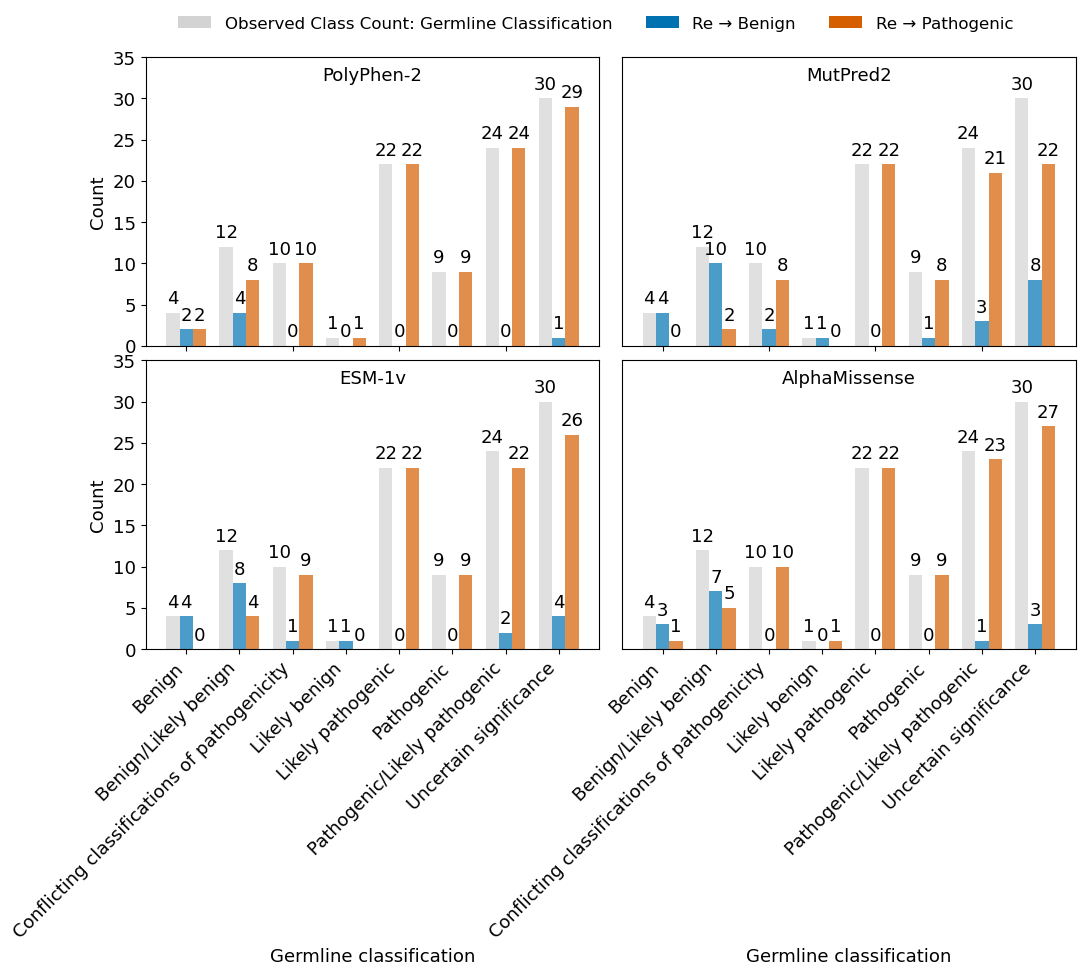

Saved plot to: /project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/all_methods_reclassification.png


In [129]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from matplotlib.patches import Patch

# ── Paths ─────────────────────────────────────────────────────────────────
root      = "/project/ealexov/compbio/shamrat/250519_energy"
save_path = os.path.join(root, "05_pathogenicity", "all_methods_reclassification.png")

files = {
    'Original':      os.path.join(root, "00_data",
                                  "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg.xlsx"),
    'PolyPhen-2':    os.path.join(root, "05_pathogenicity/01_polyphen2",
                                  "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_polyphen2.xlsx"),
    'MutPred2':      os.path.join(root, "05_pathogenicity/02_mutpred2",
                                  "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_classified_mutpred2.xlsx"),
    'ESM-1v':        os.path.join(root, "05_pathogenicity/03_esm",
                                  "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_esm1v.xlsx"),
    'AlphaMissense': os.path.join(root, "05_pathogenicity/08_alphamissense",
                                  "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_alphamissense.xlsx")
}

def load1_302(path):
    df = pd.read_excel(path, engine='openpyxl')
    pos = 'position_x' if 'position_x' in df.columns else 'position'
    return df[df[pos].between(1,302)].copy()

# ── Load & prepare ─────────────────────────────────────────────────────────
dfs       = {name: load1_302(fp) for name, fp in files.items()}
orig_ser  = dfs['Original']['Germline classification']
orig_order = sorted(orig_ser.unique())

# PolyPhen-2
pp2 = dfs['PolyPhen-2'].copy()
pp2['Recall'] = pp2['prediction']\
                  .str.lower().str.strip()\
                  .map(lambda x: 'Benign' if x=='benign' else 'Pathogenic')

# MutPred2
mp2 = dfs['MutPred2'].copy()
mp2['Recall'] = mp2['MutPred2_classification']

# ESM-1v
es = dfs['ESM-1v'].copy()
es['true'] = (es['Germline classification']!='Benign').astype(int)
fpr, tpr, thr = roc_curve(es['true'], -es['delta_score'])
cutoff_es = -thr[np.argmax(tpr - fpr)]
es['Recall'] = es['delta_score'].apply(lambda x: 'Benign' if x>=cutoff_es else 'Pathogenic')

# AlphaMissense
am = dfs['AlphaMissense'].copy()
full_am = pd.read_excel(files['AlphaMissense'], engine='openpyxl')
amb     = full_am[full_am['am_class']=='ambiguous']['am_pathogenicity']
pat     = full_am[full_am['am_class']=='likely_pathogenic']['am_pathogenicity']
cutoff_am = (amb.max() + pat.min()) / 2
am['Recall'] = am['am_class']\
                  .map(lambda c: 'Benign' if c in ['likely_benign','ambiguous'] else 'Pathogenic')
mask = am['am_class']=='ambiguous'
am.loc[mask, 'Recall'] = am.loc[mask,'am_pathogenicity']\
                             .apply(lambda s: 'Benign' if s<cutoff_am else 'Pathogenic')

# ── Plot helper ───────────────────────────────────────────────────────────
def plot_grouped(ax, orig_ser, rec_ser, title):
    x = np.arange(len(orig_order))
    w = 0.25
    orig_cnt = orig_ser.value_counts().reindex(orig_order).values
    ct = pd.crosstab(orig_ser, rec_ser)\
           .reindex(index=orig_order, columns=['Benign','Pathogenic'], fill_value=0)
    rb, rp = ct['Benign'].values, ct['Pathogenic'].values

    ax.bar(x-w, orig_cnt, w, color='lightgray', alpha=0.7)
    ax.bar(x,   rb,       w, color='#0072B2', alpha=0.7)
    ax.bar(x+w, rp,       w, color='#D55E00', alpha=0.7)

    ymax = max(orig_cnt.max(), rb.max(), rp.max())
    for c in ax.containers:
        for r in c:
            h = r.get_height()
            ax.text(r.get_x()+r.get_width()/2,
                    h + ymax*0.02, str(int(h)),
                    ha='center', va='bottom', fontsize=10)

    ax.set_title(title, y=0.92, pad=0, loc='center')

# ── Build figure ─────────────────────────────────────────────────────────
fig, axes = plt.subplots(2, 2,
                         figsize=(14, 10),
                         sharey='row',
                         gridspec_kw={'wspace': 0.05, 'hspace': 0.05})

axes = axes.flatten()
sequence = [
    ('PolyPhen-2',    pp2['Recall']),
    ('MutPred2',      mp2['Recall']),
    ('ESM-1v',        es['Recall']),
    ('AlphaMissense', am['Recall'])
]

for idx, (ax, (name, rec)) in enumerate(zip(axes, sequence)):
    plot_grouped(ax, orig_ser, rec, name)

    if idx < 2:
        ax.set_xticklabels([])
    else:
        ax.set_xticks(np.arange(len(orig_order)))
        ax.set_xticklabels(orig_order, rotation=45, ha='right')

    if idx % 2 == 1:
        ax.get_yaxis().set_visible(False)

for ax in axes:
    ax.set_ylim(0, 35)
    ax.set_yticks(np.arange(0, 36, 5))

# ── Single legend (with descriptive labels) ──────────────────────────────
handles = [
    Patch(facecolor='lightgray', label='Observed Class Count: Germline Classification'),
    Patch(facecolor='#0072B2',    label='Re → Benign'),
    Patch(facecolor='#D55E00',    label='Re → Pathogenic')
]
fig.subplots_adjust(top=0.88)
fig.legend(handles=handles,
           loc='upper center',
           bbox_to_anchor=(0.5, 0.92),
           ncol=3,
           frameon=False,
           fontsize=12)

for ax in axes[2:]:
    ax.set_xlabel('Germline classification', fontsize=14)
axes[0].set_ylabel('Count', fontsize=14)
axes[2].set_ylabel('Count', fontsize=14)

# ── Cosmetic Helper Functions ─────────────────────────────────────────────
def set_figure_size(fig, width, height):
    fig.set_size_inches(width, height)

def set_global_font(size):
    plt.rcParams.update({'font.size': size})

def set_axis_label_font(ax, xlabel_size=None, ylabel_size=None):
    if xlabel_size is not None:
        ax.xaxis.label.set_size(xlabel_size)
    if ylabel_size is not None:
        ax.yaxis.label.set_size(ylabel_size)

def set_tick_font(ax, tick_size):
    ax.tick_params(axis='both', labelsize=tick_size)

def set_title_font(ax, size):
    ax.title.set_fontsize(size)

def set_bar_text_font(ax, size):
    for txt in ax.texts:
        txt.set_fontsize(size)

def adjust_spacing(fig, wspace=None, hspace=None, top=None):
    fig.subplots_adjust(
        wspace = wspace if wspace is not None else fig.subplotpars.wspace,
        hspace = hspace if hspace is not None else fig.subplotpars.hspace,
        top    = top    if top    is not None else fig.subplotpars.top
    )

# ── Cosmetics Block: call here to tweak everything ────────────────────────
FIG_WIDTH        = 12
FIG_HEIGHT       = 8
GLOBAL_FONT      = 13
TITLE_FONT       = 13
TICK_FONT        = 13
LABEL_FONT       = 13
BAR_TEXT_FONT    = 13
WSPACE           = 0.10
HSPACE           = 0.10
TOP_MARGIN       = 0.85

# apply
set_figure_size(fig, FIG_WIDTH, FIG_HEIGHT)
set_global_font(GLOBAL_FONT)
for ax in axes:
    set_title_font(ax, TITLE_FONT)
    set_axis_label_font(ax, xlabel_size=LABEL_FONT, ylabel_size=LABEL_FONT)
    set_tick_font(ax, TICK_FONT)
    set_bar_text_font(ax, BAR_TEXT_FONT)

adjust_spacing(fig, wspace=WSPACE, hspace=HSPACE, top=TOP_MARGIN)
# ── End Cosmetics ─────────────────────────────────────────────────────────

# ── Save & display ────────────────────────────────────────────────────────
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()
print("Saved plot to:", save_path)


In [2]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve

# ── Paths ───────────────────────────────────────────────────────────────────
root = "/project/ealexov/compbio/shamrat/250519_energy"
files = {
    'Original':      os.path.join(root, "00_data",
                                  "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg.xlsx"),
    'PolyPhen-2':    os.path.join(root, "05_pathogenicity/01_polyphen2",
                                  "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_polyphen2.xlsx"),
    'MutPred2':      os.path.join(root, "05_pathogenicity/02_mutpred2",
                                  "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_classified_mutpred2.xlsx"),
    'ESM-1v':        os.path.join(root, "05_pathogenicity/03_esm",
                                  "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_esm1v.xlsx"),
    'AlphaMissense': os.path.join(root, "05_pathogenicity/08_alphamissense",
                                  "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_alphamissense.xlsx")
}

def load1_302(path):
    df = pd.read_excel(path, engine='openpyxl')
    pos = 'position_x' if 'position_x' in df.columns else 'position'
    return df[df[pos].between(1,302)].copy()

# ── Load & filter ───────────────────────────────────────────────────────────
dfs = {name: load1_302(fp) for name, fp in files.items()}
orig = dfs['Original']['Germline classification'].reset_index(drop=True)

# ── Label “Recall” for each method ───────────────────────────────────────────
# PolyPhen-2
pp2 = dfs['PolyPhen-2'].copy()
pp2['Recall'] = pp2['prediction'].str.lower().map(lambda x: 'Benign' if x=='benign' else 'Pathogenic')

# MutPred2
mp2 = dfs['MutPred2'].copy()
mp2['Recall'] = mp2['MutPred2_classification']

# ESM-1v: ROC cutoff
es = dfs['ESM-1v'].copy()
es['true'] = (es['Germline classification']!='Benign').astype(int)
fpr, tpr, thr = roc_curve(es['true'], -es['delta_score'])
cut_es = -thr[np.argmax(tpr-fpr)]
es['Recall'] = es['delta_score'].apply(lambda x: 'Benign' if x>=cut_es else 'Pathogenic')

# AlphaMissense
am = dfs['AlphaMissense'].copy()
full_am = pd.read_excel(files['AlphaMissense'], engine='openpyxl')
amb = full_am[full_am['am_class']=='ambiguous']['am_pathogenicity']
pat = full_am[full_am['am_class']=='likely_pathogenic']['am_pathogenicity']
cut_am = (amb.max() + pat.min())/2
def recall_am(r):
    if r['am_class']=='likely_benign':
        return 'Benign'
    if r['am_class']=='ambiguous':
        return 'Benign' if r['am_pathogenicity']<cut_am else 'Pathogenic'
    return 'Pathogenic'
am['Recall'] = am.apply(recall_am, axis=1)

# ── Helper to print counts ───────────────────────────────────────────────────
def summarize(name, recall_ser):
    print(f"\n{name}:")
    print(" Original counts:")
    print(orig.value_counts().to_string())
    print(" Recalled counts:")
    print(recall_ser.value_counts().to_string())
    print(" Crosstab Original vs Recall:")
    print(pd.crosstab(orig, recall_ser).to_string())
    
# ── Print summaries for each method ─────────────────────────────────────────
summarize("PolyPhen-2",    pp2['Recall'])
summarize("MutPred2",      mp2['Recall'])
summarize("ESM-1v",        es['Recall'])
summarize("AlphaMissense", am['Recall'])



PolyPhen-2:
 Original counts:
Germline classification
Uncertain significance                          30
Pathogenic/Likely pathogenic                    24
Likely pathogenic                               22
Benign/Likely benign                            12
Conflicting classifications of pathogenicity    10
Pathogenic                                       9
Benign                                           4
Likely benign                                    1
 Recalled counts:
Recall
Pathogenic    112
 Crosstab Original vs Recall:
Recall                                        Pathogenic
Germline classification                                 
Benign                                                 4
Benign/Likely benign                                  12
Conflicting classifications of pathogenicity          10
Likely benign                                          1
Likely pathogenic                                     22
Pathogenic                                             9
Pathogen